# <font color = 'darkblue'> OGIM: NA/SA geopackage v1.2

# Data consolidation 

In [1]:
# Import libraries
# ===========================================================================
import warnings
warnings.filterwarnings('ignore')

import pprint
from sigfig import round # !pip install sigfig
from tqdm import tqdm 

import os
# ===========================================================================
# ogimlib
from ogimlib import *

%matplotlib inline

In [2]:
# Change directory
os.chdir(r"C:\Users\momara\OneDrive - MethaneSAT, LLC\OGIM\Public_Data\results\OGIM_NA_SA_v1.2")

In [3]:
# Maps
# Plotting scatter map 
# ==============================
# PLOT POINTS
# FUNCTION for adding SCALES to maps

from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib
import os
import cartopy.crs as ccrs 
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor((lon+180)/6)+1

def scale_bar(
    ax, 
    proj, 
    length, 
    location=(0.5, 0.05), 
    linewidth=3,
    units='km', 
    m_per_unit=1000
    ):
    
    """
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)
    
def scatterMaps(
    gdf, 
    lat_lon=True,
    lat_attribute="LATITUDE",
    lon_attribute="LONGITUDE",
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=8, 
    figHeight=8,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Wells",
    showLegend=True,
    saveFigPath=None,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    ):
    '''
    Inputs:
    ---
        gdf: dataframe or geodataframe. 
        lat_lon: bool, if True, no need to calculate these values ('latitude', 'longitude') based on the dataset geometries.
        fpShp: Path to shapefile if it is desired to overlay a polygon boundary on the scatter map
        figHeight: figure height
        figWidth: figure width
        showPipelines: bool, if True, plots pipeline data instead of scatter map
        pipe_len_attrName: Attribute name for data for length of pipeline for each feature in gdf
        markerSize: for simple scatter plots without scaling or heatmaps, specify marker size
        markerColor: marker color based on MatplotLib standard color names
        NA_SA_extent: if True, forces figure extent to the North America/South America extent
        figTitle: show figure title
        dataLabel: displays legend or colorbar axis label if heatmap is plotted
        showLegend: if True, display legend
        showArea: if True, displays the polygon in fpShp
        showScale: if True, displays a 100-km scale on the map
        heatMap: if True, plots the points and colors them by colorAttr
        colorAttr: attribute for sizing and coloring the scattered points
        dataScaling: allows for modification of scatter point marker size
        colorMapName: name of MatplotLib's color ramp to use in plotting heatmap
        axisLabels: if True, label x and y axis of figure object as Longitude and Latitude
        showStates: if True, show state boundaries
        showBorders: if True, show country borders
        showCoast: if True, show coast line
        showLand: if True, show land in light yellow
        showOcean: if True, show ocean in light blue
        showLakes: if True, show lakes
        showRivers: if True, show rivers
        
    Returns:
    ---
        fig: scatter map or line map
    
    '''
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import cartopy.crs as ccrs

    # scatter plot
    #======================================
    # For setting extents
    # Check that data is in EPSG:4326
    if gdf.crs == "EPSG:4326" and showPipelines==False:
        if lat_lon == True:
            dataLon, dataLat = gdf[lon_attribute], gdf[lat_attribute] # If latitude and longitude labels are included as attributes in the data
        else:
            dataLon, dataLat = gdf.geometry.x, gdf.geometry.y # For geodataframe in EPSG:4326 with no latitude/longitude attributes
            gdf['longitude'] = dataLon
            gdf['latitude'] = dataLat
        # Creates the map
        fig = plt.figure(figsize = (figWidth, figHeight))
        
        # Fig. axis decorations
        ca_map = fig.add_subplot(111, projection = ccrs.PlateCarree())
        
        if showLand==True:
            ca_map.add_feature(cfeature.LAND)
        if showOcean==True:
            ca_map.add_feature(cfeature.OCEAN)
        if showBorders==True:
            ca_map.add_feature(cfeature.BORDERS, linestyle='-', lw=1, edgecolor='gray')
        if showCoast==True:
            ca_map.add_feature(cfeature.COASTLINE, linestyle='-', lw=1, edgecolor='gray')
        if showLakes==True:
            ca_map.add_feature(cfeature.LAKES, alpha = 0.5)
        if showRivers==True:
            ca_map.add_feature(cfeature.RIVERS)
        if showStates==True:
            ca_map.add_feature(cfeature.STATES.with_scale('10m'), lw = 0.1, edgecolor='gray')

        ca_map.tick_params(direction = 'out', length = 6, labelsize = 14)
        
        # If desired to aoverlay polygon boundary (.shp) of specific region on the map
        if fpShp is not None:
            reader = shpreader.Reader(fpShp)
            area = list(reader.geometries())
            AREA = cfeature.ShapelyFeature(area, ccrs.PlateCarree())
    
        if showArea == True:
            ca_map.add_feature(AREA, facecolor = 'none', edgecolor = 'darkred', lw = 3)
        
        # Set approximate map extent
        if NA_SA_extent==True:
            ca_map.set_extent([-160, -30, -60, 75], ccrs.PlateCarree())
        elif NA_SA_extent==False:
            try:
                ca_map.set_extent([dataLon.min()-0.5, dataLon.max()+0.5, dataLat.min()-0.5, dataLat.max()+0.5], ccrs.PlateCarree())
            except:
                print ("Not setting map extent")
                pass

        ca_map.xaxis.set_visible(True)
        ca_map.yaxis.set_visible(True)


        # Plots the data onto map
        if heatMap == False:
            scatter_ = ca_map.scatter(gdf[lon_attribute], gdf[lat_attribute], 
                                s=markerSize, label=dataLabel,
                                c=markerColor,
                                transform=ccrs.PlateCarree())
        elif heatMap == True:
            scatter_ = ca_map.scatter(gdf[lon_attribute], 
                                      gdf[lat_attribute], 
                                      s=gdf[colorAttr]/dataScaling, 
                                      label=dataLabel,
                                      c=gdf[colorAttr], 
                                      cmap = plt.get_cmap(colorMapName), 
                                      transform = ccrs.PlateCarree())
            

            # Colorbar
            cbar = plt.colorbar(scatter_, ax = ca_map)
            cbar.set_label(dataLabel, fontsize = 16)
            cbar.ax.tick_params(labelsize = 14)
            
        
        # Axes labels
        if axisLabels==True:
            ca_map.set_ylabel("Latitude", fontsize = 18)
            ca_map.set_xlabel("Longitude", fontsize = 18)

        # Add scale bar
        if showScale == True:
            scale_bar(ca_map, ccrs.PlateCarree(), 100, location = (0.25, 0.05))  # 100 km scale bar
            
        # Figure title
        if figTitle is not None:
            ca_map.set_title(figTitle + " $n = $" + str(gdf.shape[0]), fontsize=18, fontweight='bold', loc='left')
            
        # Show legend
        if showLegend==True:
            ca_map.legend(fontsize=16, fancybox=True, shadow=True, loc='lower left',markerscale=4.)
        
        # Show degree symbols in X and Y axes
        ca_map.xaxis.set_major_formatter(ticker.FormatStrFormatter( "%.f\N{DEGREE SIGN}"))
        ca_map.yaxis.set_major_formatter(ticker.FormatStrFormatter( "%.f\N{DEGREE SIGN}"))

#         fig.tight_layout()

    elif showPipelines == True:
        # Creates the map
        fig = plt.figure(figsize = (figWidth, figHeight))
        
        # Fig. axis decorations
        ca_map = fig.add_subplot(111, projection = ccrs.PlateCarree())
        
        if showLand==True:
            ca_map.add_feature(cfeature.LAND)
        if showOcean==True:
            ca_map.add_feature(cfeature.OCEAN)
        if showBorders==True:
            ca_map.add_feature(cfeature.BORDERS, linestyle='-', lw=1, edgecolor='gray')
        if showCoast==True:
            ca_map.add_feature(cfeature.COASTLINE, linestyle='-', lw=1, edgecolor='gray')
        if showLakes==True:
            ca_map.add_feature(cfeature.LAKES, alpha = 0.5)
        if showRivers==True:
            ca_map.add_feature(cfeature.RIVERS)
        if showStates==True:
            ca_map.add_feature(cfeature.STATES.with_scale('10m'), lw = 0.1, edgecolor='gray')

        ca_map.tick_params(direction = 'out', length = 6, labelsize = 14)
        
        # If desired to aoverlay polygon boundary (.shp) of specific region on the map
        if fpShp is not None:
            reader = shpreader.Reader(fpShp)
            area = list(reader.geometries())
            AREA = cfeature.ShapelyFeature(area, ccrs.PlateCarree())
    
        if showArea == True:
            ca_map.add_feature(AREA, facecolor = 'none', edgecolor = 'darkred', lw = 3)
        
        # Set approximate map extent
        if NA_SA_extent==True:
            ca_map.set_extent([-160, -30, -60, 75], ccrs.PlateCarree())
        elif NA_SA_extent==False:
            try:
                ca_map.set_extent([dataLon.min()-0.5, dataLon.max()+0.5, dataLat.min()-0.5, dataLat.max()+0.5], ccrs.PlateCarree())
            except:
                print ("Not setting map extent")
                pass

        ca_map.xaxis.set_visible(True)
        ca_map.yaxis.set_visible(True)
        
        # Plot
        pipes_ = gdf.plot(ax=ca_map, ls='-', color='blue', lw=2,transform = ccrs.PlateCarree())
        
        # Axes labels
        if axisLabels==True:
            ca_map.set_ylabel("Latitude", fontsize = 18)
            ca_map.set_xlabel("Longitude", fontsize = 18)

        # Add scale bar
        if showScale == True:
            scale_bar(ca_map, ccrs.PlateCarree(), 100, location = (0.25, 0.05))  # 100 km scale bar
            
        # Figure title
        if figTitle is not None:
            ca_map.set_title(figTitle + " total length = " + str(int(gdf[pipe_len_attrName].sum())) + " km", fontsize=18, fontweight='bold', loc='left')
            
        # Show legend
        if showLegend==True:
            ca_map.legend(fontsize=16, fancybox=True, shadow=True, loc='lower left',markerscale=4.)
        
        # Show degree symbols in X and Y axes
        ca_map.xaxis.set_major_formatter(ticker.FormatStrFormatter( "%.f\N{DEGREE SIGN}"))
        ca_map.yaxis.set_major_formatter(ticker.FormatStrFormatter( "%.f\N{DEGREE SIGN}"))

        print ("!! CRS is not set or not in EPSG:4326!!")
        
    if saveFigPath is not None:
        plt.savefig(saveFigPath)
    
    return fig

In [4]:
# Read .geojson/.SHP files from folder

def read_data_(file_names):
    """Read geojson files from a list of filenames"""
    all_data = []
    for file in file_names:
        gdf_ = gpd.read_file(file)
        all_data.append(gdf_)
    
    # Concatenate
    data = pd.concat(all_data)
    print("Total # of records = ", data.shape[0])
    
    display(data.head())
    
    return data

In [5]:
# Function for general data quality checks

def data_quality_checks(gdf, starting_ogim_id=1, check_attributes=True):
    """Check for consistency in:
        data types [OGIM_ID, SPUD_DATE, INSTALL_DATE, COMP_DATE]
        latitude, longitude significant figure digits
    """
    # Check OGIM_ID to make sure format is int
    gdf['OGIM_ID'] = gdf['OGIM_ID'].astype(int)
    
    # Facility ID type
    # =====================================================================
    try:
        gdf['FAC_ID'] = gdf['FAC_ID'].astype(str)
        unique_ids = gdf['FAC_ID'].unique()
    
        if 'UNKNOWN' in unique_ids or 'NOT AVAILABLE' in unique_ids or None in unique_ids:
            gdf = gdf.replace({'FAC_ID': {'UNKNOWN':'N/A', 'NOT AVAILABLE': 'N/A', None: 'N/A'}})
    except:
        pass
        
    # =====================================================================
    # FAC STATUS
    try:
        unique_status = gdf.FAC_STATUS.unique()
    
        if 'UNKNOWN' in unique_status or 'NOT AVAILABLE' in unique_status or "NA" in unique_status or None in unique_status:
            gdf = gdf.replace({'FAC_STATUS': {'UNKNOWN':'N/A', 'NOT AVAILABLE': 'N/A', "NA": "N/A", None: 'N/A'}})
    except:
        pass
        
    # =====================================================================
    # OPERATOR
    try:
        unique_operator = gdf.OPERATOR.unique()
    
        if 'UNKNOWN' in unique_operator or 'NOT AVAILABLE' in unique_operator or None in unique_operator:
            gdf = gdf.replace({'OPERATOR': {'UNKNOWN':'N/A', 'NOT AVAILABLE': 'N/A', None: 'N/A'}})
    except:
        pass
        
    # SPUD DATE
    # =====================================================================
    try:
        unique_spud = gdf.SPUD_DATE.unique()
        if 'UNKNOWN' in unique_spud or 'NOT AVAILABLE' in unique_spud or "1800-01-01" in unique_spud or "NA" in unique_spud or "1901-01-01" in unique_spud or None in unique_spud:
            gdf = gdf.replace({'SPUD_DATE': {'UNKNOWN':'1900-01-01', 'NOT AVAILABLE': '1900-01-01', "1800-01-01": "1900-01-01", "NA": "1900-01-01", None: '1900-01-01'}})
    except:
        pass
    
    # COMPLETION DATE
    # =====================================================================
    try:
        unique_comp = gdf.COMP_DATE.unique()
        if 'UNKNOWN' in unique_comp or 'NOT AVAILABLE' in unique_comp or "1800-01-01" in unique_comp or "NA" in unique_comp or "1901-01-01" in unique_comp or None in unique_comp:
            gdf = gdf.replace({'COMP_DATE': {'UNKNOWN':'1900-01-01', 'NOT AVAILABLE': '1900-01-01', "1800-01-01": "1900-01-01", "NA": "1900-01-01", None: '1900-01-01'}})
    except:
        pass
    
    # INSTALLATION DATE
    # =====================================================================
    try:
        unique_instl = gdf.INSTALL_DATE.unique()
        if 'UNKNOWN' in unique_instl or 'NOT AVAILABLE' in unique_instl or "1800-01-01" in unique_instl or "NA" in unique_instl or "1901-01-01" in unique_instl or None in unique_instl:
            gdf = gdf.replace({'COMP_DATE': {'UNKNOWN':'1900-01-01', 'NOT AVAILABLE': '1900-01-01', "1800-01-01": "1900-01-01", "NA": "1900-01-01", None: '1900-01-01'}})
    except:
        pass

    # LIQ_CAPACITY_BPD
    # =====================================================================
    try:
        unique_liq_capacity = gdf.LIQ_CAPACITY_BPD.unique()
        if 9999 in unique_liq_capacity or 999 in unique_liq_capacity or "9999" in unique_liq_capacity or "999" in unique_liq_capacity or "-999" in unique_liq_capacity or None in unique_liq_capacity:
            gdf = gdf.replace({'LIQ_CAPACITY_BPD': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # LIQ_THROUGHPUT_BPD
    # =====================================================================
    try:
        unique_liq_thru = gdf.LIQ_THROUGHPUT_BPD.unique()
        if 9999 in unique_liq_thru or 999 in unique_liq_thru or "9999" in unique_liq_thru or "999" in unique_liq_thru or "-999" in unique_liq_thru or None in unique_liq_thru:
            gdf = gdf.replace({'LIQ_THROUGHPUT_BPD': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # GAS_CAPACITY_MMCFD
    # =====================================================================
    try:
        unique_gas_cap = gdf.GAS_CAPACITY_MMCFD.unique()
        if 9999 in unique_gas_cap or 999 in unique_gas_cap or "9999" in unique_gas_cap or "999" in unique_gas_cap or "-999" in unique_gas_cap or None in unique_gas_cap:
            gdf = gdf.replace({'GAS_CAPACITY_MMCFD': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # GAS_THROUGHPUT_MMCFD
    # =====================================================================
    try:
        unique_gas_thru = gdf.GAS_THROUGHPUT_MMCFD.unique()
        if 9999 in unique_gas_thru or 999 in unique_gas_thru or "9999" in unique_gas_thru or "999" in unique_gas_thru or "-999" in unique_gas_thru or None in unique_gas_thru:
            gdf = gdf.replace({'GAS_THROUGHPUT_MMCFD': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # NUM_COMPR_UNITS
    # =====================================================================
    try:
        unique_num_compr = gdf.NUM_COMPR_UNITS.unique()
        if 9999 in unique_num_compr or 999 in unique_num_compr or "9999" in unique_num_compr or "999" in unique_num_compr or "-999" in unique_num_compr or None in unique_num_compr:
            gdf = gdf.replace({'NUM_COMPR_UNITS': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # SITE_HP
    # =====================================================================
    try:
        unique_site_hp = gdf.SITE_HP.unique()
        if 9999 in unique_site_hp or 999 in unique_site_hp or "9999" in unique_site_hp or "999" in unique_site_hp or "-999" in unique_site_hp or None in unique_site_hp:
            gdf = gdf.replace({'SITE_HP': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass
    
    # NUM_STORAGE_TANKS
    # =====================================================================
    try:
        unique_num_stor = gdf.NUM_STORAGE_TANKS.unique()
        if 9999 in unique_num_stor or 999 in unique_num_stor or "9999" in unique_num_stor or "999" in unique_num_stor or "-999" in unique_num_stor or None in unique_num_stor:
            gdf = gdf.replace({'NUM_STORAGE_TANKS': {9999:-999, '9999':-999, "999":-999, "-999":-999, 999:-999, None: -999}})
    except:
        pass

    # Check if there are NULL geometries in dataset
    gdf_list_null_ids, _ = check_invalid_geoms(gdf, id_attr='OGIM_ID')
    
    if len(gdf_list_null_ids) >= 1:
        print("!!!There are INVALID geometries in dataset!!! \n ===>Removing INVALID records <===")
        gdf2 = gdf[~gdf.OGIM_ID.isin(gdf_list_null_ids)]
    else:
        gdf2 = gdf
    
    # FIX LATITUDE AND LONGITUDE
    
    if "LATITUDE" in gdf2.columns:
        print("===================================")
        print("Now, standardizing `LATITUDE` and `LONGITUDE` columns")
        all_lat, all_lon = [], []
        for idx, row in tqdm(gdf2.iterrows()):
            if type(row.LATITUDE) == str or type(row.LONGITUDE) == str:
                lat, lon = float(row.LATITUDE), float(row.LONGITUDE)
            else:
                lat, lon = row.LATITUDE, row.LONGITUDE
        
            # Round to 5 decimal places
            try:
                new_lat = round(lat, decimals=5)
                new_lon = round(lon, decimals=5)
            except:
                pass
        
            all_lat.append(new_lat)
            all_lon.append(new_lon)
        
        gdf2['LONGITUDE'] = all_lon
        gdf2['LATITUDE'] = all_lat
        
    # Standardize pipe length and pipe diameter
    if "PIPE_LENGTH_KM" in gdf2.columns:
        print("===================================")
        print("Now, standardizing PIPELINE attributes (length, diameter)")
        all_len, all_diam = [], []
        # Then "PIPE_DIAMETER_MM" also in gdf2.columns
        for idx, row in tqdm(gdf2.iterrows()):
            if type(row.PIPE_LENGTH_KM) == str or type(row.PIPE_DIAMETER_MM) == str:
                leng, diam = float(row.PIPE_LENGTH_KM), float(row.PIPE_DIAMETER_MM)
            else:
                leng, diam = row.PIPE_LENGTH_KM, row.PIPE_DIAMETER_MM
                
            # Round to 3 significant digits
            try:
                new_len = round(leng, sigfigs=3)
                new_diam = round(diam, sigfigs=3)
            except:
                pass
        
            all_len.append(new_len)
            all_diam.append(new_diam)
            
        gdf2['PIPE_LENGTH_KM'] = all_len
        gdf2['PIPE_DIAMETER_MM'] = all_diam
        
    # Standardize basin area
    if "AREA_KM2" in gdf2.columns:
        areas = []
        for idx, row in tqdm(gdf2.iterrows()):
            if type(row.AREA_KM2) == str:
                area_ = float(row.AREA_KM2)
            else:
                area_ = row.AREA_KM2
                
            # Round to 3 significant digits
            try:
                new_area = round(area_, sigfigs=3)
            except:
                pass
        
            areas.append(new_area)
            
        gdf2['AREA_KM2'] = areas
            
    # Standardize PRODUCTION metrics
    if "OIL_BBL" in gdf2.columns:
        print("===================================")
        print("Now, standardizing PRODUCTION metrics")
        oil, gas, water, cond, prod_days, = [], [], [], [], []

        for idx, row in tqdm(gdf2.iterrows()):
            if type(row.OIL_BBL) == str or type(row.WATER_BBL) == str or type(row.CONDENSATE_BBL) == str or type(row.GAS_MCF) == str or type(row.PROD_DAYS) == str:
                oil1 = float(row.OIL_BBL)
                water1 = float(row.WATER_BBL)
                cond1 = float(row.CONDENSATE_BBL)
                gas1 = float(row.GAS_MCF)
                prod_ = float(row.PROD_DAYS)
            else:
                oil1 = (row.OIL_BBL)
                water1 = (row.WATER_BBL)
                cond1 = (row.CONDENSATE_BBL)
                gas1 = (row.GAS_MCF)
                prod_ = (row.PROD_DAYS)
                
            # Round to 3 significant digits
            try:
                oil2 = round(oil1, sigfigs=3)
                water2 = round(water1, sigfigs=3)
                cond2 = round(cond1, sigfigs=3)
                gas2 = round(gas1, sigfigs=3)
                prod2_ = round(prod_, sigfigs=3)
            except:
                print("***Exception in rounding index {} or OGIM_ID {}".format(idx, row.OGIM_ID))
                pass
        
            oil.append(oil2)
            gas.append(gas2)
            water.append(water2)
            cond.append(cond2)
            prod_days.append(prod2_)
            
        gdf2['OIL_BBL'] = oil
        gdf2['WATER_BBL'] = water
        gdf2['PROD_DAYS'] = prod_days
        gdf2['CONDENSATE_BBL'] = cond
        gdf2['GAS_MCF'] = gas
        
    # ======================================================================
    # Fix OGIM ID
    gdf2['OGIM_ID'] = np.arange(starting_ogim_id, starting_ogim_id+gdf2.shape[0])
    
    # Standardize data types
    # ======================================================================
    try:
        gdf2['LIQ_CAPACITY_BPD'] = pd.to_numeric(gdf2['LIQ_CAPACITY_BPD'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['LIQ_THROUGHPUT_BPD'] = pd.to_numeric(gdf2['LIQ_THROUGHPUT_BPD'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['GAS_CAPACITY_MMCFD'] = pd.to_numeric(gdf2['GAS_CAPACITY_MMCFD'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['GAS_THROUGHPUT_MMCFD'] = pd.to_numeric(gdf2['GAS_THROUGHPUT_MMCFD'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['NUM_COMPR_UNITS'] = pd.to_numeric(gdf2['NUM_COMPR_UNITS'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['SITE_HP'] = pd.to_numeric(gdf2['SITE_HP'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['NUM_STORAGE_TANKS'] = pd.to_numeric(gdf2['NUM_STORAGE_TANKS'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['PIPE_LENGTH_KM'] = pd.to_numeric(gdf2['PIPE_LENGTH_KM'])
    except:
        pass
    
    # ======================================================================
    try:
        gdf2['PIPE_DIAMETER_MM'] = pd.to_numeric(gdf2['PIPE_DIAMETER_MM'])
    except:
        pass
    
    # ======================================================================
    try:
        gdf2['AREA_KM2'] = pd.to_numeric(gdf2['AREA_KM2'])
    except:
        pass
    # ======================================================================
    try:
        gdf2['PROD_YEAR'] = pd.to_numeric(gdf2['PROD_YEAR'])
    except:
        pass
    # ======================================================================
    # Check unique attributes
    if check_attributes == True:
        for idx, attribute in enumerate(list(gdf2.columns)):
            print("==================================")
            print("{}.---> {} <----".format(idx, attribute))
            pprint.pprint(gdf2[attribute].unique())
            
    
    return gdf2


# Wells

In [6]:
# Read wells data
from tqdm import tqdm

file_names = glob.glob(os.getcwd() + "\\*well*.geojson")
wells_data_ = read_data_(file_names)

Total # of records =  2345536


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,SPUD_DATE,COMP_DATE,DRILL_TYPE,LATITUDE,LONGITUDE,geometry
0,3751587,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE.X-1,212,OIL,ACTIVE,COLHUE HUAPI S.A.,1996-10-30,1996-11-13,N/A,-45.59113,-68.28785000000001,POINT (-68.28785 -45.59113)
1,3751588,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE.X-2,213,WATER INJECTION,ACTIVE,COLHUE HUAPI S.A.,1996-10-14,1996-11-13,N/A,-45.59202,-68.29201999999999,POINT (-68.29202 -45.59202)
2,3751589,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-3,214,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-01-30,1997-02-07,N/A,-45.59024,-68.28388,POINT (-68.28388 -45.59024)
3,3751590,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-4,215,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-01-13,1997-01-20,N/A,-45.59407,-68.28948,POINT (-68.28948 -45.59407)
4,3751591,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-5,216,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-02-16,1997-02-24,N/A,-45.59445,-68.29447999999999,POINT (-68.29448 -45.59445)


In [7]:
# Ensure OGIM_ID starts from 1 for wells
wells_data2 = data_quality_checks(wells_data_, starting_ogim_id=1)

100%|█████████████████████████████████████████████████████████████████████| 2345536/2345536 [01:57<00:00, 19975.77it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,SPUD_DATE,COMP_DATE,DRILL_TYPE,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


2345536it [08:13, 4755.94it/s]


0.---> OGIM_ID <----
array([      1,       2,       3, ..., 2345534, 2345535, 2345536])
1.---> CATEGORY <----
array(['OIL AND NATURAL GAS WELLS'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'BRAZIL', 'CANADA', 'COLOMBIA', 'MEXICO',
       'PARAGUAY', 'PERU', 'UNITED STATES', 'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['CHUBUT', 'SALTA', 'MENDOZA', 'SANTA CRUZ', 'NEUQUEN', 'FORMOSA',
       'LA PAMPA', 'RIO NEGRO', 'TIERRA DEL FUEGO', 'N/A', 'JUJUY',
       'SAN JUAN', 'CORDOBA', 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA',
       'NEWFOUNDLAND AND LABRADOR', 'ONTARIO', 'NORTHWEST TERRITORIES',
       'NUNAVUT', 'YUKON', 'PRINCE EDWARD ISLAND', 'QUEBEC',
       'SASKATCHEWAN', 'NUEVO LEON', 'TAMAULIPAS', 'COAHUILA DE ZARAGOZA',
       'AGUAS TERRITORIALES', 'CHIHUAHUA', 'BAJA CALIFORNIA SUR',
       'DURANGO', 'BAJA CALIFORNIA', 'SONORA', 'TABASCO',
       'VERACRUZ DE IGNACIO DE LA LLAVE', 'CAMPECHE', 'CHIAPAS',
       'YUCATAN', 'QUINTANA ROO', 'PUE

array(['COLHUE HUAPI S.A.', 'N/A', 'SELVA MARIA OIL S.A.', ...,
       'JOHN O. HALL', 'TEMPLE-EASTEX "309"', 'TEMPLE-EASTEX "381"'],
      dtype=object)
12.---> SPUD_DATE <----
array(['1996-10-30', '1996-10-14', '1997-01-30', ..., '0982-01-25',
       '1924-11-18', '1943-06-21'], dtype=object)
13.---> COMP_DATE <----
array(['1996-11-13', '1997-02-07', '1997-01-20', ..., '1934-02-23',
       '1942-11-23', '1945-01-11'], dtype=object)
14.---> DRILL_TYPE <----
array(['N/A', 'HORIZONTAL', 'VERTICAL', 'NATURAL DRIFT', 'DIRECTIONAL',
       'SLANT', 'MULTILATERAL', 'DEVIATED', 'IN PERFORATION'],
      dtype=object)
15.---> LATITUDE <----
array([-45.59113, -45.59202, -45.59024, ...,  10.23572,  10.22478,
        10.2452 ])
16.---> LONGITUDE <----
array([-68.28785, -68.29202, -68.28388, ..., -71.99752, -71.97336,
       -71.97886])
17.---> geometry <----
<GeometryArray>
 ...
Length: 2253501, dtype: geometry


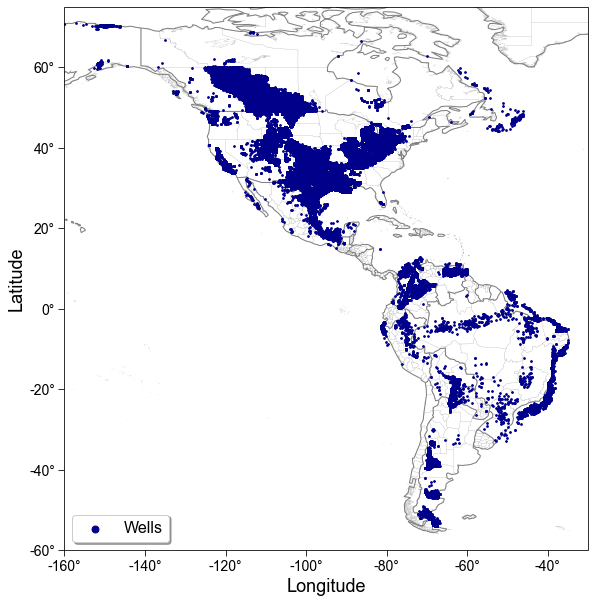

In [8]:
# Plot data on a map
save_path = "_results_fig_wells_.png"
fig_ = scatterMaps(
    wells_data2, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Wells",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [9]:
# Reset indices
wells_data3 = wells_data2.reset_index(drop=True)
wells_data3.head()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,SPUD_DATE,COMP_DATE,DRILL_TYPE,LATITUDE,LONGITUDE,geometry
0,1,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE.X-1,212,OIL,ACTIVE,COLHUE HUAPI S.A.,1996-10-30,1996-11-13,N/A,-45.59113,-68.28785,POINT (-68.28785 -45.59113)
1,2,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE.X-2,213,WATER INJECTION,ACTIVE,COLHUE HUAPI S.A.,1996-10-14,1996-11-13,N/A,-45.59202,-68.29202,POINT (-68.29202 -45.59202)
2,3,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-3,214,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-01-30,1997-02-07,N/A,-45.59024,-68.28388,POINT (-68.28388 -45.59024)
3,4,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-4,215,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-01-13,1997-01-20,N/A,-45.59407,-68.28948,POINT (-68.28948 -45.59407)
4,5,OIL AND NATURAL GAS WELLS,ARGENTINA,CHUBUT,105,2022-03-21,N/A,CH.CH.EALE-5,216,OIL,ACTIVE,COLHUE HUAPI S.A.,1997-02-16,1997-02-24,N/A,-45.59445,-68.29448,POINT (-68.29448 -45.59445)


In [10]:
# Write to GeoPackage
# ==============================
wells_data3.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Wells", driver="GPKG", encoding="utf-8")

# Write to GeoJSON
wells_data3.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Oil_Natural_Gas_Wells.geojson", driver="GeoJSON", encoding="utf-8")

# Offshore Platforms

In [11]:
from tqdm import tqdm

plts_ = glob.glob(os.getcwd() + "\\*platform*.geojson")
platform_data_ = read_data_(plts_)
print("Total # of records = ", platform_data_.shape[0])

Total # of records =  7524


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry
0,4147879,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,CARINA,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.75709,-67.21819000000001,POINT (-67.21819 -52.75709)
1,4147880,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,HIDRA CENTRO,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.83646,-68.1794,POINT (-68.17940 -52.83646)
2,4147881,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,VEGA PLEYADE,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-53.29892,-67.74476,POINT (-67.74476 -53.29892)
3,4147883,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,HIDRA NORTE,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.82053,-68.21963,POINT (-68.21963 -52.82053)
4,4147884,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,ARGO II,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.72776,-68.21388,POINT (-68.21388 -52.72776)


Total # of records =  7524


In [12]:
# Data quality checks
plat2 = data_quality_checks(platform_data_, starting_ogim_id=wells_data3.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████| 7524/7524 [00:00<00:00, 18973.38it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


7524it [00:01, 4547.00it/s]


0.---> OGIM_ID <----
array([2345537, 2345538, 2345539, ..., 2353058, 2353059, 2353060])
1.---> CATEGORY <----
array(['OFFSHORE PLATFORMS', 'OFFSHORE PRODUCTION PLATFORMS'],
      dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'MEXICO', 'UNITED STATES', 'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'GULF OF MEXICO', 'PACIFIC'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '101', '86', '132'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-07', '2022-04-11', '2016-05-03', '2016-05-02',
       '2017-01-01'], dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'OFFSHORE'], dtype=object)
7.---> FAC_NAME <----
array(['CARINA', 'HIDRA CENTRO', 'VEGA PLEYADE', ..., 'HIDALGO', 'N/A',
       'DRAGON'], dtype=object)
8.---> FAC_ID <----
array(['N/A', 'GOM00001', 'GOM00002', ..., '177', '180', '181'],
      dtype=object)
9.---> FAC_TYPE <----
array(['PLATFORM', 'DRILLING PLATFORM (TETRAPODE)',
       'DRILLING PLATFORM (TRIPOD)', 'DRILLING PLATFORM (OCTAPOD

In [13]:
# Check unique category
plat2.CATEGORY.unique()
plat2['CATEGORY'] = 'OFFSHORE PLATFORMS'

In [14]:
# Reset indices
plat3 = plat2.reset_index(drop=True)
plat3.head()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry
0,2345537,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,CARINA,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.75709,-67.21819,POINT (-67.21819 -52.75709)
1,2345538,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,HIDRA CENTRO,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.83646,-68.17940,POINT (-68.17940 -52.83646)
2,2345539,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,VEGA PLEYADE,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-53.29892,-67.74476,POINT (-67.74476 -53.29892)
3,2345540,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,HIDRA NORTE,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.82053,-68.21963,POINT (-68.21963 -52.82053)
4,2345541,OFFSHORE PLATFORMS,ARGENTINA,N/A,110,2022-05-07,N/A,ARGO II,N/A,PLATFORM,N/A,TOTAL AUSTRAL S.A.,1900-01-01,N/A,-52.72776,-68.21388,POINT (-68.21388 -52.72776)


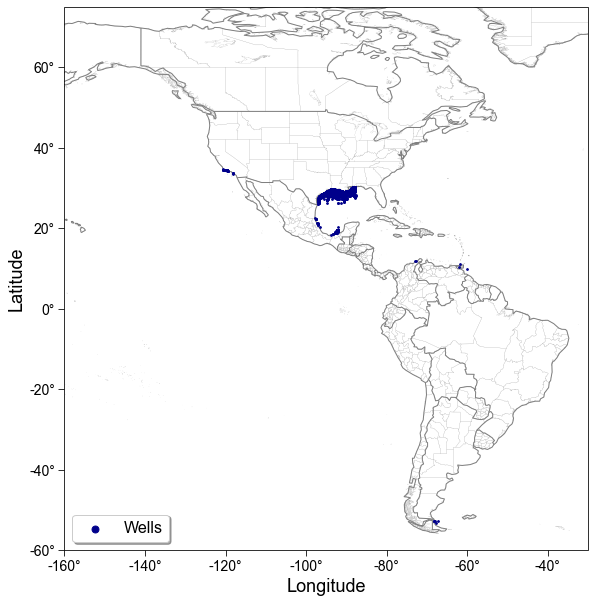

In [15]:
# Plot data on a map
save_path = "_results_fig_offshore_platforms_.png"
fig_ = scatterMaps(
    plat3, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Wells",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [16]:
# Write to GeoPackage
# ==============================
plat3.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Offshore_Platforms", driver="GPKG", encoding="utf-8")

# Write to GeoJSON
plat3.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Offshore_Platforms.geojson", driver="GeoJSON", encoding="utf-8")


# Natural gas compressor stations

In [17]:
# Read data
comps_ = glob.glob(os.getcwd() + "\\*compressor*.geojson")
comps_ = read_data_(comps_)

Total # of records =  14489


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
0,3912708,NATURAL GAS COMPRESSOR STATION,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA COMPRESORA,N/A,COMPRESSOR PLANT,...,-999,-999,-999,-999,-999,-999,-999,-36.95418,-69.60315,POINT (-69.60315 -36.95418)
1,3912723,NATURAL GAS COMPRESSOR STATION,ARGENTINA,N/A,110,2022-05-07,N/A,BAT-CL-604-14-1,N/A,COMPRESSOR PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.6546,-67.34103,POINT (-67.34103 -46.65460)
2,3912737,NATURAL GAS COMPRESSOR STATION,ARGENTINA,N/A,110,2022-05-07,N/A,VALLE HERMOSO 02,N/A,COMPRESSOR PLANT,...,-999,-999,-999,-999,-999,-999,-999,-45.78473,-68.53339,POINT (-68.53339 -45.78473)
3,3912740,NATURAL GAS COMPRESSOR STATION,ARGENTINA,N/A,110,2022-05-07,N/A,BAT-CM-171-14-1,N/A,COMPRESSOR PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.71827,-67.78238,POINT (-67.78238 -46.71827)
4,3912741,NATURAL GAS COMPRESSOR STATION,ARGENTINA,N/A,110,2022-05-07,N/A,BAT-CM-101-14-1,N/A,COMPRESSOR PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.74401,-67.61472999999999,POINT (-67.61473 -46.74401)


In [18]:
# Data quality checks
compA = data_quality_checks(comps_, starting_ogim_id=plat3.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████████| 14489/14489 [00:00<00:00, 19315.36it/s]

Number of features with INVALID geometries =  1


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
32,2092850,NATURAL GAS COMPRESSOR STATIONS,CANADA,SASKATCHEWAN,"40,41,42,43",2022-03-28,ONSHORE,N/A,SK FI 00000755,GAS COMPRESSION FACILITY,...,-999.0,-999.0,15.9,-999.0,-999,-999,-999.0,NaN,NaN,None


!!!There are INVALID geometries in dataset!!! 
 ===>Removing INVALID records <===
Now, standardizing `LATITUDE` and `LONGITUDE` columns


14488it [00:03, 4681.44it/s]


0.---> OGIM_ID <----
array([2353061, 2353062, 2353063, ..., 2367546, 2367547, 2367548])
1.---> CATEGORY <----
array(['NATURAL GAS COMPRESSOR STATION',
       'NATURAL GAS COMPRESSOR STATIONS'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'BRAZIL', 'CANADA', 'MEXICO',
       'UNITED STATES', 'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'SASKATCHEWAN',
       'PENNSYLVANIA', 'GEORGIA', 'KANSAS', 'COLORADO', 'WYOMING',
       'MISSOURI', 'TEXAS', 'NEBRASKA', 'ARIZONA', 'UTAH', 'ARKANSAS',
       'LOUISIANA', 'IOWA', 'WEST VIRGINIA', 'OKLAHOMA', 'IDAHO',
       'WISCONSIN', ' WASHINGTON', 'MONTANA', 'FLORIDA', 'NEW YORK',
       'OREGON', 'INDIANA', 'MARYLAND', 'KENTUCKY', 'MICHIGAN',
       'NORTH DAKOTA', 'ALABAMA', 'NEW MEXICO', 'TENNESSEE', 'ILLINOIS',
       'MISSISSIPPI', 'OHIO', 'MAINE', 'NEW JERSEY', 'SOUTH CAROLINA',
       'NOT APPLICABLE', 'MINNESOTA', 'VIRGINIA', 'NEVADA',
       'RHODE ISLAND', 'MASSACHU

<GeometryArray>
 ...
Length: 14204, dtype: geometry


In [19]:
compA.LIQ_THROUGHPUT_BPD.unique() # Drop this column
comps7 = compA.drop(columns='LIQ_THROUGHPUT_BPD')

In [20]:
# Check number of compressor units
comps7['NUM_COMPR_UNITS'].unique()

array([-999,    1,    6,   18,    5,    9,    2,   12,    3,   10,    7,
          4,   13,   11,    8,   14,    0,   17,   15,   21,   22,   16,
         23,   30,   20], dtype=int64)

In [21]:
# Number of storage tanks
comps7['NUM_STORAGE_TANKS'].unique() # Drop this column as there are no data
comps8 = comps7.drop(columns='NUM_STORAGE_TANKS')

In [22]:
# Reset indices
comps9 = comps8.reset_index(drop=True)

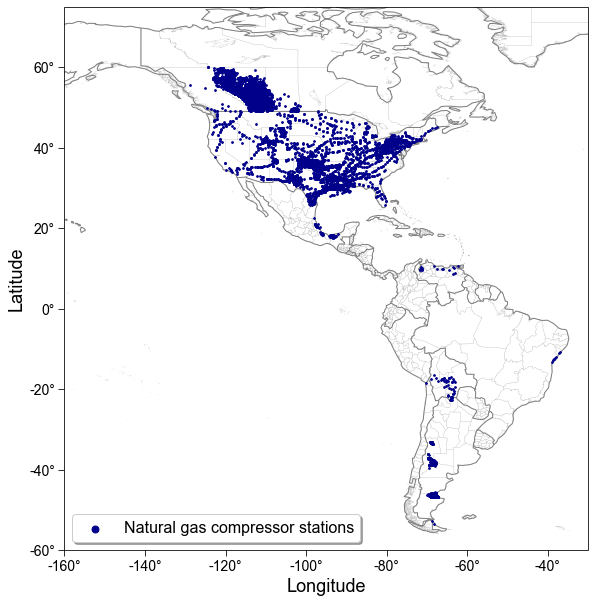

In [23]:
# Preview
save_path = "_results_fig_compressor_stations_.png"
fig_ = scatterMaps(
    comps9, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Natural gas compressor stations",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [24]:
# Check CATEGORY
comps9.CATEGORY.unique()
comps9['CATEGORY'] = 'NATURAL GAS COMPRESSOR STATIONS'

In [25]:
# Fix operator names ARG
dict_names = {
    'COMPAÃ\x91Ã\x8dAS ASOCIADAS PETROLERAS S.A.': 'COMPANIAS ASOCIADAS PETROLERAS S.A.',
    'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.': 'YSUR ENERGIA ARGENTINA S.R.L.',
    }
comps9 = replace_row_names(comps9, colName="OPERATOR", dict_names=dict_names)

Original list of unique attributes =  ['SAN JORGE PETROLEUM S.A.'
 'SINOPEC ARGENTINA EXPLORATION AND PRODUCTION, INC.'
 'PAN AMERICAN ENERGY SL' 'PLUSPETROL ENERGY S.A.' 'PLUSPETROL S.A.'
 'VISTA OIL & GAS ARGENTINA SAU' 'MADALENA ENERGY ARGENTINA SRL'
 'TECPETROL S.A.' 'ROCH S.A.' 'PETROQUIMICA COMODORO RIVADAVIA S.A.'
 'YPF S.A.' 'PETROLEOS SUDAMERICANOS S.A.' 'PETROLERA ENTRE LOMAS S.A.'
 'COMPAÃ\x91Ã\x8dAS ASOCIADAS PETROLERAS S.A.'
 'PAN AMERICAN ENERGY (SUCURSAL ARGENTINA) LLC' 'CAPEX S.A.'
 'ENAP SIPETROL ARGENTINA S.A.'
 'APCO OIL AND GAS INTERNATIONAL INC (SUCURSAL ARGENTINA)'
 'VISTA OIL & GAS ARGENTINA SA' 'OILSTONE ENERGIA S.A.' 'MEDANITO S.A.'
 'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.' 'PETROBRAS ARGENTINA S.A.'
 'PETROLERA PIEDRA DEL AGUILA S.A.' 'N/A' 'PETROBAS'
 'QUESTFIRE ENERGY CORP.' 'PINE CLIFF ENERGY LTD.'
 'CANADIAN NATURAL RESOURCES LIMITED' 'OBSIDIAN ENERGY LTD.'
 'ALPHABOW ENERGY LTD.' 'BAYTEX ENERGY LTD.' 'PARAMOUNT RESOURCES LTD.'
 'CITY OF MEDICINE HAT' 'ROZSA PE

In [26]:
# Write to GeoPackage
# ==============================
comps9.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Natural_Gas_Compressor_Stations", driver="GPKG", encoding="utf-8")

# GeoJSON
comps9.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Natural_Gas_Compressor_Stations.geojson", driver="GeoJSON", encoding="utf-8")


# Natural gas processing facility

In [27]:
# Read data
# Currently, natural gas processing facilities are grouped with other gathering and processing facilities
# We need to extract only the data for natural gas processing facilities

proc_ = glob.glob(os.getcwd() + "\\*gathering*.geojson")
gath_proc = read_data_(proc_)

Total # of records =  10100


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
0,4068160,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTG-CS-MEDANITO,N/A,GAS TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.55,-67.62954000000001,POINT (-67.62954 -46.55000)
1,4068173,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO DE CRUDO,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-36.92462,-69.58985,POINT (-69.58985 -36.92462)
2,4068324,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,VANSON,N/A,GAS TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-22.7088,-64.10617999999999,POINT (-64.10618 -22.70880)
3,4068327,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,ESP,N/A,GAS SEPARATION PLANT,...,-999,-999,-999,-999,-999,-999,-999,-22.74566,-64.12273999999999,POINT (-64.12274 -22.74566)
4,4068341,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTA.GAS,N/A,GAS TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-38.25651,-68.40163,POINT (-68.40163 -38.25651)


In [28]:
# Drop FAC_TYPE == 'OIL AND GAS FIELD'
try:
    gath_proc = gath_proc.query("FAC_TYPE != 'OIL AND GAS FIELD'")
except:
    pass

In [29]:
# Check CATEGORY
gath_proc.CATEGORY.unique()

array(['GATHERING AND PROCESSING'], dtype=object)

In [30]:
# Facility types for natural gas processing facilities

proc_list = [
    'GAS TREATMENT PLANT',
    'GAS SWEETENING PLANT',
    'GAS PLANT SULPHUR RECOVERY',
    'GAS SEPARATION PLANT',
    'GAS CONDITIONING PLANT', 
    'DEHYDRATING PLANT',
    'DEHYDRATION PLANT',
    'PROCESSING PLANT', 
    'PROCESSING FACILITY',
    'GAS SWEETENING PLANT'
    'GAS PLANT SULPHUR RECOVERY',
    'GAS PLANT ACID GAS FLARING < 1 T/D SULPHUR',
    'GAS PLANT SWEET',
    'GAS PLANT ACID GAS FLARING > 1 T/D SULPHUR',
    'GAS PLANT ACID GAS INJECTION',
    'GAS PLANT FRACTIONATION',
    'GAS PLANT MAINLINE STRADDLE',
    'GAS PROCESSING PLANT',
    'NGL FRACTIONATION FACILITY',
    'GAS PROCESSING COMPLEX',
    'NATURAL GAS PROCESSING COMPLEX',
    'NATURAL GAS PROCESSING PLANT AND NATURAL GAS LIQUIDS STORAGE',
    'NATURAL GAS PROCESSING PLANT',
    'NATURAL GAS LIQUIDS STORAGE',
    'NATURAL GAS LIQUIDS EXTRACTION PLANT',
    'NATURAL GAS LIQUIDS EXTRACTION PLANT',
    'NATURAL GAS PROCESSING AND NATURAL GAS LIQUIDS EXTRACTION PLANT',
    'NATURAL GAS PROCESSING PLANT AND PROPANE STORAGE',
    'DEW POINT CONTROL AND NATURAL GAS PROCESSING PLANT',
    'NATURAL GAS LIQUIDS EXTRACTION AND PROCESSING PLANT',
    'SYNTHETIC (NAPHTHA) NATURAL GAS PLANT',
    'NATURAL GAS LIQUIDS EXTRACTION AND FRACTIONATION PLANT',
    'NATURAL GAS LIQUIDS EXTRACTION PLANT AND STORAGE',
    'NATURAL GAS LIQUIDS STORAGE AND LOADOUT',
    'SOUR NATURAL GAS PROCESSING PLANT',
    'CRYOGENIC NATURAL GAS PROCESSING PLANT',
    'HP RECEIVER AND NATURAL GAS PROCESSING PLANT',
    'NATURAL GAS PROCESSING AND CO2 RECOVERY PLANT',
    'NATURAL GAS PLANT - 1 PROCESS',
    'NATURAL GAS LIQUIDS EXTRACTION PLANT, PIPELINE TRANSPORTATION OF NATURAL GAS',
    'CRUDE PETROLEUM AND NATURAL GAS EXTRACTION, NATURAL GAS LIQUIDS EXTRACTION PLANT',
    'CRUDE PETROLEUM AND NATURAL GAS EXTRACTION PLANT',
    'NATURAL GAS PROCESSING PLANT AND SURGE TANKS',
    'NATURAL GAS PROCESSING PLANT AND COMPRESSOR STATION',
    'NATURAL GAS PROCESSING PLANT AND NATURAL GASOLINE STORAGE',
    'ONSHORE PROCESSING, TREATMENT, AND TRANSFER FACILITY',
    'GAS PROCESSING PLANT (DESINCORPORATION)',
    'FRACTIONATION PLANT', 
    'FRACTIONATION PLANT (FUTURE PROJECT)',
    'GAS PROCESSING PLANT (FUTURE PROJECT)',
    'N/A'
    ]

In [31]:
# Data quality checks
procA = gath_proc.query("FAC_TYPE == @proc_list")
procB = data_quality_checks(procA, starting_ogim_id=comps9.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████| 2292/2292 [00:00<00:00, 18406.11it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


2292it [00:00, 4553.31it/s]


0.---> OGIM_ID <----
array([2367549, 2367550, 2367551, ..., 2369838, 2369839, 2369840])
1.---> CATEGORY <----
array(['GATHERING AND PROCESSING'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'BRAZIL', 'CANADA', 'MEXICO',
       'UNITED STATES', 'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'SASKATCHEWAN', 'ALABAMA',
       'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'FLORIDA', 'HAWAII',
       'ILLINOIS', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MICHIGAN',
       'MISSISSIPPI', 'MONTANA', 'NEW MEXICO', 'NORTH DAKOTA', 'OHIO',
       'OKLAHOMA', 'PENNSYLVANIA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'WEST VIRGINIA', 'WYOMING'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '122', '127', '3,4,5,6,7,8', '26, 27', '40,41,42,43', '101',
       '91', '132'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-07', '2017-09-13', '2022-05-15', '2022-04-11',
       '2022-03-08', '2022-03-28', '2014-01-08', '2019-01-01',
       '20

In [32]:
# Fix operator names
dict_names = {
    'COMPAÃ\x91Ã\x8dAS ASOCIADAS PETROLERAS S.A.': 'COMPANIAS ASOCIADAS PETROLERAS S.A.',
    'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.': 'YSUR ENERGIA ARGENTINA S.R.L.',
    }
procC = replace_row_names(procB, colName="OPERATOR", dict_names=dict_names)

Original list of unique attributes =  ['YPF S.A.' 'PLUSPETROL ENERGY S.A.' 'PLUSPETROL S.A.'
 'TOTAL AUSTRAL S.A.' 'VISTA OIL & GAS ARGENTINA SAU'
 'EXXONMOBIL EXPLORATION ARGENTINA S.R.L.' 'PRESIDENT PETROLEUM S.A.'
 'TECPETROL S.A.' 'ROCH S.A.' 'PETROQUIMICA COMODORO RIVADAVIA S.A.'
 'CHEVRON ARGENTINA S.R.L.' 'PETROBRAS ARGENTINA S.A.'
 'CENTRAL INTERNATIONAL CORPORATION (SUCURSAL ARGENTINA)'
 'PETROLERA DEL COMAHUE S.A.' 'ENERGIAL S.A.' 'PETROLERA ENTRE LOMAS S.A.'
 'PETROFARO S.A.' 'PAN AMERICAN ENERGY (SUCURSAL ARGENTINA) LLC'
 'APACHE ENERGIA ARGENTINA S.R.L.'
 'COMPAÃ\x91Ã\x8dA GENERAL DE COMBUSTIBLES S.A.' 'PAN AMERICAN ENERGY SL'
 'CAPEX S.A.' 'PETROLEOS SUDAMERICANOS S.A.' 'SHELL ARGENTINA S.A.'
 'O&G DEVELOPMENTS LTD S.A.' 'VISTA OIL & GAS ARGENTINA SA'
 'OILSTONE ENERGIA S.A.' 'PETROLERA LF COMPANY S.R.L.'
 'AMERICAS PETROGAS ARGENTINA S.A.' 'MEDANITO S.A.'
 'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.' 'GAS Y PETROLEO DEL NEUQUEN S.A.'
 'SAN JORGE PETROLEUM S.A.' 'PETRO AP S.A.' 'P

In [33]:
# Drop commodity AND OTHER N/As columns
procD = procC.drop(columns=['COMMODITY', 'LIQ_THROUGHPUT_BPD', 'NUM_COMPR_UNITS', 'NUM_STORAGE_TANKS', 'SITE_HP'])

In [34]:
# Rename facility category
procD['CATEGORY'] = "NATURAL GAS PROCESSING FACILITIES"

# Reset index
procE = procD.reset_index(drop=True)
procE.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,LIQ_CAPACITY_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
2287,2369836,NATURAL GAS PROCESSING FACILITIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,156,GAS PROCESSING PLANT,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,9.12915,-64.72702,POINT (-64.72702 9.12915)
2288,2369837,NATURAL GAS PROCESSING FACILITIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,157,GAS PROCESSING PLANT,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,9.17198,-64.57711,POINT (-64.57711 9.17198)
2289,2369838,NATURAL GAS PROCESSING FACILITIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,162,GAS PROCESSING PLANT,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,9.65403,-63.76185,POINT (-63.76185 9.65403)
2290,2369839,NATURAL GAS PROCESSING FACILITIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,165,GAS PROCESSING PLANT,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,9.88617,-63.37321,POINT (-63.37321 9.88617)
2291,2369840,NATURAL GAS PROCESSING FACILITIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,167,FRACTIONATION PLANT,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,10.34665,-71.89877,POINT (-71.89877 10.34665)


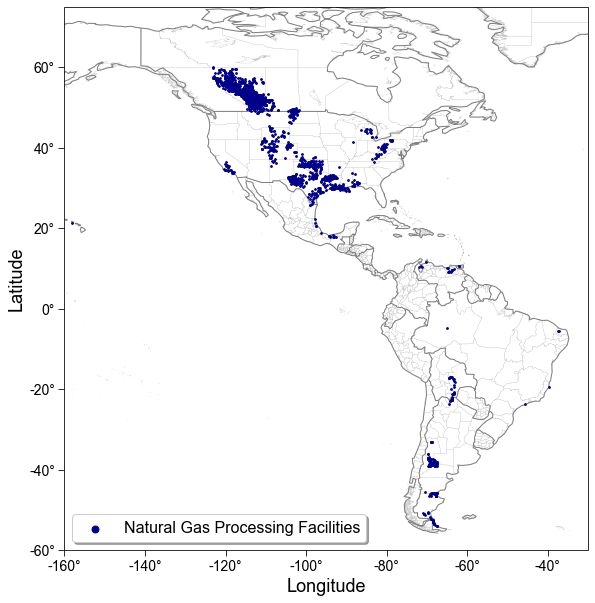

In [35]:
# Preview
save_path = "results\\OGIM_NA_SA_v1.2\\GeoPackage\\_results_fig_processing_facility.png"
fig_ = scatterMaps(
    procE, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Natural Gas Processing Facilities",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [36]:
# Write to GeoPackage
# ==============================
procE.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Natural_Gas_Processing_Facilities", driver="GPKG", encoding="utf-8")

# GeoJSON
procE.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\Natural_Gas_Processing_Facilities.geojson", driver="GeoJSON", encoding="utf-8")


# Oil and gas gathering facilities
 - These include central gathering and tank batteries facilities, which gather oil and gas from producing wells, and primarily separates these products into oil, gas, water, etc.
 - Note: facilities may be collocated with wells

In [37]:
gath2 = gath_proc.query("FAC_TYPE != @proc_list")
gath2.head()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
1,4068173,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO DE CRUDO,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-36.92462,-69.58985,POINT (-69.58985 -36.92462)
8,4068476,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTC,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-38.91451,-68.18098999999999,POINT (-68.18099 -38.91451)
13,4068631,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTC-ECN,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-37.46226,-68.31022,POINT (-68.31022 -37.46226)
19,4068926,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO CRUDO JCP,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-37.39969,-68.45056,POINT (-68.45056 -37.39969)
22,4069208,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO DE CRUDO DOS PUNTITAS,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-24.11435,-63.98832,POINT (-63.98832 -24.11435)


In [38]:
gath2.FAC_TYPE.unique()

array(['OIL TREATMENT PLANT', 'NATURAL GAS GATHERING FACILITY',
       'CUSTOM TREATING FACILITY',
       'CUSTOM TREATING FACILITY (APPROVED AS PART OF A WASTE PLANT)',
       'GAS GATHERING SYSTEM',
       'GGS (PIPES ONLY OR COMPRESSOR < 75KW. ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
       'OIL SANDS PROCESSING PLANT', 'OIL AND GAS FACILITY',
       'CUSTOM TREATING PLANT', 'GAS GATHERING STATION',
       'GATHERING STATION', 'GAS AND CONDENSATE GATHERING STATION',
       'OIL GATHERING STATION', 'GATHERING MODULE',
       'GAS GATHERING MODULE', 'GATHERING AND SEPARATION STATION',
       'MODULAR GATHERING STATION', 'GATHERING AND CONDITIONING STATION',
       'CRUDE IMPROVEMENT COMPLEX (FUTURE PROJECT)',
       'CRUDE IMPROVEMENT COMPLEX', 'COLLECTION STATION'], dtype=object)

In [39]:
# Also look at tank batteries dataset
bat_ = glob.glob(os.getcwd() + "\\*batter*.geojson")
bat1 = read_data_(bat_)

Total # of records =  104205


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry
0,683290,TANK BATTERIES,CANADA,ALBERTA,"3,4",2022-04-11,ONSHORE,MORGAN PROVOST 14-29,ABBT0040162,CRUDE OIL SINGLE-WELL BATTERY,...,1994-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,52.30159,-110.97142,POINT (-110.97142 52.30159)
1,683291,TANK BATTERIES,CANADA,ALBERTA,"3,4",2022-04-11,ONSHORE,HALVAR WAINWRIGHT 16-13,ABBT0040248,CRUDE OIL MULTIWELL PRORATION BATTERY,...,1994-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,52.88533,-110.73283,POINT (-110.73283 52.88533)
2,683292,TANK BATTERIES,CANADA,ALBERTA,"3,4",2022-04-11,ONSHORE,BRAZEAU RIVER 16-35 BATTERY 'C',ABBT0040297,CRUDE OIL MULTIWELL PRORATION BATTERY,...,1994-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,53.1905,-115.6363,POINT (-115.63630 53.19050)
3,683293,TANK BATTERIES,CANADA,ALBERTA,"3,4",2022-04-11,ONSHORE,BRAZEAU RIVER 16-35 BATTERY 'B',ABBT0040298,CRUDE OIL MULTIWELL PRORATION BATTERY,...,1994-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,53.1905,-115.6354,POINT (-115.63540 53.19050)
4,683294,TANK BATTERIES,CANADA,ALBERTA,"3,4",2022-04-11,ONSHORE,CIMARRON WINDFALL 1-7,ABBT0040347,CRUDE OIL SINGLE-WELL BATTERY,...,1994-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,54.08134,-116.22928,POINT (-116.22928 54.08134)


In [40]:
# Look at facility types
bat1.FAC_TYPE.unique()

array(['CRUDE OIL SINGLE-WELL BATTERY',
       'CRUDE OIL MULTIWELL PRORATION BATTERY',
       'GAS MULTIWELL GROUP BATTERY',
       'GAS MULTIWELL EFFLUENT MEASUREMENT BATTERY',
       'GAS SINGLE-WELL BATTERY', 'CRUDE OIL MULTIWELL GROUP BATTERY',
       'CRUDE BITUMEN/HEAVY OIL ADMINISTRATIVE GROUPING',
       'GAS MULTIWELL PRORATION SE ALBERTA BATTERY',
       'CRUDE BITUMEN SINGLE-WELL BATTERY',
       'CRUDE BITUMEN MULTIWELL PRORATION BATTERY',
       'CRUDE BITUMEN MULTIWELL GROUP BATTERY', 'GAS TEST BATTERY',
       'IN-SITU OIL SANDS BATTERY',
       'GAS MULTIWELL PRORATION OUTSIDE SE ALBERTA BATTERY',
       'GAS MULTIWELL PRORATION SE AB BATTERY (ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
       'SULPHUR REPORTING AT OIL SANDS', 'WATER SOURCE BATTERY',
       'DRILLING AND COMPLETING',
       'A FACILITY TYPE THAT CONSISTS OF BRINE PRODUCTION WELLS AND POSSIBLE WATER\xa0SOURCE LOCATIONS REGULATE',
       'GAS MULTIWELL GROUP BATTERY (ISSUED BY ERCB ONLY) NO LICENSE 

In [41]:
# Gathering facilities here include the battery plants in Canada
# A system or arrangement of tanks or other surface equipment receiving flow-lined production from one or more wells. 
# Batteries must provide for measurement and disposition of production and may
# • include equipment for separating production into oil, gas, and water,
# • include storage equipment for produced liquids before disposition, and
# • receive product from other facilities.

gath_list = [
    'CRUDE OIL SINGLE-WELL BATTERY',
    'CRUDE OIL MULTIWELL PRORATION BATTERY',
    'GAS MULTIWELL GROUP BATTERY',
    'GAS MULTIWELL EFFLUENT MEASUREMENT BATTERY',
    'GAS SINGLE-WELL BATTERY', 'CRUDE OIL MULTIWELL GROUP BATTERY',
    'CRUDE BITUMEN/HEAVY OIL ADMINISTRATIVE GROUPING',
    'GAS MULTIWELL PRORATION SE ALBERTA BATTERY',
    'CRUDE BITUMEN SINGLE-WELL BATTERY',
    'CRUDE BITUMEN MULTIWELL PRORATION BATTERY',
    'CRUDE BITUMEN MULTIWELL GROUP BATTERY', 
    'GAS TEST BATTERY',
    'IN-SITU OIL SANDS BATTERY',
    'GAS MULTIWELL PRORATION OUTSIDE SE ALBERTA BATTERY',
    'GAS MULTIWELL PRORATION SE AB BATTERY (ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
    'GAS MULTIWELL GROUP BATTERY (ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
    'GAS MULTIWELL PRORATION OUTSIDE SE AB (ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
    'BATTERY SITE', 
    'SATELLITE BATTERY', 
    'PROCESSING BATTERY',
    'BATTERY',
    'MULTI WELL OIL BATTERY', 
    'MULTI WELL GAS BATTERY',
    'MULTI WELL SWABBING OIL BATTERY', 
    'SEPARATION BATTERY',
    'OIL SEPARATION BATTERY',
    'DRILLING AND COMPLETING',
    'SULPHUR REPORTING AT OIL SANDS'
    ]

# Extract data
bat2 = bat1.query("FAC_TYPE == @gath_list")

In [42]:
# Concatenate results
bat3 = pd.concat([gath2, bat2]).reset_index(drop=True)
bat3.head()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
0,4068173,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO DE CRUDO,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-36.92462,-69.58985,POINT (-69.58985 -36.92462)
1,4068476,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTC,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-38.91451,-68.18098999999999,POINT (-68.18099 -38.91451)
2,4068631,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PTC-ECN,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-37.46226,-68.31022,POINT (-68.31022 -37.46226)
3,4068926,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO CRUDO JCP,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-37.39969,-68.45056,POINT (-68.45056 -37.39969)
4,4069208,GATHERING AND PROCESSING,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA TRATAMIENTO DE CRUDO DOS PUNTITAS,N/A,OIL TREATMENT PLANT,...,-999,-999,-999,-999,-999,-999,-999,-24.11435,-63.98832,POINT (-63.98832 -24.11435)


In [43]:
# Check unique facility types
bat3.FAC_TYPE.unique()

array(['OIL TREATMENT PLANT', 'NATURAL GAS GATHERING FACILITY',
       'CUSTOM TREATING FACILITY',
       'CUSTOM TREATING FACILITY (APPROVED AS PART OF A WASTE PLANT)',
       'GAS GATHERING SYSTEM',
       'GGS (PIPES ONLY OR COMPRESSOR < 75KW. ISSUED BY ERCB ONLY) NO LICENSE REQUIRED (NLR)',
       'OIL SANDS PROCESSING PLANT', 'OIL AND GAS FACILITY',
       'CUSTOM TREATING PLANT', 'GAS GATHERING STATION',
       'GATHERING STATION', 'GAS AND CONDENSATE GATHERING STATION',
       'OIL GATHERING STATION', 'GATHERING MODULE',
       'GAS GATHERING MODULE', 'GATHERING AND SEPARATION STATION',
       'MODULAR GATHERING STATION', 'GATHERING AND CONDITIONING STATION',
       'CRUDE IMPROVEMENT COMPLEX (FUTURE PROJECT)',
       'CRUDE IMPROVEMENT COMPLEX', 'COLLECTION STATION',
       'CRUDE OIL SINGLE-WELL BATTERY',
       'CRUDE OIL MULTIWELL PRORATION BATTERY',
       'GAS MULTIWELL GROUP BATTERY',
       'GAS MULTIWELL EFFLUENT MEASUREMENT BATTERY',
       'GAS SINGLE-WELL BATTERY', '

In [44]:
# Rename facility category
bat3['CATEGORY'] = "OIL AND NATURAL GAS GATHERING FACILITIES"

In [45]:
# Data quality checks
bat4 = data_quality_checks(bat3, starting_ogim_id=procE.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████| 108770/108770 [00:05<00:00, 19344.94it/s]

Number of features with INVALID geometries =  2


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
105690,2160408,OIL AND NATURAL GAS GATHERING FACILITIES,CANADA,MANITOBA,52,2022-03-28,ONSHORE,TUNDRA WASKADA 1-20-1-25HZ,MBBT2300043,BATTERY,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,NaN,NaN,None
105727,2160445,OIL AND NATURAL GAS GATHERING FACILITIES,CANADA,MANITOBA,52,2022-03-28,ONSHORE,WASKADA HZNTL A01-20-01-25H3,MBBT2300085,BATTERY,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,NaN,NaN,None


!!!There are INVALID geometries in dataset!!! 
 ===>Removing INVALID records <===
Now, standardizing `LATITUDE` and `LONGITUDE` columns


108768it [00:23, 4597.59it/s]


0.---> OGIM_ID <----
array([2369841, 2369842, 2369843, ..., 2478606, 2478607, 2478608])
1.---> CATEGORY <----
array(['OIL AND NATURAL GAS GATHERING FACILITIES'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BRAZIL', 'CANADA', 'MEXICO', 'VENEZUELA'],
      dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'MANITOBA', 'ONTARIO', 'NEW BRUNSWICK',
       'NEWFOUNDLAND AND LABRADOR', 'NOVA SCOTIA', 'QUEBEC',
       'NORTHWEST TERRITORIES', 'NUNAVUT', 'SASKATCHEWAN',
       'BRITISH COLUMBIA'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '127', '3,4,5,6,7,8', '52', '61', '62', '67', '65', '69',
       '63', '71', '73', '40,41,42,43', '101', '132', '3,4', '26'],
      dtype=object)
5.---> SRC_DATE <----
array(['2022-05-07', '2022-05-15', '2022-04-11', '2022-03-28',
       '2022-01-01', '2022-03-29', '2017-01-01', '2022-03-08'],
      dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'ONSHORE'], dtype=object)
7.---> FAC_NAME <----
array(['PLANTA TRATAMIENTO D

<GeometryArray>
 ...
Length: 87813, dtype: geometry


In [46]:
# Drop commodity AND OTHER N/As columns
bat5 = bat4.drop(columns=['COMMODITY', 'LIQ_THROUGHPUT_BPD', 'NUM_STORAGE_TANKS', 'SITE_HP', 'NUM_COMPR_UNITS'])

In [47]:
# Reset indices
bat6 = bat5.reset_index(drop=True)

In [48]:
bat6.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,LIQ_CAPACITY_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
108763,2478604,OIL AND NATURAL GAS GATHERING FACILITIES,MEXICO,N/A,101,2022-04-11,N/A,BATERIA DE SEPARACION GRAVERA,N/A,SEPARATION BATTERY,N/A,N/A,1900-01-01,-999.0,-999.0,-999.0,17.88120,-94.10314,POINT (-94.10314 17.88120)
108764,2478605,OIL AND NATURAL GAS GATHERING FACILITIES,MEXICO,N/A,101,2022-04-11,N/A,BATERIA DE SEPARACION CONCEPCION,N/A,SEPARATION BATTERY,CLOSED,N/A,1900-01-01,-999.0,-999.0,-999.0,17.87107,-94.34337,POINT (-94.34337 17.87107)
108765,2478606,OIL AND NATURAL GAS GATHERING FACILITIES,MEXICO,N/A,101,2022-04-11,N/A,EX-BATERIA TONALA NORTE,N/A,BATTERY,DISMANTLED,N/A,1900-01-01,-999.0,-999.0,-999.0,17.92959,-94.10889,POINT (-94.10889 17.92959)
108766,2478607,OIL AND NATURAL GAS GATHERING FACILITIES,MEXICO,N/A,101,2022-04-11,N/A,BATERIA DE SEPARACION BARCODON 1,N/A,SEPARATION BATTERY,INACTIVE,N/A,1900-01-01,-999.0,-999.0,-999.0,22.57778,-97.96806,POINT (-97.96806 22.57778)
108767,2478608,OIL AND NATURAL GAS GATHERING FACILITIES,MEXICO,N/A,101,2022-04-11,N/A,PLANTA RECEPTORA EN TIERRA (ORF),N/A,OIL SEPARATION BATTERY,OPERATING,N/A,1900-01-01,-999.0,-999.0,-999.0,18.25946,-93.92028,POINT (-93.92028 18.25946)


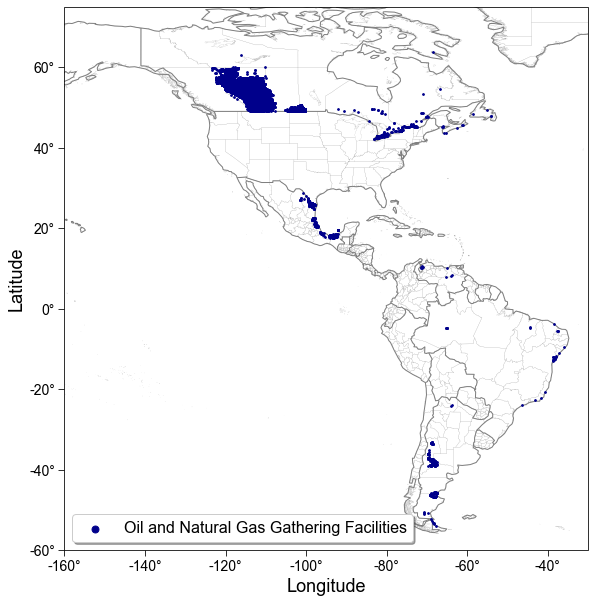

In [49]:
# Preview
save_path = "_results_fig_gathering_facility.png"
fig_ = scatterMaps(
    bat6, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Oil and Natural Gas Gathering Facilities",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [50]:
# Write to GeoPackage
# ==============================
bat6.to_file("results\OGIM_NA_SA_v1.2\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Gathering_Facilities", driver="GPKG", encoding="utf-8")

# GeoSJON
bat6.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Oil_Natural_Gas_Gathering_Facilities.geojson", driver="GeoJSON", encoding="utf-8")


# Stations - Other

In [51]:
# Read stations - Other data
# Includes metering and regulating stations, pumping stations etc
# May be collocated with other facilities

oth_ = glob.glob(os.getcwd() + "\\*stations_other*.geojson")
oth1 = read_data_(oth_)

Total # of records =  6553


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
0,3991670,STATIONS - OTHER,ARGENTINA,N/A,110,2022-05-07,N/A,PM-356_NEUBA,N/A,GASOLINE AND CONDENSATE MEASUREMENT POINT,...,-999,-999,-999,-999,-999,-999,-999,-38.73079,-68.74736,POINT (-68.74736 -38.73079)
1,3992524,STATIONS - OTHER,ARGENTINA,N/A,110,2022-05-07,N/A,PRG0PM16,N/A,REGULATORY PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.54051,-67.6161,POINT (-67.61610 -46.54051)
2,3993487,STATIONS - OTHER,ARGENTINA,N/A,110,2022-05-07,N/A,PRGPTD01,N/A,REGULATORY PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.75347,-68.09168,POINT (-68.09168 -46.75347)
3,3993986,STATIONS - OTHER,ARGENTINA,N/A,110,2022-05-07,N/A,PRGLPC11,N/A,REGULATORY PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.15275,-69.17733,POINT (-69.17733 -46.15275)
4,3994700,STATIONS - OTHER,ARGENTINA,N/A,110,2022-05-07,N/A,PRGECP01,N/A,REGULATORY PLANT,...,-999,-999,-999,-999,-999,-999,-999,-46.67963,-67.88908000000001,POINT (-67.88908 -46.67963)


In [52]:
# Check CATEGORY
oth1.CATEGORY.unique()

array(['STATIONS - OTHER'], dtype=object)

In [53]:
# Check facoility types
pprint.pprint(oth1.FAC_TYPE.unique())

array(['GASOLINE AND CONDENSATE MEASUREMENT POINT', 'REGULATORY PLANT',
       'LPG MEASUREMENT POINT', 'REGULATOR STATION', 'METER STATION',
       'PUMP STATION', 'METER REGULATOR STN.', 'HEATING STATION',
       'SATELLITE STATION', 'METERING STATION',
       'PETROLEUM, OIL, AND LUBRICANTS PUMPING STATION',
       'REPUMP STATION (FUTURE PROJECT)', 'VALVE STATIONS',
       'COMPRESSOR PLANT (FUTURE PROJECT)'], dtype=object)


In [54]:
# Exclude COMPRESSOR PLANT data for Venezuela, as this is already part of the natural gas compressor station dataset
try:
    oth2 = oth1.query("FAC_TYPE != 'COMPRESSOR PLANT (FUTURE PROJECT)'")
except:
    oth2 = oth1.copy()

In [55]:
# Data quality checks
oth3 = data_quality_checks(oth2, starting_ogim_id=bat6.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████| 6549/6549 [00:00<00:00, 17761.79it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


6549it [00:01, 4582.53it/s]


0.---> OGIM_ID <----
array([2478609, 2478610, 2478611, ..., 2485155, 2485156, 2485157])
1.---> CATEGORY <----
array(['STATIONS - OTHER'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'CANADA', 'MEXICO', 'UNITED STATES',
       'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS',
       'CALIFORNIA', 'COLORADO', 'FLORIDA', 'GEORGIA', 'HAWAII', 'IDAHO',
       'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'OKLAHOMA', 'KENTUCKY',
       'LOUISIANA', 'MAINE', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI',
       'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW MEXICO', 'TEXAS',
       'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OREGON',
       'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'TENNESSEE',
       'UTAH', ' WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING',
       'VIRGINIA', 'NEW JERSEY'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '123', '9', '101', '94', '132'], dtype=obje

In [56]:
# Drop unneeded columns
oth5 = oth3.drop(columns=['LIQ_CAPACITY_BPD', 'LIQ_THROUGHPUT_BPD', 'GAS_CAPACITY_MMCFD', 'GAS_THROUGHPUT_MMCFD', 'SITE_HP', 'NUM_COMPR_UNITS', 'NUM_STORAGE_TANKS'])

In [57]:
# Reset indices
oth6 = oth5.reset_index(drop=True)

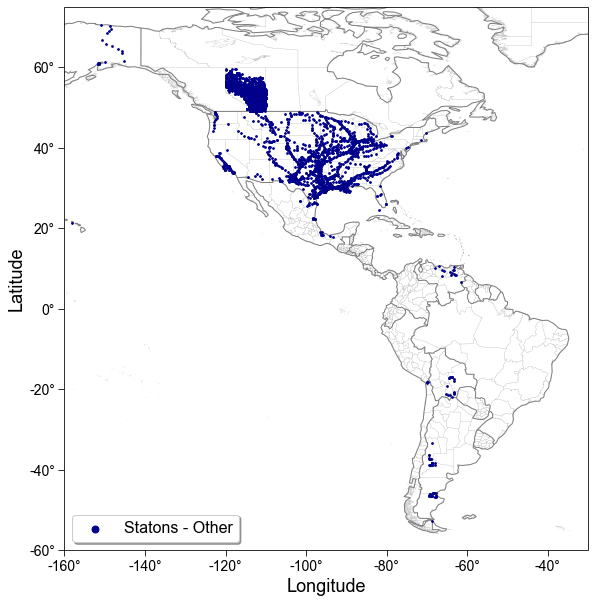

In [58]:
# Preview
save_path = "_results_fig_stations_other.png"
fig_ = scatterMaps(
    oth6, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=3,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Statons - Other",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [59]:
# Preview
oth6.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry
6544,2485153,STATIONS - OTHER,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,164,VALVE STATIONS,N/A,N/A,1900-01-01,N/A,9.73008,-63.45268,POINT (-63.45268 9.73008)
6545,2485154,STATIONS - OTHER,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,168,VALVE STATIONS,N/A,N/A,1900-01-01,N/A,8.10218,-66.12482,POINT (-66.12482 8.10218)
6546,2485155,STATIONS - OTHER,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,171,VALVE STATIONS,N/A,N/A,1900-01-01,N/A,8.43514,-62.91609,POINT (-62.91609 8.43514)
6547,2485156,STATIONS - OTHER,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,173,VALVE STATIONS,N/A,N/A,1900-01-01,N/A,8.27002,-62.74921,POINT (-62.74921 8.27002)
6548,2485157,STATIONS - OTHER,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,174,VALVE STATIONS,N/A,N/A,1900-01-01,N/A,6.62308,-61.56309,POINT (-61.56309 6.62308)


In [60]:
# Write to GeoPackage
# ==============================
oth6.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Stations_Other", driver="GPKG", encoding="utf-8")

# GeoJSON
oth6.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Stations_Other.geojson", driver="GeoJSON", encoding="utf-8")


# Petroleum terminals

In [61]:
# Extract TANK data from battery datasets
dat1_ = bat1.query("FAC_TYPE == ['PETROLEUM TANK', 'WATER TANK']")

In [62]:
# Petroleum terminals dataset
terms = glob.glob(os.getcwd() + "\\*terminal*.geojson")
terms1 = read_data_(terms)

Total # of records =  3287


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry
0,4306162,PETROLEUM TERMINALS,ARGENTINA,N/A,112,2017-05-04,N/A,GENOVA S/N / AVELLANEDA / BUENOS AIRES,30-54668997-9,DISPATCH TERMINAL,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-34.63928,-58.34022,POINT (-58.34022 -34.63928)
1,4306163,PETROLEUM TERMINALS,ARGENTINA,N/A,112,2017-05-04,N/A,AV. MOSCONI 600 / BARRANQUERAS / CHACO,30-54668997-9,DISPATCH TERMINAL,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-27.50092,-58.94209,POINT (-58.94209 -27.50092)
2,4306164,PETROLEUM TERMINALS,ARGENTINA,N/A,112,2017-05-04,N/A,RUTA 10 Y CALLE 128 / BERISSO / BUENOS AIRES,30-54668997-9,DISPATCH TERMINAL,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-34.9,-57.92178,POINT (-57.92178 -34.90000)
3,4306165,PETROLEUM TERMINALS,ARGENTINA,N/A,112,2017-05-04,N/A,WARNES S/N / COMODORO RIVADAVIA / CHUBUT,30-54668997-9,DISPATCH TERMINAL,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-45.84487,-67.46917000000001,POINT (-67.46917 -45.84487)
4,4306166,PETROLEUM TERMINALS,ARGENTINA,N/A,112,2017-05-04,N/A,INT. J.J. RIZZO 250 / CONCEPCION DEL URUGUAY /...,30-54668997-9Â,DISPATCH TERMINAL,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-32.48694,-58.22389,POINT (-58.22389 -32.48694)


In [63]:
# Combine the datasets
terms2 = pd.concat([dat1_, terms1]).reset_index(drop=True)

In [64]:
# Check CRS
terms2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
# CATEGORY
terms2['CATEGORY'] = "PETROLEUM TERMINALS"

In [66]:
# Data quality checks
terms3 = data_quality_checks(terms2, starting_ogim_id=oth6.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████| 6144/6144 [00:00<00:00, 18735.58it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


6144it [00:01, 4713.97it/s]


0.---> OGIM_ID <----
array([2485158, 2485159, 2485160, ..., 2491299, 2491300, 2491301])
1.---> CATEGORY <----
array(['PETROLEUM TERMINALS'], dtype=object)
2.---> COUNTRY <----
array(['CANADA', 'ARGENTINA', 'BRAZIL', 'MEXICO', 'UNITED STATES',
       'VENEZUELA'], dtype=object)
3.---> STATE_PROV <----
array(['ONTARIO', 'N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA',
       'SASKATCHEWAN', 'ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS',
       'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA',
       'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA',
       'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND',
       'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI',
       'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'RHODE ISLAND', 'SOUTH CAROLINA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'VERMONT', 'VIRG

In [67]:
# Drop unneeded columns
terms4 = terms3.drop(columns=['LIQ_THROUGHPUT_BPD', 'GAS_CAPACITY_MMCFD', 'NUM_STORAGE_TANKS'])

In [68]:
# Reset index
terms5 = terms4.reset_index(drop=True)
terms5.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
6139,2491297,PETROLEUM TERMINALS,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,128,SHIPPING TERMINAL,N/A,N/A,1900-01-01,N/A,-999.0,-999.0,10.47696,-66.04574,POINT (-66.04574 10.47696)
6140,2491298,PETROLEUM TERMINALS,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,129,SHIPPING TERMINAL,N/A,N/A,1900-01-01,N/A,-999.0,-999.0,10.15688,-65.35582,POINT (-65.35582 10.15688)
6141,2491299,PETROLEUM TERMINALS,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,134,SHIPPING TERMINAL,N/A,N/A,1900-01-01,N/A,-999.0,-999.0,10.27804,-64.91508,POINT (-64.91508 10.27804)
6142,2491300,PETROLEUM TERMINALS,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,172,SHIPPING TERMINAL,N/A,N/A,1900-01-01,N/A,-999.0,-999.0,8.36614,-62.66520,POINT (-62.66520 8.36614)
6143,2491301,PETROLEUM TERMINALS,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,179,SHIPPING TERMINAL,N/A,N/A,1900-01-01,N/A,-999.0,-999.0,11.78177,-70.33717,POINT (-70.33717 11.78177)


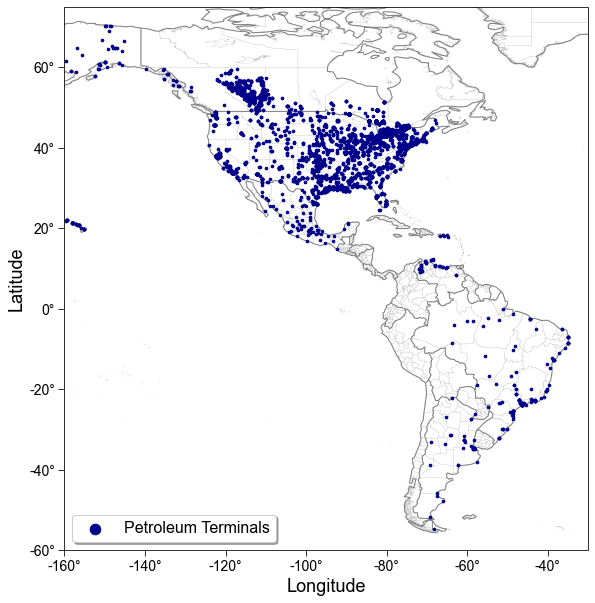

In [69]:
# Preview
save_path = "_results_fig_petroleum_terminals.png"
fig_ = scatterMaps(
    terms5, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=7,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Petroleum Terminals",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [70]:
# Write to GeoPackage
# ==============================
terms5.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Petroleum_Terminals", driver="GPKG", encoding="utf-8")

# GeoJSON
terms5.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Petroleum_Terminals.geojson", driver="GeoJSON", encoding="utf-8")


# Equipment and components
 - Includes locational info on valves, dehydrators, LACT units, collector units, etc, if available

In [71]:
# Equipment and components dataset
equip = glob.glob(os.getcwd() + "\\*equip*.geojson")
equip1 = read_data_(equip)

Total # of records =  62931


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry
0,4147895,EQUIPMENT AND COMPONENTS,ARGENTINA,N/A,110,2022-05-07,N/A,VA-RN.X-1008-001,N/A,VALVE,N/A,AMERICAS PETROGAS ARGENTINA S.A.,1900-01-01,N/A,-38.19849,-67.45072,POINT (-67.45072 -38.19849)
1,4147904,EQUIPMENT AND COMPONENTS,ARGENTINA,N/A,110,2022-05-07,N/A,VA-PC-2105-005-1,N/A,VALVE,N/A,"SINOPEC ARGENTINA EXPLORATION AND PRODUCTION, ...",1900-01-01,N/A,-46.53036,-68.73272,POINT (-68.73272 -46.53036)
2,4147909,EQUIPMENT AND COMPONENTS,ARGENTINA,N/A,110,2022-05-07,N/A,SCRAPPER,N/A,SCRAPPER,N/A,SAN JORGE PETROLEUM S.A.,1900-01-01,N/A,-36.89578,-69.4704,POINT (-69.47040 -36.89578)
3,4147910,EQUIPMENT AND COMPONENTS,ARGENTINA,N/A,110,2022-05-07,N/A,VA-RN.X-1008-009,N/A,VALVE,N/A,AMERICAS PETROGAS ARGENTINA S.A.,1900-01-01,N/A,-38.19849,-67.45072,POINT (-67.45072 -38.19849)
4,4147914,EQUIPMENT AND COMPONENTS,ARGENTINA,N/A,110,2022-05-07,N/A,SCRAPPER,N/A,SCRAPPER,N/A,SAN JORGE PETROLEUM S.A.,1900-01-01,N/A,-36.92531,-69.58972,POINT (-69.58972 -36.92531)


In [72]:
# Check facility category
equip1.CATEGORY.unique()
equip1['CATEGORY'] = "EQUIPMENT AND COMPONENTS"

In [73]:
# Check facility types
equip1.FAC_TYPE.unique()

array(['VALVE', 'SCRAPPER', 'CRUDE OIL COLLECTOR', 'GAS MANIFOLD',
       'WATER COLLECTOR', 'BLOCK VALVE', 'PURGE VALVE', 'LINE HEATER',
       'VALVES', 'COMPRESSOR DEHYDRATOR', 'GAS DEHYDRATOR',
       'PIPELINE EQUIPMENT', 'RISER', 'REGULATOR', 'FARM TAPS', 'FLARING',
       'PUMP', 'TANK', 'N/A', 'COLLECTION HEAD', 'SEPARATOR', 'TRAP',
       'HEAD'], dtype=object)

In [74]:
# Drop the TANK record
try:
    equip2 = equip1.query("FAC_TYPE !='TANK'")
except:
    equip2 = equip1.copy()

In [75]:
# Data quality checks
equip3 = data_quality_checks(equip2, starting_ogim_id=terms5.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████████| 62930/62930 [00:03<00:00, 19758.71it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


62930it [00:13, 4743.22it/s]


0.---> OGIM_ID <----
array([2491302, 2491303, 2491304, ..., 2554229, 2554230, 2554231])
1.---> CATEGORY <----
array(['EQUIPMENT AND COMPONENTS'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'CANADA', 'MEXICO'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA', 'NOVA SCOTIA',
       'NUNAVUT', 'QUEBEC', 'SASKATCHEWAN'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '9', '10', '26', '29', '53', '61', '69', '73', '63', '44',
       '101'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-07', '2022-04-11', '2022-03-08', '2022-03-28',
       '2022-01-01', '2022-03-29'], dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'ONSHORE'], dtype=object)
7.---> FAC_NAME <----
array(['VA-RN.X-1008-001', 'VA-PC-2105-005-1', 'SCRAPPER', ...,
       'CABEZAL SAMARIA 840', 'TRAMPA DE RECIBO CATEDRAL 75',
       'TRAMPA EL PUENTE'], dtype=object)
8.---> FAC_ID <----
array(['N/A', '15085-1', '19546-1', ...,
       '23C23B535D1245BFB62653F5

In [76]:
# Reset indices
equip4 = equip3.reset_index(drop=True)
equip4.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LATITUDE,LONGITUDE,geometry
62925,2554227,EQUIPMENT AND COMPONENTS,MEXICO,N/A,101,2022-04-11,N/A,CABEZAL SAMARIA 10BIS,N/A,HEAD,OPERATING,N/A,1900-01-01,N/A,17.98975,-93.10058,POINT (-93.10058 17.98975)
62926,2554228,EQUIPMENT AND COMPONENTS,MEXICO,N/A,101,2022-04-11,N/A,CABEZAL SAMARIA 15,N/A,HEAD,OPERATING,N/A,1900-01-01,N/A,17.99755,-93.09884,POINT (-93.09884 17.99755)
62927,2554229,EQUIPMENT AND COMPONENTS,MEXICO,N/A,101,2022-04-11,N/A,CABEZAL SAMARIA 840,N/A,HEAD,OPERATING,N/A,1900-01-01,N/A,17.99422,-93.10160,POINT (-93.10160 17.99422)
62928,2554230,EQUIPMENT AND COMPONENTS,MEXICO,N/A,101,2022-04-11,N/A,TRAMPA DE RECIBO CATEDRAL 75,N/A,TRAP,OPERATING,N/A,1900-01-01,N/A,17.43772,-93.35096,POINT (-93.35096 17.43772)
62929,2554231,EQUIPMENT AND COMPONENTS,MEXICO,N/A,101,2022-04-11,N/A,TRAMPA EL PUENTE,N/A,TRAP,N/A,N/A,1900-01-01,N/A,18.16583,-93.92242,POINT (-93.92242 18.16583)


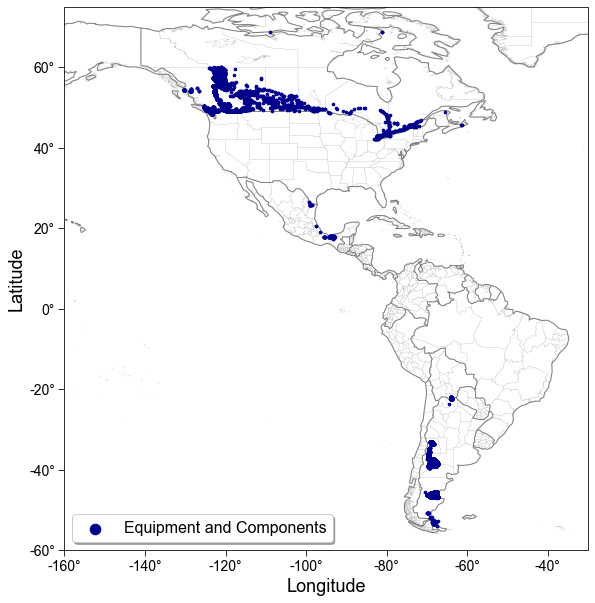

In [77]:
# Preview
save_path = "results\\OGIM_NA_SA_v1.2\\GeoPackage\\_results_fig_equipment_components.png"
fig_ = scatterMaps(
    equip4, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=7,
    markerColor='darkblue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Equipment and Components",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [78]:
# Write to GeoPackage
# ==============================
equip4.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Equipment_Components", driver="GPKG", encoding="utf-8")

# GeoJSON
equip4.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Equipment_Components.geojson", driver="GeoJSON", encoding="utf-8")


# Crude Oil refineries

In [79]:
# Read data
ref_ = glob.glob(os.getcwd() + "\\*refin*.geojson")
ref1 = read_data_(ref_)

Total # of records =  250


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry
0,4306199,CRUDE OIL REFINERIES,ARGENTINA,BUENOS AIRES,113,2020-02-12,N/A,DOCK SUD,N/A,N/A,N/A,DESTILERIA ARGENTINA DE PETROLEO S.A.,1900-01-01,N/A,-999,-999,-999,-34.66228,-58.32338,POINT (-58.32338 -34.66228)
1,4306200,CRUDE OIL REFINERIES,ARGENTINA,BUENOS AIRES,113,2020-02-12,N/A,CAMPANA,N/A,N/A,N/A,ENARSA ENERGIA ARGENTINA S.A.,1900-01-01,N/A,-999,-999,-999,-34.16968,-58.93922,POINT (-58.93922 -34.16968)
2,4306201,CRUDE OIL REFINERIES,ARGENTINA,NEUQUEN,113,2020-02-12,N/A,NUEQUEN,N/A,N/A,N/A,PETROLERA ARGENTINA S.A.,1900-01-01,N/A,-999,-999,-999,-38.93131,-69.14870000000001,POINT (-69.14870 -38.93131)
3,4306202,CRUDE OIL REFINERIES,ARGENTINA,NUEQUEN,113,2020-02-12,N/A,PLAZA HUINCUL,N/A,N/A,N/A,REFINADORA NEUQUINA S.A.,1900-01-01,N/A,-999,-999,-999,-38.93301,-69.16155999999999,POINT (-69.16156 -38.93301)
4,4306203,CRUDE OIL REFINERIES,ARGENTINA,BUENOS AIRES,113,2020-02-12,N/A,GENERAL RODRIGUEZ,N/A,N/A,N/A,GRASTA PETROLEO S.A.,1900-01-01,N/A,-999,-999,-999,-34.65702,-58.94539,POINT (-58.94539 -34.65702)


In [80]:
# Check CATEGORY
ref1.CATEGORY.unique()
ref1['CATEGORY'] = 'CRUDE OIL REFINERIES'

In [81]:
# Data quality checks
refA = data_quality_checks(ref1, starting_ogim_id=equip4.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 17913.05it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


250it [00:00, 4560.51it/s]

0.---> OGIM_ID <----
array([2554232, 2554233, 2554234, 2554235, 2554236, 2554237, 2554238,
       2554239, 2554240, 2554241, 2554242, 2554243, 2554244, 2554245,
       2554246, 2554247, 2554248, 2554249, 2554250, 2554251, 2554252,
       2554253, 2554254, 2554255, 2554256, 2554257, 2554258, 2554259,
       2554260, 2554261, 2554262, 2554263, 2554264, 2554265, 2554266,
       2554267, 2554268, 2554269, 2554270, 2554271, 2554272, 2554273,
       2554274, 2554275, 2554276, 2554277, 2554278, 2554279, 2554280,
       2554281, 2554282, 2554283, 2554284, 2554285, 2554286, 2554287,
       2554288, 2554289, 2554290, 2554291, 2554292, 2554293, 2554294,
       2554295, 2554296, 2554297, 2554298, 2554299, 2554300, 2554301,
       2554302, 2554303, 2554304, 2554305, 2554306, 2554307, 2554308,
       2554309, 2554310, 2554311, 2554312, 2554313, 2554314, 2554315,
       2554316, 2554317, 2554318, 2554319, 2554320, 2554321, 2554322,
       2554323, 2554324, 2554325, 2554326, 2554327, 2554328, 2554329,

In [82]:
# Drop columns with only N/A values
refB = refA.drop(columns=['COMMODITY', 'LIQ_THROUGHPUT_BPD', 'NUM_STORAGE_TANKS'])

In [83]:
# Reset index
refC = refB.reset_index(drop=True)
refC.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,LIQ_CAPACITY_BPD,LATITUDE,LONGITUDE,geometry
245,2554477,CRUDE OIL REFINERIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,57,REFINERY,N/A,N/A,1900-01-01,-999.0,10.21569,-64.64645,POINT (-64.64645 10.21569)
246,2554478,CRUDE OIL REFINERIES,VENEZUELA,N/A,132,2017-01-01,N/A,N/A,58,REFINERY,N/A,N/A,1900-01-01,-999.0,10.19428,-64.49369,POINT (-64.49369 10.19428)
247,2554479,CRUDE OIL REFINERIES,VENEZUELA,N/A,132,2017-01-01,N/A,CENTRO DE REFINACION PARAGUANA,64,REFINERY,N/A,N/A,1900-01-01,-999.0,11.84149,-70.17451,POINT (-70.17451 11.84149)
248,2554480,CRUDE OIL REFINERIES,VENEZUELA,N/A,132,2017-01-01,N/A,CENTRO DE REFINACION PARAGUANA,67,REFINERY,N/A,N/A,1900-01-01,-999.0,11.53002,-70.20021,POINT (-70.20021 11.53002)
249,2554481,CRUDE OIL REFINERIES,VENEZUELA,N/A,132,2017-01-01,N/A,REFINERIA BAJO GRANDE,76,REFINERY,N/A,N/A,1900-01-01,-999.0,10.60857,-71.71418,POINT (-71.71418 10.60857)


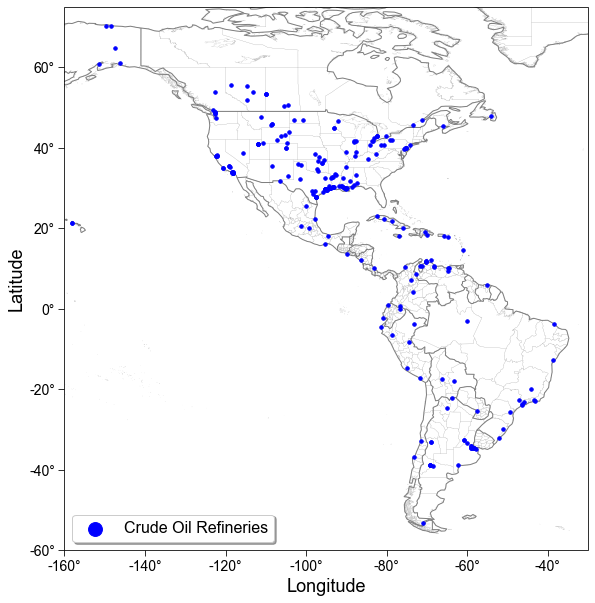

In [84]:
# Preview
save_path = "_results_fig_crude_oil_refineries.png"
fig_ = scatterMaps(
    refC, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='blue',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Crude Oil Refineries",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [85]:
# Write to GeoPackage
# ==============================
refC.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Crude_Oil_Refineries", driver="GPKG", encoding="utf-8")

# GeoJSON
refC.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Crude_Oil_Refineries.geojson", driver="GeoJSON", encoding="utf-8")


# LNG

In [86]:
# Read LNG dataset
lng_ = glob.glob(os.getcwd() + "\\*lng*.geojson")
lng1 = read_data_(lng_)

Total # of records =  50


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry
0,4306221,LNG,ARGENTINA,BUENOS AIRES,114,2017-05-04,N/A,INGENIERO WHITE,N/A,N/A,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-38.78786,-62.28967,POINT (-62.28967 -38.78786)
1,4306222,LNG,ARGENTINA,BUENOS AIRES,114,2017-05-04,N/A,ESCOBAR,N/A,N/A,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-34.24237,-58.76179,POINT (-58.76179 -34.24237)
0,4546672,GLNG,BRAZIL,N/A,126,2022-05-15,N/A,TERMINAL DE GNL BARCARENA - CELBA,N/A,N/A,...,1900-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,-1.54548,-48.74518,POINT (-48.74518 -1.54548)
1,4546673,GLNG,BRAZIL,N/A,126,2022-05-15,N/A,TERMINAL DE REGASEIFICACAO DE GNL DO PORTO DO ...,N/A,N/A,...,1900-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,-21.84574,-41.01371,POINT (-41.01371 -21.84574)
2,4546674,GLNG,BRAZIL,N/A,126,2022-05-15,N/A,TERMINAL DE GNL BARRA DOS COQUEIROS - CELSE,N/A,N/A,...,1900-01-01,N/A,-999.0,-999.0,-999.0,-999.0,-999,-10.81433,-36.93701,POINT (-36.93701 -10.81433)


In [87]:
# Check CATEGORY
lng1.CATEGORY.unique()
lng1['CATEGORY'] = 'LNG FACILITIES'

In [88]:
# Countries
lng1.COUNTRY.unique()

array(['ARGENTINA', 'BRAZIL', 'CANADA', 'MEXICO', 'CHILE',
       'DOMINICAN REPUBLIC', 'TRINIDAD AND TOBAGO', 'PERU',
       'UNITED STATES'], dtype=object)

In [89]:
# Data quality checks
lngA = data_quality_checks(lng1, starting_ogim_id=refC.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12540.53it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


50it [00:00, 3550.70it/s]

0.---> OGIM_ID <----
array([2554482, 2554483, 2554484, 2554485, 2554486, 2554487, 2554488,
       2554489, 2554490, 2554491, 2554492, 2554493, 2554494, 2554495,
       2554496, 2554497, 2554498, 2554499, 2554500, 2554501, 2554502,
       2554503, 2554504, 2554505, 2554506, 2554507, 2554508, 2554509,
       2554510, 2554511, 2554512, 2554513, 2554514, 2554515, 2554516,
       2554517, 2554518, 2554519, 2554520, 2554521, 2554522, 2554523,
       2554524, 2554525, 2554526, 2554527, 2554528, 2554529, 2554530,
       2554531])
1.---> CATEGORY <----
array(['LNG FACILITIES'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BRAZIL', 'CANADA', 'MEXICO', 'CHILE',
       'DOMINICAN REPUBLIC', 'TRINIDAD AND TOBAGO', 'PERU',
       'UNITED STATES'], dtype=object)
3.---> STATE_PROV <----
array(['BUENOS AIRES', 'N/A', 'BRITISH COLUMBIA', 'ALASKA', 'GEORGIA',
       'LOUISIANA', 'MASSACHUSETTS', 'MARYLAND', 'MISSISSIPPI', 'TEXAS',
       'PR', 'FLORIDA'], dtype=object)
4.---> SRC_REF_ID <----


In [90]:
# Drop columns with only N/A values
lngB = lngA.drop(columns=['COMMODITY', 'LIQ_CAPACITY_BPD', 'LIQ_THROUGHPUT_BPD', 'NUM_STORAGE_TANKS'])

In [91]:
# Consistent status definition
lngC = replace_row_names(lngB, colName="FAC_STATUS", dict_names={'CONSTRUCTION':'UNDER CONSTRUCTION'})

Original list of unique attributes =  ['N/A' 'CONSTRUCTION' 'OPERATIONAL' 'PRE-OPERATIONAL' 'PERMIT APPROVED'
 'ACTIVE' 'UNDER CONSTRUCTION']
['N/A' 'UNDER CONSTRUCTION' 'OPERATIONAL' 'PRE-OPERATIONAL'
 'PERMIT APPROVED' 'ACTIVE']


In [92]:
# Modify import/export terminal
lngD = replace_row_names(lngC, colName="FAC_TYPE", dict_names={'EXPORT': 'EXPORT TERMINAL', 'IMPORT': 'IMPORT TERMINAL'})

Original list of unique attributes =  ['N/A' 'LNG FACILITY' 'EXPORT' 'IMPORT']
['N/A' 'LNG FACILITY' 'EXPORT TERMINAL' 'IMPORT TERMINAL']


In [93]:
# Reset index
lngE = lngD.reset_index(drop=True)
lngE.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
45,2554527,LNG FACILITIES,UNITED STATES,LOUISIANA,92,2019-10-08,ONSHORE,DRIFTWOOD LNG,ANLLNG22006,EXPORT TERMINAL,N/A,TELLURIAN INC.,1900-01-01,-999000.0,0.0,30.09738,-93.32911,POINT (-93.32911 30.09738)
46,2554528,LNG FACILITIES,UNITED STATES,TEXAS,92,2019-10-08,ONSHORE,CORPUS CHRISTI LNG,ANLLNG48004,EXPORT TERMINAL,N/A,"CORPUS CHRISTI LIQUEFICATION LLC, CHENIERE",1900-01-01,10400.0,1440.0,27.88987,-97.27440,POINT (-97.27440 27.88987)
47,2554529,LNG FACILITIES,UNITED STATES,TEXAS,92,2019-10-08,ONSHORE,GOLDEN PASS LNG EXPORT TERMINAL,ANLLNG48005,EXPORT TERMINAL,N/A,"QATAR PETROLEUM (70%), EXXONMOBIL (17.6%), CON...",1900-01-01,18000.0,0.0,29.76174,-93.91872,POINT (-93.91872 29.76174)
48,2554530,LNG FACILITIES,UNITED STATES,LOUISIANA,92,2019-10-08,ONSHORE,CALCASIEU PASS LNG,ANLLNG22007,EXPORT TERMINAL,N/A,VENTURE GLOBAL LNG (VENTURE GLOBAL CALCASIEU P...,1900-01-01,-999000.0,0.0,29.77290,-93.33961,POINT (-93.33961 29.77290)
49,2554531,LNG FACILITIES,UNITED STATES,FLORIDA,92,2019-12-06,ONSHORE,AMERICAN LNG HIALEAH TERMINAL,ANLLNG12001,EXPORT TERMINAL,N/A,AMERICAN LNG MARKETING LLC,1900-01-01,-999000.0,-999000.0,25.83879,-80.30801,POINT (-80.30801 25.83879)


In [94]:
# Replace GAS CAPACITIES NULL
lngE['GAS_CAPACITY_MMCFD'] = lngE['GAS_CAPACITY_MMCFD'].replace(-999000, -999)
lngE['GAS_THROUGHPUT_MMCFD'] = lngE['GAS_THROUGHPUT_MMCFD'].replace(-999000, -999)

lngE.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
45,2554527,LNG FACILITIES,UNITED STATES,LOUISIANA,92,2019-10-08,ONSHORE,DRIFTWOOD LNG,ANLLNG22006,EXPORT TERMINAL,N/A,TELLURIAN INC.,1900-01-01,-999.0,0.0,30.09738,-93.32911,POINT (-93.32911 30.09738)
46,2554528,LNG FACILITIES,UNITED STATES,TEXAS,92,2019-10-08,ONSHORE,CORPUS CHRISTI LNG,ANLLNG48004,EXPORT TERMINAL,N/A,"CORPUS CHRISTI LIQUEFICATION LLC, CHENIERE",1900-01-01,10400.0,1440.0,27.88987,-97.27440,POINT (-97.27440 27.88987)
47,2554529,LNG FACILITIES,UNITED STATES,TEXAS,92,2019-10-08,ONSHORE,GOLDEN PASS LNG EXPORT TERMINAL,ANLLNG48005,EXPORT TERMINAL,N/A,"QATAR PETROLEUM (70%), EXXONMOBIL (17.6%), CON...",1900-01-01,18000.0,0.0,29.76174,-93.91872,POINT (-93.91872 29.76174)
48,2554530,LNG FACILITIES,UNITED STATES,LOUISIANA,92,2019-10-08,ONSHORE,CALCASIEU PASS LNG,ANLLNG22007,EXPORT TERMINAL,N/A,VENTURE GLOBAL LNG (VENTURE GLOBAL CALCASIEU P...,1900-01-01,-999.0,0.0,29.77290,-93.33961,POINT (-93.33961 29.77290)
49,2554531,LNG FACILITIES,UNITED STATES,FLORIDA,92,2019-12-06,ONSHORE,AMERICAN LNG HIALEAH TERMINAL,ANLLNG12001,EXPORT TERMINAL,N/A,AMERICAN LNG MARKETING LLC,1900-01-01,-999.0,-999.0,25.83879,-80.30801,POINT (-80.30801 25.83879)


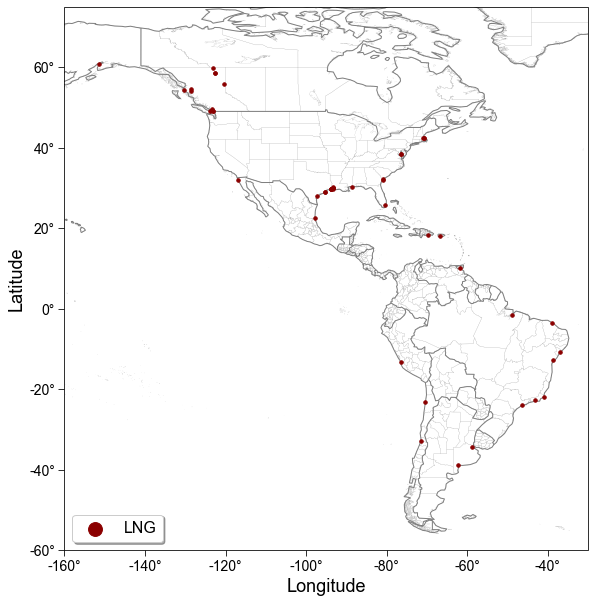

In [95]:
# Preview
save_path = "_results_fig_LNG.png"
fig_ = scatterMaps(
    lngE, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='darkred',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="LNG",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [96]:
# Write to GeoPackage
# ==============================
lngE.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="LNG_Facilities", driver="GPKG", encoding="utf-8")

# GeoJSON
lngE.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\LNG_Facilities.geojson", driver="GeoJSON", encoding="utf-8")


# Injection and disposal facilities

In [97]:
# Read dataset
inj_ = glob.glob(os.getcwd() + "\\*injection*.geojson")
inj1 = read_data_(inj_)

Total # of records =  13695


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry
0,4227126,INJECTION AND DISPOSAL,ARGENTINA,N/A,110,2022-05-07,N/A,SATELITE INYECTOR DE AGUA,N/A,SATELLITE WATER INJECTOR,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-45.95794,-69.95272,POINT (-69.95272 -45.95794)
1,4227149,INJECTION AND DISPOSAL,ARGENTINA,N/A,110,2022-05-07,N/A,PLANTA INYECCION AGUA SALADA,N/A,SALT WATER INJECTION PLANT,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-36.95895,-69.5949,POINT (-69.59490 -36.95895)
2,4227163,INJECTION AND DISPOSAL,ARGENTINA,N/A,110,2022-05-07,N/A,COLECTOR,N/A,SATELLITE GAS INJECTOR,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-36.95075,-69.5968,POINT (-69.59680 -36.95075)
3,4227165,INJECTION AND DISPOSAL,ARGENTINA,N/A,110,2022-05-07,N/A,COLECTOR,N/A,SATELLITE WATER INJECTOR,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-36.95891,-69.59492,POINT (-69.59492 -36.95891)
4,4227188,INJECTION AND DISPOSAL,ARGENTINA,N/A,110,2022-05-07,N/A,ZORRO 04,N/A,FRESH WATER INJECTION PLANT,...,1900-01-01,N/A,-999,-999,-999,-999,-999,-45.95872,-68.58273,POINT (-68.58273 -45.95872)


In [98]:
# Check facility category
inj1.CATEGORY.unique()
inj1['CATEGORY'] = "INJECTION AND DISPOSAL"

In [99]:
# Data quality checks
inj2 = data_quality_checks(inj1, starting_ogim_id=lngE.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████████| 13695/13695 [00:00<00:00, 19188.14it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_STORAGE_TANKS,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


13695it [00:02, 4642.55it/s]


0.---> OGIM_ID <----
array([2554532, 2554533, 2554534, ..., 2568224, 2568225, 2568226])
1.---> CATEGORY <----
array(['INJECTION AND DISPOSAL'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'CANADA', 'UNITED STATES'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'MANITOBA', 'SASKATCHEWAN', 'ALASKA', 'ALABAMA',
       'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'IOWA', 'ILLINOIS',
       'INDIANA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MARYLAND',
       'MICHIGAN', 'MINNESOTA', 'MISSOURI', 'MISSISSIPPI', 'MONTANA',
       'NEBRASKA', 'NEW MEXICO', 'NEW YORK', 'OHIO', 'OKLAHOMA', 'OREGON',
       'PENNSYLVANIA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VIRGINIA',
       ' WASHINGTON', 'WEST VIRGINIA', 'WYOMING'], dtype=object)
4.---> SRC_REF_ID <----
array(['110', '3,4', '52', '40,41,42,43', '100'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-07', '2022-04-11', '2022-03-28', '2022-02-05'],
      dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'ONSHORE'], dtype=objec

<GeometryArray>
 ...
Length: 10898, dtype: geometry


In [100]:
# Drop columns with only N/A values
inj3 = inj2.drop(columns=['COMMODITY', 'LIQ_THROUGHPUT_BPD', 'NUM_STORAGE_TANKS'])

In [101]:
# Reset index
inj4 = inj3.reset_index(drop=True)
inj4.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,LIQ_CAPACITY_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,LATITUDE,LONGITUDE,geometry
13690,2568222,INJECTION AND DISPOSAL,UNITED STATES,WYOMING,100,2022-02-05,ONSHORE,LEROY,411227_4,AQUIFER,ACTIVE,QUESTAR PIPELINE COMPANY,1900-01-01,-999.0,-999.0,-999.0,41.3299,-110.6193,POINT (-110.61930 41.32990)
13691,2568223,INJECTION AND DISPOSAL,UNITED STATES,WYOMING,100,2022-02-05,ONSHORE,BELLE BUTTE,621470_1,DEPLETED FIELD,ACTIVE,SPIRE STORAGE WEST LLC,1900-01-01,-999.0,-999.0,-999.0,41.4549,-110.8109,POINT (-110.81090 41.45490)
13692,2568224,INJECTION AND DISPOSAL,UNITED STATES,WYOMING,100,2022-02-05,ONSHORE,SPIRE STORAGE/CLEARCREEK,147121_1,DEPLETED FIELD,ACTIVE,SPIRE STORAGE WEST LLC,1900-01-01,-999.0,-999.0,-999.0,41.3790,-110.8419,POINT (-110.84190 41.37900)
13693,2568225,INJECTION AND DISPOSAL,UNITED STATES,WYOMING,100,2022-02-05,ONSHORE,BILLY CREEK,64880_1,DEPLETED FIELD,INACTIVE,WBI ENERGY TRANSMISSION INC,1900-01-01,-999.0,-999.0,-999.0,44.1241,-106.7310,POINT (-106.73100 44.12410)
13694,2568226,INJECTION AND DISPOSAL,UNITED STATES,WYOMING,100,2022-02-05,ONSHORE,ELK BASIN,218981_3,DEPLETED FIELD,ACTIVE,WBI ENERGY TRANSMISSION INC,1900-01-01,-999.0,-999.0,-999.0,44.9918,-108.8673,POINT (-108.86730 44.99180)


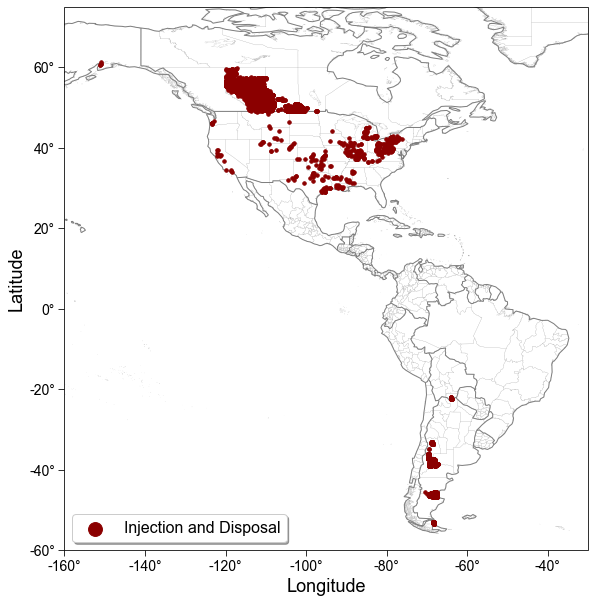

In [102]:
# Preview
save_path = "_results_fig_Injection_Disposal.png"
fig_ = scatterMaps(
    inj4, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='darkred',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Injection and Disposal",
    saveFigPath=save_path,
    showLegend=True,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [103]:
# Write to GeoPackage
# ==============================
inj4.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Injection_Disposal", driver="GPKG", encoding="utf-8")

# GeoJSON
inj4.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Injection_Disposal.geojson", driver="GeoJSON", encoding="utf-8")


# Pipelines

In [104]:
# Read dataset
pipes_ = glob.glob(os.getcwd() + "\\*pipe*.geojson")
pipes1 = read_data_(pipes_)

Total # of records =  1259947


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,PIPE_DIAMETER_MM,PIPE_LENGTH_KM,PIPE_MATERIAL,geometry
0,4306223,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,CERRO GRANITO,N/A,GAS PIPELINE,...,1900-01-01,N/A,-999,-999,-999,-999,6,17.4,S/D,"LINESTRING (-69.53581 -39.14890, -69.53447 -39..."
1,4306224,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,GAS 6 PTG - B NJ,N/A,GAS PIPELINE,...,1900-01-01,N/A,-999,-999,-999,-999,8,0.9399999999999999,S/D,"LINESTRING (-69.50866 -38.99669, -69.50780 -38..."
2,4306225,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,GAS 4 PTG - CAMUZZI PM49,N/A,GAS PIPELINE,...,1900-01-01,N/A,-999,-999,-999,-999,4,4.64,S/D,"LINESTRING (-69.50865 -38.99673, -69.50827 -38..."
3,4306226,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,OIL 4 BATERIA BBG - BG,N/A,OIL PIPELINE,...,1900-01-01,N/A,-999,-999,-999,-999,8,5.39,STEEL,"LINESTRING (-69.09242 -38.84509, -69.09334 -38..."
4,4306227,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,OIL 4 LNN B GU3,N/A,OIL PIPELINE,...,1900-01-01,N/A,-999,-999,-999,-999,4,14.2,S/D,"LINESTRING (-69.26731 -38.85846, -69.26903 -38..."


In [105]:
# Check CRS
pipes1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [106]:
# Data quality checks
pipes2 = data_quality_checks(pipes1, starting_ogim_id=inj4.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████| 1259947/1259947 [01:47<00:00, 11727.89it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,PIPE_DIAMETER_MM,PIPE_LENGTH_KM,PIPE_MATERIAL,geometry


Now, standardizing PIPELINE attributes (length, diameter)


1259947it [03:43, 5634.46it/s]


0.---> OGIM_ID <----
array([2568227, 2568228, 2568229, ..., 3828171, 3828172, 3828173])
1.---> CATEGORY <----
array(['OIL AND NATURAL GAS PIPELINES'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'BRAZIL', 'CANADA', 'COLOMBIA', 'MEXICO',
       'ECUADOR', 'PERU', 'CHILE', 'UNITED STATES', 'VENEZUELA'],
      dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA', 'ONTARIO',
       'NEW BRUNSWICK', 'NEWFOUNDLAND AND LABRADOR',
       'NORTHWEST TERRITORIES', 'NUNAVUT', 'QUEBEC', 'YUKON',
       'NOVA SCOTIA', 'SASKATCHEWAN'], dtype=object)
4.---> SRC_REF_ID <----
array(['115', '116', '124', '126', '8', '11', '33', '31', '32', '53',
       '54', '61', '62', '67', '65', '71', '73', '63', '75', '69', '46',
       '129', '101', '22', '95', '96', '132'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-01', '2017-05-04', '2016-11-23', '2022-05-15',
       '2022-01-01', '2021-11-01', '2022-03-08', '2022-03-28',
       '2022-03-29'

array(['S/D', 'STEEL', 'COATED STEEL', 'THREADED STEEL', 'PRFV', 'ERFV',
       'ASTM A53 STEEL A-REVESTITE', 'B', 'B/X52', 'X42', 'X 52', 'X60',
       'ASTM A53 GRADE B STEEL', 'NO DATA', 'AERIAL',
       'HIGH DENSITY POLYETHYLENE', 'J55', 'ASTM A53 GR B', 'API 5L GR B',
       'API 5CT', 'API 5L GR X42', 'API 5L X42',
       'CARBON STEEL 5L/ASTM A53 GRADE B', 'STEEL AND ERFV',
       'API 5L GR.B STEEL', 'ASTM A53-70', 'ASTM-A-53-70',
       'API STEEL 5L X-52', 'API 5LX-242 CAÂ ¥ ERIA',
       'API 5L GR X-56 STEEL', 'ASTM A53GR STEEL', 'ASTM A53 A 106 GR AB',
       'ASTM A53GR B STEEL', 'ASTM A53GR AB STEEL', 'ERFV S 600',
       'ERFV S 800', 'POLYETHYLENE', 'ASTM A53 GR B STEEL', 'TUBING',
       'PLASTIC', 'FIBER', 'HOSE', 'ASTM A-106 GR.B', 'ASTM A53/106',
       'ASTM A53 GR A', 'ASTM A106 GR B', 'CARBON STEEL',
       'API J55 - 9.2 LB/FEET', 'API 5L X65', 'API 5L SCH40',
       'API 5L GR X52', 'API 5L GR X56', 'API 5L SCH80', 'ERFV AMINA',
       'API 5L GR X60', 'API 5

In [107]:
# Fix operator names
dict_names = {
    'COMPAÃ\x91Ã\x8dAS ASOCIADAS PETROLERAS S.A.': 'COMPANIAS ASOCIADAS PETROLERAS S.A.',
    'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.': 'YSUR ENERGIA ARGENTINA S.R.L.',
    }
pipes3 = replace_row_names(pipes2, colName="OPERATOR", dict_names=dict_names)

Original list of unique attributes =  ['APACHE ENERGIA ARGENTINA S.R.L.' 'PETROLERA LF COMPANY S.R.L.'
 'COMPAÃ\x91Ã\x8dA GENERAL DE COMBUSTIBLES S.A.' ...
 'GARDEN BANKS GATHERING SYSTEM' 'GARDEN BANKS AUGER 2 LINE'
 'GARDEN BANKS AUGER 1 LINE']
['APACHE ENERGIA ARGENTINA S.R.L.' 'PETROLERA LF COMPANY S.R.L.'
 'COMPAÃ\x91Ã\x8dA GENERAL DE COMBUSTIBLES S.A.' ...
 'GARDEN BANKS GATHERING SYSTEM' 'GARDEN BANKS AUGER 2 LINE'
 'GARDEN BANKS AUGER 1 LINE']


In [108]:
# Drop columns with only N/A values
pipes4 = pipes3.drop(columns=['LIQ_THROUGHPUT_BPD', 'GAS_THROUGHPUT_MMCFD'])

In [109]:
# Reset indices
pipes5 = pipes4.reset_index(drop=True)

In [110]:
# Strip Z coordinate
pipes6 = transform_geom_3d_2d(pipes5)

100%|██████████████████████████████████████████████████████████████████████| 1259947/1259947 [02:38<00:00, 7951.05it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,INSTALL_DATE,COMMODITY,LIQ_CAPACITY_BPD,GAS_CAPACITY_MMCFD,PIPE_DIAMETER_MM,PIPE_LENGTH_KM,PIPE_MATERIAL,geometry
0,2568227,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,CERRO GRANITO,N/A,GAS PIPELINE,N/A,APACHE ENERGIA ARGENTINA S.R.L.,1900-01-01,N/A,-999.0,-999.0,6.0,17.40,S/D,"LINESTRING (-69.53581 -39.14890, -69.53447 -39..."
1,2568228,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,GAS 6 PTG - B NJ,N/A,GAS PIPELINE,N/A,APACHE ENERGIA ARGENTINA S.R.L.,1900-01-01,N/A,-999.0,-999.0,8.0,0.94,S/D,"LINESTRING (-69.50866 -38.99669, -69.50780 -38..."
2,2568229,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,GAS 4 PTG - CAMUZZI PM49,N/A,GAS PIPELINE,N/A,APACHE ENERGIA ARGENTINA S.R.L.,1900-01-01,N/A,-999.0,-999.0,4.0,4.64,S/D,"LINESTRING (-69.50865 -38.99673, -69.50827 -38..."
3,2568230,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,OIL 4 BATERIA BBG - BG,N/A,OIL PIPELINE,N/A,APACHE ENERGIA ARGENTINA S.R.L.,1900-01-01,N/A,-999.0,-999.0,8.0,5.39,STEEL,"LINESTRING (-69.09242 -38.84509, -69.09334 -38..."
4,2568231,OIL AND NATURAL GAS PIPELINES,ARGENTINA,N/A,115,2022-05-01,N/A,OIL 4 LNN B GU3,N/A,OIL PIPELINE,N/A,APACHE ENERGIA ARGENTINA S.R.L.,1900-01-01,N/A,-999.0,-999.0,4.0,14.20,S/D,"LINESTRING (-69.26731 -38.85846, -69.26903 -38..."


In [111]:
# Check CRS
pipes6.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

!! CRS is not set or not in EPSG:4326!!


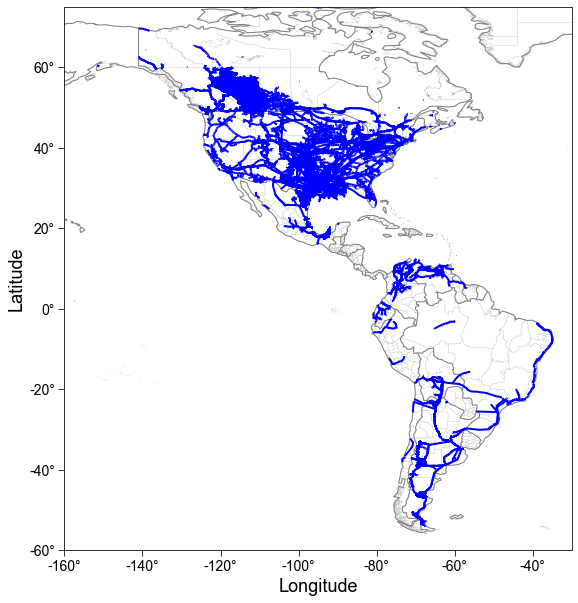

In [112]:
# Preview
save_path = "_results_fig_Pipelines.png"
fig_ = scatterMaps(
    pipes6, 
    lat_lon=False,
    showPipelines=True,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='darkred',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Oil and Natural Gas Pipelines",
    saveFigPath=save_path,
    showLegend=False,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [113]:
# Write to GeoPackage
# ==============================
pipes6.to_file("results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Pipelines", driver="GPKG", encoding="utf-8")

# GeoJSON
pipes6.to_file("results\OGIM_NA_SA_v1.2\GeoPackage\Oil_Natural_Gas_Pipelines.geojson", driver="GeoJSON", encoding="utf-8")


# Oil and gas production data

In [114]:
# Read dataset
prod_ = glob.glob(os.getcwd() + "\\*production*.geojson")
prod1 = read_data_(prod_).reset_index()

Total # of records =  196679


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,OIL_BBL,GAS_MCF,WATER_BBL,CONDENSATE_BBL,PROD_DAYS,PROD_YEAR,ENTITY_TYPE,LATITUDE,LONGITUDE,geometry
0,4433222,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,N/A,120,2022-05-12,N/A,CH.CH.EALE.X-1,212,OIL,...,6950,4110,-999,-999,348.19,2021,WELL,-45.59113,-68.28785000000001,POINT (-68.28785 -45.59113)
1,4433223,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,N/A,120,2022-05-12,N/A,CH.CH.EALE.X-2,213,WATER INJECTION,...,0,0,-999,-999,0,2021,WELL,-45.59202,-68.29201999999999,POINT (-68.29202 -45.59202)
2,4433224,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,N/A,120,2022-05-12,N/A,CH.CH.EALE-3,214,OIL,...,9640,2850,-999,-999,354.77,2021,WELL,-45.59024,-68.28388,POINT (-68.28388 -45.59024)
3,4433225,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,N/A,120,2022-05-12,N/A,CH.CH.EALE-4,215,OIL,...,3000,1190,-999,-999,350.92,2021,WELL,-45.59407,-68.28948,POINT (-68.28948 -45.59407)
4,4433226,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,N/A,120,2022-05-12,N/A,CH.CH.EALE-5,216,OIL,...,3460,1250,-999,-999,357.56,2021,WELL,-45.59445,-68.29447999999999,POINT (-68.29448 -45.59445)


In [115]:
# Check CRS
prod1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [116]:
# Data quality checks
prod2 = data_quality_checks(prod1, starting_ogim_id=pipes6.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████| 196679/196679 [00:09<00:00, 19741.06it/s]

Number of features with INVALID geometries =  57


,index,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,...,OIL_BBL,GAS_MCF,WATER_BBL,CONDENSATE_BBL,PROD_DAYS,PROD_YEAR,ENTITY_TYPE,LATITUDE,LONGITUDE,geometry
50003,50003,4483225,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,NAN,120,2022-05-12,N/A,NAN,NAN,...,0,0,-999,-999,0,2021,WELL,None,None,None
50863,50863,4484085,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,NAN,120,2022-05-12,N/A,NAN,NAN,...,0,0,-999,-999,0,2021,WELL,None,None,None
50867,50867,4484089,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,NAN,120,2022-05-12,N/A,NAN,NAN,...,0,0,-999,-999,0,2021,WELL,None,None,None
63527,63527,4496749,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,NAN,120,2022-05-12,N/A,NAN,NAN,...,0,0,-999,-999,0,2021,WELL,None,None,None
63528,63528,4496750,OIL AND NATURAL GAS PRODUCTION,ARGENTINA,NAN,120,2022-05-12,N/A,NAN,NAN,...,0,0,-999,-999,0,2021,WELL,None,None,None


!!!There are INVALID geometries in dataset!!! 
 ===>Removing INVALID records <===
Now, standardizing `LATITUDE` and `LONGITUDE` columns


196622it [00:42, 4665.10it/s]


Now, standardizing PRODUCTION metrics


196622it [01:17, 2527.74it/s]


0.---> index <----
array([    0,     1,     2, ..., 70232, 70233, 70234], dtype=int64)
1.---> OGIM_ID <----
array([3828174, 3828175, 3828176, ..., 4024793, 4024794, 4024795])
2.---> CATEGORY <----
array(['OIL AND NATURAL GAS PRODUCTION'], dtype=object)
3.---> COUNTRY <----
array(['ARGENTINA', 'CANADA', 'MEXICO'], dtype=object)
4.---> STATE_PROV <----
array(['N/A', 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA'], dtype=object)
5.---> SRC_REF_ID <----
array(['120', '3', '38', '57', '48, 49', '102'], dtype=object)
6.---> SRC_DATE <----
array(['2022-05-12', '2022-04-09', '2022-03-29', '2022-04-11'],
      dtype=object)
7.---> ON_OFFSHORE <----
array(['N/A', 'ONSHORE'], dtype=object)
8.---> FAC_NAME <----
array(['CH.CH.EALE.X-1', 'CH.CH.EALE.X-2', 'CH.CH.EALE-3', ...,
       'ZAPOTALILLO-3', 'ZAPOTALILLO-8', 'ZAPOTALILLO-9'], dtype=object)
9.---> FAC_ID <----
array(['212', '213', '214', ..., '705061', '707004', 'N/A'], dtype=object)
10.---> FAC_TYPE <----
array(['OIL', 'WATER INJECTION', 'AQUIFE

array(['1996-10-30', '1996-10-14', '1997-01-30', ..., '1921-01-15',
       '1963-08-11', '1960-08-12'], dtype=object)
14.---> COMP_DATE <----
array(['1996-11-13', '1997-02-07', '1997-01-20', ..., '1926-10-26',
       '1963-09-13', '1961-12-28'], dtype=object)
15.---> DRILL_TYPE <----
array(['CONVENTIONAL', 'SHALE', 'TIGHT', 'N/A', 'VERTICAL', 'HORIZONTAL',
       'DIRECTIONAL', 'DEVIATED', 'MULTILATERAL'], dtype=object)
16.---> OIL_BBL <----
array([   6950.,       0.,    9640., ..., 1120000., 1330000., 3580000.])
17.---> GAS_MCF <----
array([   4110.,       0.,    2850., ...,  959000., 2740000.,  481000.])
18.---> WATER_BBL <----
array([-999.])
19.---> CONDENSATE_BBL <----
array([-9.99e+02,  0.00e+00,  3.14e+02, ...,  8.25e+05,  8.41e+01,
        1.52e+05])
20.---> PROD_DAYS <----
array([348.,   0., 355., ..., 484., 546., 368.])
21.---> PROD_YEAR <----
array([2021], dtype=int64)
22.---> ENTITY_TYPE <----
array(['WELL', 'FACILITY', 'POOL'], dtype=object)
23.---> LATITUDE <----
array([-4

In [117]:
# Fix operator names
dict_names = {
    'COMPAÃ\x91Ã\x8dAS ASOCIADAS PETROLERAS S.A.': 'COMPANIAS ASOCIADAS PETROLERAS S.A.',
    'YSUR ENERGÃ\x8dA ARGENTINA S.R.L.': 'YSUR ENERGIA ARGENTINA S.R.L.',
    }
prod3 = replace_row_names(prod2, colName="OPERATOR", dict_names=dict_names)

Original list of unique attributes =  ['COLHUE HUAPI S.A.' 'SELVA MARIA OIL S.A.' 'PETROMINERA CHUBUT S.E.'
 'PILGRIM ENERGY S.A.' 'VENOIL S.A.' 'TECPETROL S.A.'
 'RECURSOS Y ENERGIA FORMOSA S.A.' 'PETROQUIMICA COMODORO RIVADAVIA S.A.'
 'MADALENA ENERGY ARGENTINA SRL' 'PETROLERA ACONCAGUA ENERGIA S.A.'
 'PETROLERA EL TREBOL S.A.'
 'COMPAÃ\x91Ã\x8dA GENERAL DE COMBUSTIBLES S.A.'
 'VISTA OIL & GAS ARGENTINA SAU' 'MEDANITO S.A.' 'CAPETROL ARGENTINA S.A.'
 'N/A' 'PETROLEOS SUDAMERICANOS S.A.' 'PLUSPETROL S.A.' 'CAPEX S.A.'
 'CHEVRON ARGENTINA S.R.L.' 'PRESIDENT PETROLEUM S.A.'
 'ENERGIA COMPAÃ\x91IA PETROLERA S.A.' 'ROCH S.A.' 'TOTAL AUSTRAL S.A.'
 'CAPETROL S.A.' 'INGENIERIA ALPA S.A.' 'ENAP SIPETROL ARGENTINA S.A.'
 'PETROLERA DEL COMAHUE S.A.' 'EXXONMOBIL EXPLORATION ARGENTINA S.R.L.'
 'JUJUY HIDROCARBUROS SAU' 'PAN AMERICAN ENERGY SL' 'YPF S.A.'
 'CRI HOLDING, INC.' 'PAMPA ENERGIA S.A.' 'OILSTONE ENERGIA S.A.'
 'SINOPEC ARGENTINA EXPLORATION AND PRODUCTION, INC.'
 'ALIANZA PETROLERA AR

In [118]:
# Standardize drill types
# Wells tapping from shale and tight reservoirs are horizontally drilled
# Conventional wells are vertically drilled
prod4 = replace_row_names(prod3, colName="DRILL_TYPE", dict_names={'SHALE':'HORIZONTAL', 'TIGHT':'HORIZONTAL', 'CONVENTIONAL':'VERTICAL'})


Original list of unique attributes =  ['CONVENTIONAL' 'SHALE' 'TIGHT' 'N/A' 'VERTICAL' 'HORIZONTAL'
 'DIRECTIONAL' 'DEVIATED' 'MULTILATERAL']
['VERTICAL' 'HORIZONTAL' 'N/A' 'DIRECTIONAL' 'DEVIATED' 'MULTILATERAL']


In [119]:
# Reset indices
prod5 = prod4.reset_index(drop=True)
prod5.tail()

,index,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,...,OIL_BBL,GAS_MCF,WATER_BBL,CONDENSATE_BBL,PROD_DAYS,PROD_YEAR,ENTITY_TYPE,LATITUDE,LONGITUDE,geometry
196617,8386,4024791,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZACATE-1017,N/A,...,0.0,36100.0,-999.0,0.0,365.0,2021,WELL,25.85866,-98.72893,POINT (-98.72893 25.85866)
196618,8387,4024792,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-15,N/A,...,3580.0,1560.0,-999.0,0.0,365.0,2021,WELL,20.64305,-97.56882,POINT (-97.56882 20.64305)
196619,8388,4024793,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-3,N/A,...,6690.0,4940.0,-999.0,0.0,365.0,2021,WELL,20.62085,-97.56409,POINT (-97.56409 20.62085)
196620,8389,4024794,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-8,N/A,...,1660.0,1140.0,-999.0,0.0,212.0,2021,WELL,20.61905,-97.56741,POINT (-97.56741 20.61905)
196621,8390,4024795,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-9,N/A,...,3670.0,2170.0,-999.0,0.0,365.0,2021,WELL,20.62266,-97.56741,POINT (-97.56741 20.62266)


In [120]:
prod6 = prod5.drop(columns=['index'])
prod6.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,...,OIL_BBL,GAS_MCF,WATER_BBL,CONDENSATE_BBL,PROD_DAYS,PROD_YEAR,ENTITY_TYPE,LATITUDE,LONGITUDE,geometry
196617,4024791,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZACATE-1017,N/A,N/A,...,0.0,36100.0,-999.0,0.0,365.0,2021,WELL,25.85866,-98.72893,POINT (-98.72893 25.85866)
196618,4024792,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-15,N/A,N/A,...,3580.0,1560.0,-999.0,0.0,365.0,2021,WELL,20.64305,-97.56882,POINT (-97.56882 20.64305)
196619,4024793,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-3,N/A,N/A,...,6690.0,4940.0,-999.0,0.0,365.0,2021,WELL,20.62085,-97.56409,POINT (-97.56409 20.62085)
196620,4024794,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-8,N/A,N/A,...,1660.0,1140.0,-999.0,0.0,212.0,2021,WELL,20.61905,-97.56741,POINT (-97.56741 20.61905)
196621,4024795,OIL AND NATURAL GAS PRODUCTION,MEXICO,N/A,102,2022-04-11,N/A,ZAPOTALILLO-9,N/A,N/A,...,3670.0,2170.0,-999.0,0.0,365.0,2021,WELL,20.62266,-97.56741,POINT (-97.56741 20.62266)


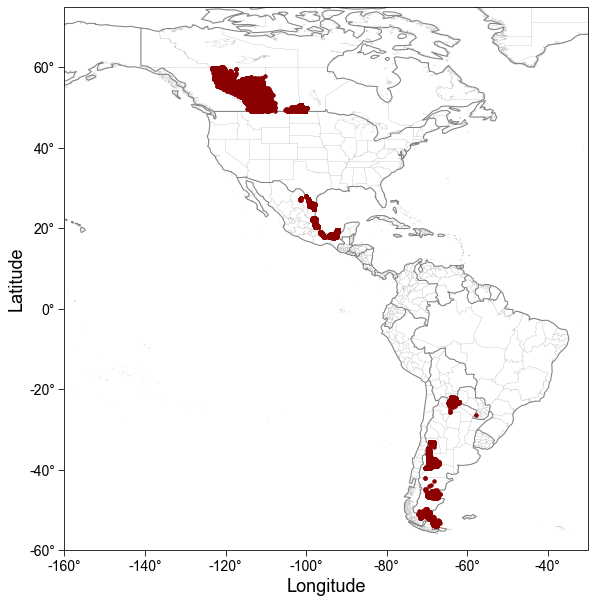

In [121]:
# Preview
save_path = "_results_fig_production_data.png"
fig_ = scatterMaps(
    prod6, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='darkred',
    NA_SA_extent=True,
    figTitle=None,
    dataLabel="Oil and Natural Gas Pipelines",
    saveFigPath=save_path,
    showLegend=False,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr=None,
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [122]:
# Write to GeoPackage
# ==============================
prod6.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Production", driver="GPKG", encoding="utf-8")

# GeoJSON
prod6.to_file("results\\OGIM_NA_SA_v1.2\\GeoPackage\\Oil_Natural_Gas_Production.geojson", driver="GeoJSON", encoding="utf-8")


# VIIRS natural gas flaring detections (2020)
 - Doing data integration and consolidation here

In [123]:
data_ = read_spatial_data(r"Public_Data\data\International_data_sets\Natural_Gas_Flares\GeoJSONS\_VIIRS_Global_Flaring_2020_.geojson")

---------------------------------------
Total # of features in dataset = 10264
Index(['idx', 'Country', 'ISO Code', 'Catalog ID', 'ID 2020', 'Latitude',
       'Longitude', 'BCM 2020', 'Avg. temp., K', 'Ellipticity',
       'Detection frequency 2020', 'Clear Obs.', 'Type', 'Segment_',
       'BCM_2020', 'Avg_Temp_K', 'geometry'],
      dtype='object')


,idx,Country,ISO Code,Catalog ID,ID 2020,Latitude,Longitude,BCM 2020,"Avg. temp., K",Ellipticity,Detection frequency 2020,Clear Obs.,Type,Segment_,BCM_2020,Avg_Temp_K,geometry
0,1.0,Venezuela,VEN,VEN_UPS_2015_63.6230W_9.6521N_v0.2,4881,9.652107,-63.622954,1.487032,1833.61,3.08183,100.0,76,upstream oil,Upstream,1.487032,1833.61,POINT (-63.62295 9.65211)
1,2.0,Iraq,IRQ,IRQ_UPS_2015_47.2835E_31.0259N_v0.2,8117,31.025949,47.283542,1.162892,1647.56,2.57695,100.0,258,upstream oil,Upstream,1.162892,1647.56,POINT (47.28354 31.02595)
2,3.0,Iran,IRN,IRN_UPS_2015_48.1396E_31.0033N_v0.2,8319,31.003250,48.139604,0.777370,1662.12,1.53582,100.0,254,upstream oil,Upstream,0.777370,1662.12,POINT (48.13960 31.00325)
3,4.0,Venezuela,VEN,VEN_UPS_2015_63.5639W_9.6487N_v0.2,4907,9.648722,-63.563896,0.724042,1781.71,2.98155,100.0,80,upstream oil,Upstream,0.724042,1781.71,POINT (-63.56390 9.64872)
4,5.0,Russian Federation,RUS,RUS_UPS_2015_112.8064E_61.3456N_v0.2,11215,61.345605,112.806381,0.717649,1748.57,1.34790,100.0,159,upstream oil,Upstream,0.717649,1748.57,POINT (112.80638 61.34560)


In [124]:
# Calculate flare volumes in MMCF
data_['flared_mmcf'] = data_['BCM 2020']*35.314666721*1000
data_['temp_k'] = data_['Avg. temp., K']
data_['temp_k'] = pd.to_numeric(data_['temp_k'])

In [125]:
data_.Type.unique()
data2 = replace_row_names(data_, colName="Type", dict_names={'lng': 'LNG FACILITY', 'gpp': 'GAS PROCESSING PLANT'})

Original list of unique attributes =  ['upstream oil' 'upstream gas' 'midstream' 'lng' 'gpp']
['upstream oil' 'upstream gas' 'midstream' 'LNG FACILITY'
 'GAS PROCESSING PLANT']


In [126]:
data2['flare_year'] = 2020

In [127]:
data2.Segment_.unique()

array(['Upstream', 'Downstream Oil', 'Downstream Gas'], dtype=object)

In [128]:
# Integrate flares
all_flares_2020, _ = integrate_flares(
    data2,
    starting_ids=1,
    category="NATURAL GAS FLARING DETECTIONS",
    fac_alias='FLARING',
    country="Country",
    state_prov=None,
    src_ref_id="142",
    src_date="2021-05-01",
    on_offshore=None,
    fac_name = None,
    fac_id="ID 2020",
    fac_type="Type",
    fac_status= None,
    op_name= None,
    gas_flared_mmcf="flared_mmcf",
    avg_temp="temp_k",
    days_clear_observs="Clear Obs.",
    flare_year="flare_year",
    segment_type="Segment_",
    fac_latitude="Latitude",
    fac_longitude="Longitude"
    )

100%|██████████████████████████████████████████████████████████████████████████| 10264/10264 [00:05<00:00, 1859.27it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,GAS_FLARED_MMCF,AVERAGE_FLARE_TEMP_K,DAYS_CLEAR_OBSERVATIONS,FLARE_YEAR,SEGMENT_TYPE,LATITUDE,LONGITUDE,geometry
0,1,NATURAL GAS FLARING DETECTIONS,VENEZUELA,N/A,142,2021-05-01,N/A,N/A,4881,UPSTREAM OIL,N/A,N/A,52500.0,1830.0,76,2020,UPSTREAM,9.65211,-63.62295,POINT (-63.62295 9.65211)
1,2,NATURAL GAS FLARING DETECTIONS,IRAQ,N/A,142,2021-05-01,N/A,N/A,8117,UPSTREAM OIL,N/A,N/A,41100.0,1650.0,258,2020,UPSTREAM,31.02595,47.28354,POINT (47.28354 31.02595)
2,3,NATURAL GAS FLARING DETECTIONS,IRAN,N/A,142,2021-05-01,N/A,N/A,8319,UPSTREAM OIL,N/A,N/A,27500.0,1660.0,254,2020,UPSTREAM,31.00325,48.1396,POINT (48.13960 31.00325)
3,4,NATURAL GAS FLARING DETECTIONS,VENEZUELA,N/A,142,2021-05-01,N/A,N/A,4907,UPSTREAM OIL,N/A,N/A,25600.0,1780.0,80,2020,UPSTREAM,9.64872,-63.5639,POINT (-63.56390 9.64872)
4,5,NATURAL GAS FLARING DETECTIONS,RUSSIAN FEDERATION,N/A,142,2021-05-01,N/A,N/A,11215,UPSTREAM OIL,N/A,N/A,25300.0,1750.0,159,2020,UPSTREAM,61.3456,112.80638,POINT (112.80638 61.34560)


In [129]:
# Data quality checks
flares2 = data_quality_checks(all_flares_2020, starting_ogim_id=prod6.OGIM_ID.iloc[-1]+1)

100%|█████████████████████████████████████████████████████████████████████████| 10264/10264 [00:00<00:00, 18939.62it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,GAS_FLARED_MMCF,AVERAGE_FLARE_TEMP_K,DAYS_CLEAR_OBSERVATIONS,FLARE_YEAR,SEGMENT_TYPE,LATITUDE,LONGITUDE,geometry


Now, standardizing `LATITUDE` and `LONGITUDE` columns


10264it [00:02, 4421.72it/s]


0.---> OGIM_ID <----
array([4024796, 4024797, 4024798, ..., 4035057, 4035058, 4035059])
1.---> CATEGORY <----
array(['NATURAL GAS FLARING DETECTIONS'], dtype=object)
2.---> COUNTRY <----
array(['VENEZUELA', 'IRAQ', 'IRAN', 'RUSSIAN FEDERATION', 'MEXICO',
       'ALGERIA', 'TURKMENISTAN', 'CONGO', 'KAZAKHSTAN', 'GUYANA',
       'CHINA', 'OMAN', 'MALAYSIA', 'NIGERIA', 'EGYPT', 'AUSTRALIA',
       'GHANA', 'YEMEN', 'DEMOCRATIC REPUBLIC OF THE CONGO', 'ANGOLA',
       'EQUATORIAL GUINEA', 'LIBYA', 'CAMEROON', 'SYRIA', 'UNITED STATES',
       'SAUDI ARABIA', 'BRAZIL', 'QATAR', 'ARGENTINA', 'VIETNAM', 'GABON',
       'UNITED ARAB EMIRATES', 'THAILAND', 'INDIA', 'CHAD', 'BRUNEI',
       'SAUDI-KUWAITI NEUTRAL ZONE', 'PHILIPPINES', 'UNITED KINGDOM',
       'KUWAIT', 'GUATEMALA', 'ECUADOR', 'SUDAN', 'CANADA', 'INDONESIA',
       'BAHRAIN', 'HUNGARY', 'COLOMBIA', 'UZBEKISTAN', 'DENMARK',
       'PAPUA NEW GUINEA', 'AUSTRALIA - EAST TIMOR', 'AZERBAIJAN',
       'TUNISIA', 'PERU', 'SOUTH AFRICA', 

In [130]:
# Extract only flaring sites in North South America
flares3 = flares2.query("LONGITUDE <= -25").reset_index(drop=True)

In [131]:
flares3.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,FAC_TYPE,FAC_STATUS,OPERATOR,GAS_FLARED_MMCF,AVERAGE_FLARE_TEMP_K,DAYS_CLEAR_OBSERVATIONS,FLARE_YEAR,SEGMENT_TYPE,LATITUDE,LONGITUDE,geometry
4853,4035041,NATURAL GAS FLARING DETECTIONS,DOMINICAN REPUBLIC,N/A,142,2021-05-01,N/A,N/A,4770,LNG FACILITY,N/A,N/A,12.1,1720.0,257,2020,DOWNSTREAM GAS,18.40523,-69.62598,POINT (-69.62598 18.40523)
4854,4035047,NATURAL GAS FLARING DETECTIONS,UNITED STATES,N/A,142,2021-05-01,N/A,N/A,4054,LNG FACILITY,N/A,N/A,6.76,1520.0,256,2020,DOWNSTREAM GAS,28.98726,-95.30924,POINT (-95.30924 28.98726)
4855,4035053,NATURAL GAS FLARING DETECTIONS,MEXICO,N/A,142,2021-05-01,N/A,N/A,4214,LNG FACILITY,N/A,N/A,0.305,1750.0,250,2020,DOWNSTREAM GAS,20.55193,-103.02540,POINT (-103.02540 20.55193)
4856,4035054,NATURAL GAS FLARING DETECTIONS,COLOMBIA,N/A,142,2021-05-01,N/A,N/A,5119,LNG FACILITY,N/A,N/A,0.0,1710.0,66,2020,DOWNSTREAM GAS,4.59307,-74.84063,POINT (-74.84063 4.59307)
4857,4035055,NATURAL GAS FLARING DETECTIONS,CANADA,N/A,142,2021-05-01,N/A,N/A,29,LNG FACILITY,N/A,N/A,0.0,1950.0,188,2020,DOWNSTREAM GAS,54.22476,-130.32064,POINT (-130.32064 54.22476)


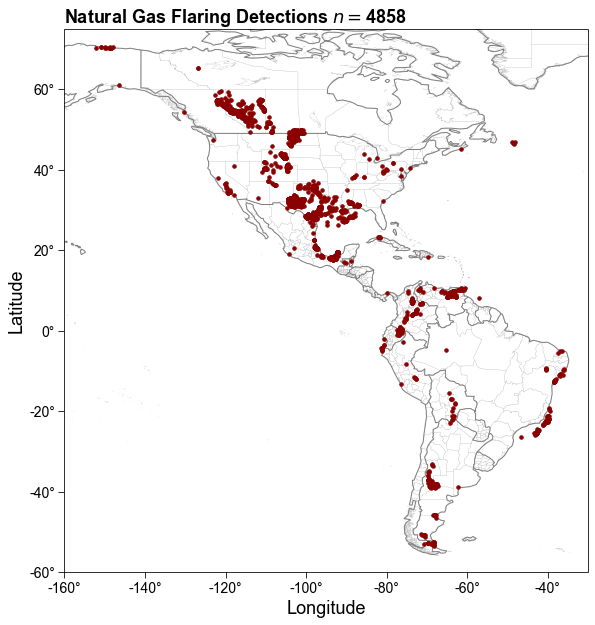

In [132]:
# Preview
save_path = "_results_fig_FLARING_data2.png"
fig_ = scatterMaps(
    flares3, 
    lat_lon=True,
    showPipelines=False,
    pipe_len_attrName='PIPELEN_KM',
    fpShp=None, 
    figWidth=10, 
    figHeight=10,
    markerSize=12,
    markerColor='darkred',
    NA_SA_extent=True,
    figTitle="Natural Gas Flaring Detections",
    dataLabel="Natural Gas Flaring Detections",
    saveFigPath=save_path,
    showLegend=False,
    showArea=False, 
    showScale=False,
    heatMap=False,
    colorAttr="GAS_FLARED_MMCF",
    dataScaling=1,
    colorMapName="gist_rainbow_r",
    axisLabels=True,
    showStates=True,
    showBorders=True,
    showCoast=True,
    showLand=False,
    showOcean=False,
    showLakes=False,
    showRivers=False
    )

In [133]:
# Drop columns with only N/A values
flares4 = flares3.drop(columns=['FAC_NAME', 'FAC_STATUS', 'OPERATOR'])

In [134]:
# Write to GeoPackage
# ==============================
flares4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Natural_Gas_Flaring_Detections", driver="GPKG", encoding="utf-8")

# GeoJSON
flares4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\Natural_Gas_Flaring_Detections.geojson", driver="GeoJSON", encoding="utf-8")


# Oil and gas license blocks

In [135]:
# Read dataset
blocks_ = glob.glob(os.getcwd() + "\\*licen*.geojson")
blk1 = read_data_(blocks_).reset_index(drop=True)

Total # of records =  1019


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,4432938,OIL AND GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,PUESTO QUIROGA,N/A,TECPETROL S.A.,188,"POLYGON ((-67.92109 -45.92776, -67.88885 -45.9..."
1,4432939,OIL AND GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,LA TAPERA,N/A,TECPETROL S.A.,153,"POLYGON ((-68.08657 -45.86104, -68.04081 -45.8..."
2,4432940,OIL AND GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,EL TORDILLO,N/A,TECPETROL S.A.,117,"POLYGON ((-68.04081 -45.86067, -68.02400 -45.8..."
3,4432941,OIL AND GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,ESTANCIA LA MARIPOSA,N/A,TECPETROL S.A.,28,"POLYGON ((-68.11724 -46.08166, -68.11656 -46.1..."
4,4432942,OIL AND GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,LOS BASTOS,N/A,TECPETROL S.A.,369,"POLYGON ((-68.51003 -38.79280, -68.50884 -38.9..."


In [136]:
# Check CATEGORY
blk1.CATEGORY.unique()
blk1['CATEGORY'] = 'OIL AND NATURAL GAS LICENSE BLOCKS'

In [137]:
# Data quality checks
blks2 = data_quality_checks(blk1, starting_ogim_id=flares4.OGIM_ID.iloc[-1]+1)

100%|████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 2628.98it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry


1019it [00:00, 8350.88it/s]

0.---> OGIM_ID <----
array([4035056, 4035057, 4035058, ..., 4036072, 4036073, 4036074])
1.---> CATEGORY <----
array(['OIL AND NATURAL GAS LICENSE BLOCKS'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BRAZIL', 'CANADA', 'PARAGUAY', 'PERU', 'VENEZUELA'],
      dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'NEWFOUNDLAND AND LABRADOR'], dtype=object)
4.---> SRC_REF_ID <----
array(['119', '126', '140', '141', '134', '133', '132'], dtype=object)
5.---> SRC_DATE <----
array(['2022-05-12', '2022-05-15', '2022-05-09', '2016-01-01',
       '2021-01-01', '2017-01-01'], dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'OFFSHORE', 'ONSHORE'], dtype=object)
7.---> NAME <----
array(['PUESTO QUIROGA', 'LA TAPERA', 'EL TORDILLO',
       'ESTANCIA LA MARIPOSA', 'LOS BASTOS', 'FORTIN DE PIEDRA',
       'SAN ANTONIO SUR', 'AGUARAGÃ\x9cE', 'AGUA SALADA',
       'LOMITA DE LA COSTA', 'FARO VIRGENES', 'ZAMPAL',
       'CHAÃ\x91ARES HERRADOS', 'CERRO BANDERA', 'ESTANCIA LA ESCONDIDA',
  

In [138]:
# Drop unneeded columns
blks3 = blks2.drop(columns=['RESERVOIR_TYPE'])

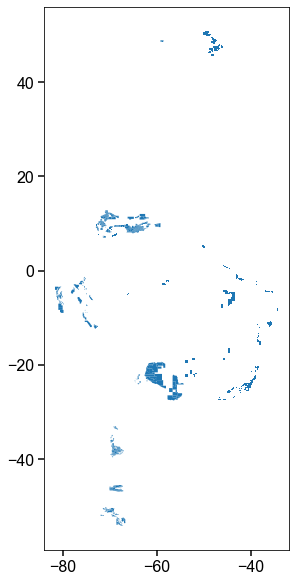

In [139]:
# Preview
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(direction='out', length=6, width=1.5, labelsize=16)
p1 = blks3.plot(ax=ax)

100%|████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:00<00:00, 2371.34it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,OPERATOR,AREA_KM2,geometry
0,4035056,OIL AND NATURAL GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,PUESTO QUIROGA,TECPETROL S.A.,188.0,"POLYGON ((-67.92109 -45.92776, -67.88885 -45.9..."
1,4035057,OIL AND NATURAL GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,LA TAPERA,TECPETROL S.A.,153.0,"POLYGON ((-68.08657 -45.86104, -68.04081 -45.8..."
2,4035058,OIL AND NATURAL GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,EL TORDILLO,TECPETROL S.A.,117.0,"POLYGON ((-68.04081 -45.86067, -68.02400 -45.8..."
3,4035059,OIL AND NATURAL GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,ESTANCIA LA MARIPOSA,TECPETROL S.A.,28.0,"POLYGON ((-68.11724 -46.08166, -68.11656 -46.1..."
4,4035060,OIL AND NATURAL GAS LICENSE BLOCKS,ARGENTINA,N/A,119,2022-05-12,N/A,LOS BASTOS,TECPETROL S.A.,369.0,"POLYGON ((-68.51003 -38.79280, -68.50884 -38.9..."


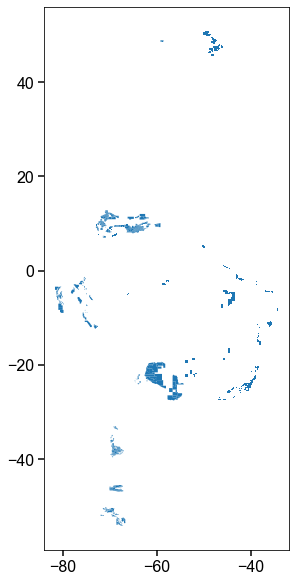

In [140]:
# Strip Z coordinate
blks4 = transform_geom_3d_2d(blks3)
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(direction='out', length=6, width=1.5, labelsize=16)
p1 = blks4.plot(ax=ax)

In [141]:
# Write to GeoPackage
# ==============================
blks4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_License_Blocks", driver="GPKG", encoding="utf-8")

# GeoJSON
blks4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\Oil_Natural_Gas_License_Blocks.geojson", driver="GeoJSON", encoding="utf-8")


# Oil and natural gas shale plays

In [142]:
# Read dataset
fields_ = glob.glob(os.getcwd() + "\\*field*.geojson")
fld1 = read_data_(fields_).reset_index(drop=True)

Total # of records =  4677


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,4432155,OIL AND GAS FIELDS,ARGENTINA,N/A,118,2022-04-04,N/A,N/A,N/A,QUINTANA E&P ARGENTINA S.R.L.,6.94,"MULTIPOLYGON (((-69.66932 -46.26305, -69.66948..."
1,4432156,OIL AND GAS FIELDS,ARGENTINA,N/A,118,2022-04-04,N/A,N/A,N/A,TECPETROL S.A.,1.8,"POLYGON ((-68.67266 -38.90514, -68.67263 -38.9..."
2,4432157,OIL AND GAS FIELDS,ARGENTINA,N/A,118,2022-04-04,N/A,N/A,N/A,OILSTONE ENERGIA S.A.,11.6,"POLYGON ((-69.81613 -38.96206, -69.81628 -38.9..."
3,4432158,OIL AND GAS FIELDS,ARGENTINA,N/A,118,2022-04-04,N/A,N/A,N/A,MEDANITO S.A.,76.90000000000001,"POLYGON ((-69.02854 -37.53261, -69.02851 -37.4..."
4,4432159,OIL AND GAS FIELDS,ARGENTINA,N/A,118,2022-04-04,N/A,N/A,N/A,EXXONMOBIL EXPLORATION ARGENTINA S.R.L.,0.502,"POLYGON ((-69.23493 -37.46478, -69.23431 -37.4..."


In [143]:
# Check CATEGORY
us_shale = fld1.query('COUNTRY == "UNITED STATES"')
ab_shale = read_spatial_data("canada_alberta_oil_natural_gas_plays_.geojson")
combined_shale_ = pd.concat([us_shale, ab_shale]).reset_index()
combined_shale_['CATEGORY'] = "OIL AND NATURAL GAS SHALE PLAYS"

---------------------------------------
Total # of features in dataset = 118
Index(['OGIM_ID', 'CATEGORY', 'COUNTRY', 'STATE_PROV', 'SRC_REF_ID',
       'SRC_DATE', 'ON_OFFSHORE', 'NAME', 'RESERVOIR_TYPE', 'OPERATOR',
       'AREA_KM2', 'geometry'],
      dtype='object')


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,1875257,OIL AND NATURAL GAS PLAYS,CANADA,ALBERTA,21,2022-04-09,ONSHORE,DUVERNAY FOX CREEK,"GAS, OIL",N/A,90200,"MULTIPOLYGON (((-116.40043 54.24637, -116.4065..."
1,1875258,OIL AND NATURAL GAS PLAYS,CANADA,ALBERTA,21,2022-04-09,ONSHORE,BANFF LACOMBE,"GAS, OIL",N/A,20600,"POLYGON ((-113.53079 52.31821, -113.53182 52.3..."
2,1875259,OIL AND NATURAL GAS PLAYS,CANADA,ALBERTA,21,2022-04-09,ONSHORE,GLAUCONITIC CONSORT,"GAS, OIL",N/A,20000,"MULTIPOLYGON (((-110.00512 51.96877, -110.2430..."
3,1875260,OIL AND NATURAL GAS PLAYS,CANADA,ALBERTA,21,2022-04-09,ONSHORE,MONTNEY GRIMSHAW,"GAS, OIL",N/A,22800,"MULTIPOLYGON (((-116.71175 53.36662, -116.8022..."
4,1875261,OIL AND NATURAL GAS PLAYS,CANADA,ALBERTA,21,2022-04-09,ONSHORE,OSTRACOD AIRDRIE,"GAS, OIL",N/A,196000,"POLYGON ((-113.73214 55.48262, -113.73214 55.4..."


In [144]:
# Data quality checks
shale2 = data_quality_checks(combined_shale_, starting_ogim_id=blks4.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 300.72it/s]

Number of features with INVALID geometries =  0


,index,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry


168it [00:00, 8026.83it/s]

0.---> index <----
array([4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637,
       4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648,
       4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659,
       4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670,
       4671, 4672, 4673, 4674, 4675, 4676,    0,    1,    2,    3,    4,
          5,    6,    7,    8,    9,   10,   11,   12,   13,   14,   15,
         16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26,
         27,   28,   29,   30,   31,   32,   33,   34,   35,   36,   37,
         38,   39,   40,   41,   42,   43,   44,   45,   46,   47,   48,
         49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
         60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,
         71,   72,   73,   74,   75,   76,   77,   78,   79,   80,   81,
         82,   83,   84,   85,   86,   87,   88,   89,   90,   91,   92,
         93,   94,   95,   96,  

In [145]:
# Drop unneeded columns
shale3 = shale2.drop(columns=['OPERATOR'])

In [146]:
shale4 = shale3.drop(columns=['index'])

In [147]:
# Write to GeoPackage
# ==============================
shale4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Shale_Plays", driver="GPKG", encoding="utf-8")

# GeoJSON
shale4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\Oil_Natural_Gas_Shale_Plays.geojson", driver="GeoJSON", encoding="utf-8")


# Oil and natural gas fields

In [148]:
fld3 = fld1.query('COUNTRY != "UNITED STATES"').reset_index()

In [149]:
# US oil and gas fields
# For US, add detailed field boundary data from EIA (https://www.eia.gov/maps/maps.htm) Shapefiles for Detailed Oil and Gas Field Maps

fld_us = r"Public_Data\data\North_America\United_States_\downloads_04102022\oil_gas_fields\oil_gas_fields_eia"
all_shp = glob.glob(fld_us + "\\*.shp")
us_flds = []

for file in all_shp:
    gdf_ = read_spatial_data(file)
    gdf2 = transform_CRS(gdf_)
    us_flds.append(gdf2)
    
# Concatenate
us_flds2 = pd.concat(us_flds)

---------------------------------------
Total # of features in dataset = 44
Index(['field', 'FLDCD_DOE', 'BASIN', 'STATE', 'Shape_Leng', 'Shape_Area',
       'ON_OFFSHOR', 'BOERES_CLA', 'GASRES_CLA', 'LIQRES_CLA', 'PctFedLand',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,BASIN,STATE,Shape_Leng,Shape_Area,ON_OFFSHOR,BOERES_CLA,GASRES_CLA,LIQRES_CLA,PctFedLand,geometry
0,ALBERT KALOA,7588,SOUTH ALASKA BASIN,AK,4542.701236,5.196417e+05,OFFSHORE,NA,NA,NA,NA,"POLYGON ((-56800.901 6808122.814, -56941.173 6..."
1,BELUGA RIVER,54998,SOUTH ALASKA BASIN,AK,18060.476514,1.128208e+07,OFFSHORE,NA,NA,NA,NA,"POLYGON ((-34942.466 6824923.942, -34946.079 6..."
2,COSMOPOLITAN,0,SOUTH ALASKA BASIN,AK,5084.668601,2.023670e+06,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((-103342.430 6684809.637, -1033..."
3,GRANITE PT,0,SOUTH ALASKA BASIN,AK,34432.817987,2.649628e+07,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((-58573.666 6798480.248, -58643..."
4,IVAN RIVER,350238,SOUTH ALASKA BASIN,AK,2084.796653,1.666670e+05,OFFSHORE,NA,NA,NA,NA,"POLYGON ((-24572.697 6828295.499, -24523.643 6..."


CRS of original gdf is:  epsg:26707
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 3
Index(['field', 'PctFedLand', 'INBAS_FRC', 'State', 'fldcd_doe', 'liqres_cla',
       'gasres_cla', 'boeres_cla', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


,field,PctFedLand,INBAS_FRC,State,fldcd_doe,liqres_cla,gasres_cla,boeres_cla,Shape_Leng,Shape_Area,geometry
0,BARROW,0.074291,1.000000,AK,40807.0,0.0,4.0,4.0,25282.134206,1.250815e+07,"MULTIPOLYGON (((-55882.845 7978122.454, -55872..."
1,WALAKPA,0.000000,1.000000,AK,14177.0,0.0,5.0,5.0,25941.491610,4.692272e+07,"POLYGON ((-76840.712 7960758.248, -76810.804 7..."
2,COLVILLE RIVER,0.000000,0.122351,AK,12998.0,5.0,6.0,6.0,16143.766282,8.607137e+06,"MULTIPOLYGON (((122170.515 7832057.694, 122064..."


CRS of original gdf is:  epsg:26707
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 35
Index(['field', 'FLDCD_DOE', 'BASIN', 'STATE', 'Shape_Leng', 'Shape_Area',
       'ON_OFFSHOR', 'BOERES_CLA', 'GASRES_CLA', 'LIQRES_CLA', 'PctFedLand',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,BASIN,STATE,Shape_Leng,Shape_Area,ON_OFFSHOR,BOERES_CLA,GASRES_CLA,LIQRES_CLA,PctFedLand,geometry
0,ALPINE,12998,NORTH ALASKA BASIN,AK,2357.542801,2.922030e+05,OFFSHORE,NA,NA,NA,NA,"POLYGON ((121118.444 7838588.998, 121085.741 7..."
1,BADAMI,0,NORTH ALASKA BASIN,AK,14287.973149,4.111811e+06,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((271674.559 7796129.174, 271724..."
2,EIDER,0,NORTH ALASKA BASIN,AK,6139.859674,2.571039e+06,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((239373.421 7819869.934, 239369..."
3,ENDICOTT,0,NORTH ALASKA BASIN,AK,36911.406801,3.687271e+07,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((246225.087 7815518.753, 246155..."
4,KUPARUK RIVER,4339,NORTH ALASKA BASIN,AK,38546.832361,1.350144e+07,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((161662.691 7839800.644, 161670..."


CRS of original gdf is:  epsg:26707
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 3220
Index(['field', 'OBJECTID', 'PctFedLand', 'INBAS_FRC', 'State', 'fldcd_doe',
       'liqres_cla', 'gasres_cla', 'boeres_cla', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,field,OBJECTID,PctFedLand,INBAS_FRC,State,fldcd_doe,liqres_cla,gasres_cla,boeres_cla,Shape_Leng,Shape_Area,geometry
0,ALLRED,1,0.0,1.0,TN,12161.0,0.0,0.0,0.0,22320.945667,1.343989e+07,"MULTIPOLYGON (((658387.183 4021295.498, 658402..."
1,ARCOTT SCHOOL,2,0.0,1.0,TN,23709.0,0.0,0.0,0.0,20488.824748,1.612884e+07,"POLYGON ((627000.593 4041540.547, 627015.544 4..."
2,ASHBURN CREEK,3,0.0,1.0,TN,27081.0,0.0,0.0,0.0,14059.915050,7.617218e+06,"MULTIPOLYGON (((652617.508 4048918.543, 652632..."
3,ASHBURN CREEK S,4,0.0,1.0,TN,0.0,2.0,0.0,2.0,23260.997714,4.932301e+06,"MULTIPOLYGON (((651151.891 4042094.179, 651157..."
4,BEATY,5,0.0,1.0,TN,4672.0,0.0,0.0,0.0,6175.062698,2.907809e+06,"POLYGON ((672688.930 4033253.823, 672703.880 4..."


CRS of original gdf is:  epsg:26716
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 235
Index(['field', 'OBJECTID', 'PctFedLand', 'State', 'Shape_Leng', 'Shape_Area',
       'INBAS_FRC', 'FLDCD_DOE', 'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA',
       'geometry'],
      dtype='object')


,field,OBJECTID,PctFedLand,State,Shape_Leng,Shape_Area,INBAS_FRC,FLDCD_DOE,LIQRES_CLA,GASRES_CLA,BOERES_CLA,geometry
0,ABBOTT,1,0.0,MS,7712.216960,4.141485e+06,1.0,1466,0,3,2,"POLYGON ((329417.977 3733290.460, 329432.928 3..."
1,ABERDEEN,2,0.0,MS,15869.458192,1.409246e+07,1.0,1962,0,2,1,"POLYGON ((348116.034 3745134.093, 348125.728 3..."
2,ABERDEEN E,3,0.0,MS,13929.438177,9.057356e+06,1.0,13173,0,4,3,"POLYGON ((355018.983 3742641.288, 355033.933 3..."
3,ABERDEEN S,4,0.0,MS,15328.513321,9.567632e+06,1.0,8855,0,0,0,"POLYGON ((349934.134 3739558.523, 349949.085 3..."
4,AMORY,5,0.0,MS,5039.949175,2.008768e+06,1.0,16408,0,0,0,"POLYGON ((371355.039 3751302.592, 371369.990 3..."


CRS of original gdf is:  epsg:26716
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 1638
Index(['field', 'OBJECTID', 'PctFedLand', 'INBAS_FRC', 'State', 'FLDCD_DOE',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,field,OBJECTID,PctFedLand,INBAS_FRC,State,FLDCD_DOE,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,ACE HI,1,0.0,1.0,NE,2272,1,0.0,1.0,6878.856538,3.474616e+06,"POLYGON ((147237.429 4586278.002, 147252.380 4..."
1,ALBIN,2,0.0,1.0,NE,7666,1,0.0,1.0,6619.492638,3.261645e+06,"POLYGON ((81772.446 4600421.409, 81787.398 460..."
2,ALBIN E,3,0.0,1.0,NE,6078,1,0.0,1.0,5039.950206,2.008769e+06,"POLYGON ((83417.382 4600738.714, 83432.334 460..."
3,ALBIN N,4,0.0,1.0,NE,7697,0,0.0,0.0,7946.802506,4.610130e+06,"POLYGON ((82244.869 4601631.065, 82259.820 460..."
4,ALBIN W,5,0.0,1.0,NE,2564,0,0.0,0.0,6087.869632,2.837793e+06,"POLYGON ((79309.934 4599337.207, 79311.286 459..."


CRS of original gdf is:  epsg:26714
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 29
Index(['field', 'FLDCD_DOE', 'PctFedLand', 'FRC_INBASI', 'BASIN', 'STATE',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,PctFedLand,FRC_INBASI,BASIN,STATE,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,LONE MOUNTAIN,0.0,0.000000,1.0,EASTERN GREAT BASIN,UT,0.0,0.0,0.0,7157.802760,4.048361e+06,"POLYGON ((453111.076 4374324.560, 453141.126 4..."
1,ROZEL POINT,0.0,0.061265,1.0,EASTERN GREAT BASIN,UT,0.0,0.0,0.0,8765.827679,5.779650e+06,"POLYGON ((360741.797 4589237.677, 360877.274 4..."
2,RPD_BOX ELDERCO_1,0.0,0.134320,1.0,EASTERN GREAT BASIN,UT,0.0,0.0,0.0,8710.787311,5.828517e+06,"POLYGON ((412627.840 4595876.604, 412786.951 4..."
3,RPD_BOX ELDERCO_2,0.0,0.855780,1.0,EASTERN GREAT BASIN,UT,0.0,0.0,0.0,7141.618654,4.048359e+06,"POLYGON ((395331.915 4591449.519, 395134.291 4..."
4,RPD_CACHECO_1,0.0,0.000000,1.0,EASTERN GREAT BASIN,UT,0.0,0.0,0.0,7967.357114,4.983496e+06,"POLYGON ((427604.061 4643212.479, 427621.350 4..."


CRS of original gdf is:  epsg:26712
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 1
Index(['field', 'FLDCD_DOE', 'PctFedLand', 'FRC_INBASI', 'BASIN', 'STATE',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,PctFedLand,FRC_INBASI,BASIN,STATE,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,RATTLESNAKE HILLS,0.0,1.0,1.0,EASTERN OR-WA,WA,0,0,0,20207.516614,1.549085e+07,"POLYGON ((760510.088 5147252.034, 760522.313 5..."


CRS of original gdf is:  epsg:26710
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 1900
Index(['OBJECTID', 'FIELD', 'INBAS_FRC', 'FLDCD_DOE', 'Basin', 'PctFedLand',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,OBJECTID,FIELD,INBAS_FRC,FLDCD_DOE,Basin,PctFedLand,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,1,SCOTT HILL,0.761117,9641,UP,0.463615,2.0,0.0,2.0,7904.447773,3.352131e+06,"POLYGON ((290810.818 4453267.990, 290901.249 4..."
1,2,BELL SPRINGS,0.984130,53386,GGR,0.464797,0.0,0.0,0.0,28617.034008,3.987710e+07,"POLYGON ((304653.578 4648027.130, 304605.618 4..."
2,3,BIRD CANYON,0.997822,65396,GGR,0.884278,2.0,5.0,4.0,100542.973146,1.541984e+08,"MULTIPOLYGON (((76719.480 4696809.818, 76749.8..."
3,4,CLAY BASIN,0.994288,0,GGR,0.869101,2.0,5.0,4.0,29301.884251,3.464804e+07,"POLYGON ((141354.831 4543786.457, 140489.031 4..."
4,5,DUNES,0.999054,206377,GGR,0.899744,0.0,0.0,0.0,14608.427843,1.516863e+07,"POLYGON ((323005.099 4663406.168, 323043.798 4..."


CRS of original gdf is:  epsg:26713
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 21
Index(['field', 'ObjectID', 'PctFedLand', 'Shape_Leng', 'Shape_Area', 'STATE',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'FLDCD_DOE', 'INBAS_FRC',
       'geometry'],
      dtype='object')


,field,ObjectID,PctFedLand,Shape_Leng,Shape_Area,STATE,LIQRES_CLA,GASRES_CLA,BOERES_CLA,FLDCD_DOE,INBAS_FRC,geometry
0,BAXTER ISLAND,1,0.0,6445.171086,3.122253e+06,FL,0,0,0,3002,1.0,"POLYGON ((1082663.797 2907508.254, 1082678.747..."
1,BEAR ISLAND,2,0.0,21153.410305,1.467643e+07,FL,4,0,4,48829,1.0,"MULTIPOLYGON (((1067805.368 2917960.102, 10678..."
2,CORKSCREW,3,0.0,22731.288913,1.282917e+07,FL,3,2,3,9717,1.0,"POLYGON ((1041921.839 2937319.717, 1041936.789..."
3,FELDA W,4,0.0,33328.618183,4.913077e+07,FL,4,0,4,238211,1.0,"POLYGON ((1037896.210 2949886.926, 1037908.062..."
4,FORTY MILE BEND,5,0.0,10079.898251,4.017536e+06,FL,0,0,0,251845,1.0,"MULTIPOLYGON (((1119115.140 2863320.664, 11191..."


CRS of original gdf is:  epsg:26716
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 4
Index(['FIELD', 'FLDCD_DOE', 'OBJECTID', 'INBAS_FRC', 'PctFedLand', 'BASIN',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,FIELD,FLDCD_DOE,OBJECTID,INBAS_FRC,PctFedLand,BASIN,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,BLACKLEAF CANYON,0.0,1,1.0,0.31577,MTB,0.0,0.0,0.0,22374.846709,2.957859e+07,"POLYGON ((371491.126 5318547.105, 371521.027 5..."
1,GLACIER E,3611.0,2,1.0,0.00000,MTB,1.0,0.0,1.0,6080.283399,2.831125e+06,"POLYGON ((339680.871 5371471.973, 339695.821 5..."
2,POTSHOT PROSPECT,0.0,3,1.0,1.00000,MTB,0.0,0.0,0.0,10079.891979,8.035061e+06,"POLYGON ((368837.215 5324439.742, 368867.116 5..."
3,TWO MEDICINE CREEK,724012.0,4,1.0,0.00000,MTB,0.0,0.0,0.0,15687.079940,1.088841e+07,"MULTIPOLYGON (((343906.986 5366564.873, 343914..."


CRS of original gdf is:  epsg:26712
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 106
Index(['field', 'FLDCD_DOE', 'BASIN', 'STATE', 'Shape_Leng', 'Shape_Area',
       'ON_OFFSHOR', 'BOERES_CLA', 'GASRES_CLA', 'LIQRES_CLA', 'PctFedLand',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,BASIN,STATE,Shape_Leng,Shape_Area,ON_OFFSHOR,BOERES_CLA,GASRES_CLA,LIQRES_CLA,PctFedLand,geometry
0,ALEGRIA,0.0,VENTURA BASIN,CA,973.720207,13588.170182,OFFSHORE,NA,NA,NA,NA,"POLYGON ((751316.063 3817270.250, 751326.562 3..."
1,ALEGRIA OFFSHORE,0.0,VENTURA BASIN,CA,1784.448631,252751.549273,OFFSHORE,NA,NA,NA,NA,"POLYGON ((750696.216 3814371.620, 750646.837 3..."
2,CALIENTE OFFSHORE,0.0,VENTURA BASIN,CA,4542.045348,781458.595338,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((754956.386 3814491.959, 754991..."
3,CAPITAN,0.0,VENTURA BASIN,CA,1644.451283,91348.818704,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((771429.915 3817147.102, 771452..."
4,CARPINTERIA OFFSHORE,0.0,VENTURA BASIN,CA,4513.744963,792539.716536,OFFSHORE,NA,NA,NA,NA,"MULTIPOLYGON (((819177.474 3805512.571, 819190..."


CRS of original gdf is:  epsg:26710
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 955
Index(['field', 'FLDCD_DOE', 'PctFedLand', 'FRC_INBASI', 'basin', 'state',
       'LIQRES_CLA', 'GASRES_CLA', 'BOERES_CLA', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


,field,FLDCD_DOE,PctFedLand,FRC_INBASI,basin,state,LIQRES_CLA,GASRES_CLA,BOERES_CLA,Shape_Leng,Shape_Area,geometry
0,BUFFALO,101276,0.152686,1.0,WILLISTON BASIN,SD,4,2.0,4.0,105678.680896,1.731197e+08,"MULTIPOLYGON (((128857.657 5080072.015, 128859..."
1,BULL CREEK,102516,0.026524,1.0,WILLISTON BASIN,SD,2,0.0,2.0,19594.950861,9.760366e+06,"MULTIPOLYGON (((153358.843 5074400.411, 153360..."
2,BUTTE-HARDING,0,0.887404,1.0,WILLISTON BASIN,SD,0,0.0,0.0,21449.347310,1.219956e+07,"MULTIPOLYGON (((118292.287 5019852.487, 118294..."
3,CADY CREEK,236,0.583858,1.0,WILLISTON BASIN,SD,0,3.0,3.0,58463.469922,8.118985e+07,"MULTIPOLYGON (((116800.182 5022353.021, 116802..."
4,CAMEL CREEK,0,0.000000,1.0,WILLISTON BASIN,SD,0,0.0,0.0,5055.005565,2.032724e+06,"POLYGON ((144088.940 5088261.352, 144090.646 5..."


CRS of original gdf is:  epsg:26714
CRS of new gdf is:  epsg:4326
---------------------------------------
Total # of features in dataset = 28
Index(['field', 'OBJECTID', 'PctFedLand', 'State', 'fldcd_doe', 'liqres_cla',
       'gasres_cla', 'boeres_cla', 'Shape_Leng', 'Shape_Area', 'INBAS_FRC',
       'geometry'],
      dtype='object')


,field,OBJECTID,PctFedLand,State,fldcd_doe,liqres_cla,gasres_cla,boeres_cla,Shape_Leng,Shape_Area,INBAS_FRC,geometry
0,ANSCHUTZ RANCH E_WY_S,1,0.055573,WY,2380.0,3.0,4.0,4.0,9861.495026,5.348613e+06,1.0,"POLYGON ((495864.226 4545051.414, 495874.804 4..."
1,BESSIE BOTTOM,2,0.304158,WY,7286.0,0.0,0.0,0.0,14056.661267,1.048659e+07,1.0,"POLYGON ((497613.101 4549153.107, 497628.052 4..."
2,CHICKEN CREEK,3,0.111766,WY,138084.0,0.0,0.0,0.0,13729.506581,1.237961e+07,1.0,"POLYGON ((495905.561 4555326.202, 495935.462 4..."
3,CLEAR CREEK_WY_D,4,0.356889,WY,147121.0,0.0,0.0,0.0,14079.737965,1.296036e+07,1.0,"POLYGON ((511754.142 4582896.106, 511768.972 4..."
4,COLLETT CREEK,5,0.958379,WY,12935.0,2.0,3.0,2.0,7373.679508,3.870505e+06,1.0,"POLYGON ((510869.304 4624498.304, 510884.254 4..."


CRS of original gdf is:  epsg:26712
CRS of new gdf is:  epsg:4326


In [150]:
# Check columns
us_flds2.columns

Index(['field', 'FLDCD_DOE', 'BASIN', 'STATE', 'Shape_Leng', 'Shape_Area',
       'ON_OFFSHOR', 'BOERES_CLA', 'GASRES_CLA', 'LIQRES_CLA', 'PctFedLand',
       'geometry', 'INBAS_FRC', 'State', 'fldcd_doe', 'liqres_cla',
       'gasres_cla', 'boeres_cla', 'OBJECTID', 'FRC_INBASI', 'FIELD', 'Basin',
       'ObjectID', 'basin', 'state'],
      dtype='object')

In [151]:
# Calculate basin area
us_flds3 = calculate_basin_area_km2(us_flds2).reset_index()

Current CRS is:  epsg:4326
Reprojecting to Eckert IV
Reprojecting finished. New CRS is:  +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
CRS of original gdf is:  +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
CRS of new gdf is:  epsg:4326


In [152]:
# Integrate
us_fieldss, _errors_ = integrate_basins(
    us_flds3,
    starting_ids=1,
    category="Oil and natural gas fields",
    fac_alias="OIL_GAS_BASINS",
    country="United States",
    state_prov="STATE",
    src_ref_id="143,144,145,146",
    src_date="2016-06-30",
    on_offshore="ON_OFFSHOR",
    _name="field",
    reservoir_type=None,
    op_name=None,
    _area_km2="AREA_KM2"
    )

100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [00:03<00:00, 2308.36it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,1,OIL AND NATURAL GAS FIELDS,UNITED STATES,AK,"143,144,145,146",2016-06-30,OFFSHORE,ALBERT KALOA,N/A,N/A,0.514,"POLYGON ((-151.33072 61.01259, -151.33286 61.0..."
1,2,OIL AND NATURAL GAS FIELDS,UNITED STATES,AK,"143,144,145,146",2016-06-30,OFFSHORE,BELUGA RIVER,N/A,N/A,11.2,"POLYGON ((-150.97971 61.19135, -150.97958 61.1..."
2,3,OIL AND NATURAL GAS FIELDS,UNITED STATES,AK,"143,144,145,146",2016-06-30,OFFSHORE,COSMOPOLITAN,N/A,N/A,2.0,"MULTIPOLYGON (((-151.80457 59.85750, -151.8045..."
3,4,OIL AND NATURAL GAS FIELDS,UNITED STATES,AK,"143,144,145,146",2016-06-30,OFFSHORE,GRANITE PT,N/A,N/A,26.2,"MULTIPOLYGON (((-151.33501 60.92493, -151.3362..."
4,5,OIL AND NATURAL GAS FIELDS,UNITED STATES,AK,"143,144,145,146",2016-06-30,OFFSHORE,IVAN RIVER,N/A,N/A,0.165,"POLYGON ((-150.79901 61.23518, -150.79808 61.2..."


In [153]:
# Combine fields data
flds_comb = pd.concat([fld3, us_fieldss])
flds_comb2 = flds_comb.drop(columns=['index'])

In [154]:
# Data quality checks
flds_ = data_quality_checks(flds_comb2, starting_ogim_id=shale4.OGIM_ID.iloc[-1]+1)

100%|██████████████████████████████████████████████████████████████████████████| 12846/12846 [00:05<00:00, 2241.24it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry


12846it [00:01, 9690.18it/s]


0.---> OGIM_ID <----
array([4036243, 4036244, 4036245, ..., 4049086, 4049087, 4049088])
1.---> CATEGORY <----
array(['OIL AND GAS FIELDS', 'OIL AND NATURAL GAS FIELDS'], dtype=object)
2.---> COUNTRY <----
array(['ARGENTINA', 'BOLIVIA', 'BRAZIL', 'CANADA', 'COLOMBIA', 'MEXICO',
       'UNITED STATES'], dtype=object)
3.---> STATE_PROV <----
array(['N/A', 'BRITISH COLUMBIA', 'MANITOBA', 'SASKATCHEWAN', 'AK', 'NAN',
       'UT', 'NV', 'WA', 'FL', 'CA'], dtype=object)
4.---> SRC_REF_ID <----
array(['118', '125', '126', '35', '55', '47', '128', '101',
       '143,144,145,146'], dtype=object)
5.---> SRC_DATE <----
array(['2022-04-04', '2017-09-09', '2022-05-15', '2022-03-08',
       '2022-03-29', '2022-03-28', '2020-12-14', '2022-04-11',
       '2016-06-30'], dtype=object)
6.---> ON_OFFSHORE <----
array(['N/A', 'ONSHORE', 'OFFSHORE', 'SHORELINE', 'NAN'], dtype=object)
7.---> NAME <----
array(['N/A', 'MADRE DE DIOS', 'COIPASA', ..., 'HOGBACK RIDGE',
       'LODGEPOLE_UT_D', 'PINEVIEW'], dtype=

<GeometryArray>
 ...
Length: 12443, dtype: geometry


In [155]:
# CATEGORY
flds_['CATEGORY'] = "OIL AND NATURAL GAS FIELDS"

In [156]:
# STATE_PROV
flds2 = replace_row_names(flds_, colName="STATE_PROV", dict_names={'AK':'ALASKA', 'UT':'UTAH', 'NV':'NEVADA', 'WA':'WASHINGTON', 'FL':'FLORIDA', 'CA':'CALIFORNIA', 'NAN':'N/A'})

Original list of unique attributes =  ['N/A' 'BRITISH COLUMBIA' 'MANITOBA' 'SASKATCHEWAN' 'AK' 'NAN' 'UT' 'NV'
 'WA' 'FL' 'CA']
['N/A' 'BRITISH COLUMBIA' 'MANITOBA' 'SASKATCHEWAN' 'ALASKA' 'UTAH'
 'NEVADA' 'WASHINGTON' 'FLORIDA' 'CALIFORNIA']


In [157]:
# ON_OFFSHORE
flds3 = replace_row_names(flds2, colName="ON_OFFSHORE", dict_names={'NAN':'N/A'})

Original list of unique attributes =  ['N/A' 'ONSHORE' 'OFFSHORE' 'SHORELINE' 'NAN']
['N/A' 'ONSHORE' 'OFFSHORE' 'SHORELINE']


<AxesSubplot:>

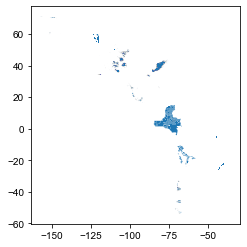

In [158]:
flds3.plot()

In [159]:
flds4 = flds3.reset_index(drop=True)

In [160]:
flds4.tail()

,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
12841,4049084,OIL AND NATURAL GAS FIELDS,UNITED STATES,N/A,"143,144,145,146",2016-06-30,N/A,ELKHORN RIDGE,N/A,N/A,11.00,"POLYGON ((-111.22107 40.89864, -111.22090 40.9..."
12842,4049085,OIL AND NATURAL GAS FIELDS,UNITED STATES,N/A,"143,144,145,146",2016-06-30,N/A,FIRTH,N/A,N/A,11.70,"POLYGON ((-111.07749 41.19575, -111.07713 41.1..."
12843,4049086,OIL AND NATURAL GAS FIELDS,UNITED STATES,N/A,"143,144,145,146",2016-06-30,N/A,HOGBACK RIDGE,N/A,N/A,8.05,"POLYGON ((-111.18919 41.85052, -111.18884 41.8..."
12844,4049087,OIL AND NATURAL GAS FIELDS,UNITED STATES,N/A,"143,144,145,146",2016-06-30,N/A,LODGEPOLE_UT_D,N/A,N/A,26.60,"POLYGON ((-111.27757 40.85913, -111.27740 40.8..."
12845,4049088,OIL AND NATURAL GAS FIELDS,UNITED STATES,N/A,"143,144,145,146",2016-06-30,N/A,PINEVIEW,N/A,N/A,23.20,"POLYGON ((-111.18018 40.93289, -111.18006 40.9..."


In [161]:
# Write to GeoPackage
# ==============================
flds4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Fields", driver="GPKG", encoding="utf-8")

# GeoJSON
flds4.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\Oil_Natural_Gas_Fields.geojson", driver="GeoJSON", encoding="utf-8")


# Sedimentary Basins

In [162]:
# Read dataset
basins_ = glob.glob(os.getcwd() + "\\*basin*.geojson")
bsn1 = read_data_(basins_).reset_index()

Total # of records =  469


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,4432131,OIL AND GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,CANADON ASFALTO,NON-PRODUCING,N/A,66900,"POLYGON ((-66.79256 -41.98249, -66.82109 -41.9..."
1,4432132,OIL AND GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,MERCEDES,NON-PRODUCING,N/A,10500,"POLYGON ((-65.84639 -34.00220, -65.77333 -33.9..."
2,4432133,OIL AND GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,BOLSONES INTERMONTANOS,NON-PRODUCING,N/A,109000,"MULTIPOLYGON (((-65.84905 -26.40968, -65.81727..."
3,4432134,OIL AND GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,NORESTE,NON-PRODUCING,N/A,673000,"POLYGON ((-61.71305 -23.24217, -61.71061 -23.2..."
4,4432135,OIL AND GAS BASINS,ARGENTINA,N/A,117,2022-04-11,OFFSHORE,PENINSULA VALDES,NON-PRODUCING,N/A,49400,"POLYGON ((-61.60655 -42.21659, -61.60390 -42.4..."


In [163]:
# Check basins CATEGORY
bsn1.CATEGORY.unique()
bsn1['CATEGORY'] = "OIL AND NATURAL GAS BASINS"

<AxesSubplot:>

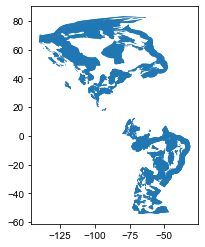

In [164]:
bsn1.plot()

In [165]:
# Add data for Canada from HIFLD
data_hifld_ = read_spatial_data(r"Public_Data\data\North_America\United_States_\downloads_04102022\oil_gas_fields\31cdd816-7f39-4bee-8fff-34e4b7f14d46.gdb")
can_= data_hifld_.query("COUNTRY == ['CAN', 'MEX']")
can_.head()

---------------------------------------
Total # of features in dataset = 224
Index(['PRODID', 'NAME', 'TYPE', 'COUNTRY', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'PLAY', 'COMMODITY',
       'PR_OIL', 'PR_OIL_UOM', 'PR_OIL_YR', 'PR_GAS', 'PR_GAS_UOM',
       'PR_GAS_YR', 'REGION', 'POSREL', 'SHAPE_Length', 'SHAPE_Area',
       'geometry'],
      dtype='object')


,PRODID,NAME,TYPE,COUNTRY,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,...,PR_OIL_UOM,PR_OIL_YR,PR_GAS,PR_GAS_UOM,PR_GAS_YR,REGION,POSREL,SHAPE_Length,SHAPE_Area,geometry
0,BAS0001,NORTHERN ALASKA,OIL AND NATURAL GAS FIELD,USA,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2015-01-15T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,ALASKA,NOTIONAL,4.146231e+06,-2.642916e+11,"MULTIPOLYGON (((-17283572.715 11481366.280, -1..."
1,BAS0002,NORTHERN ALASKA,OIL AND NATURAL GAS FIELD,USA,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2015-01-15T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,ALASKA,NOTIONAL,5.325520e+06,-6.399258e+11,"MULTIPOLYGON (((-17340583.429 11500024.471, -1..."
2,BAS0003,NORTHERN ALASKA,OIL AND NATURAL GAS FIELD,USA,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2015-01-15T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,ALASKA,NOTIONAL,4.163071e+06,-2.664623e+11,"MULTIPOLYGON (((-17340583.429 11500024.472, -1..."
3,BAS0004,ANADARKO BASIN,OIL AND NATURAL GAS FIELD,USA,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2015-01-15T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,WESTERN MID-CONTINENT,NOTIONAL,2.274646e+06,-7.814064e+10,"MULTIPOLYGON (((-10843257.116 4407530.936, -10..."
4,BAS0005,APPALACHIAN BASIN,OIL AND NATURAL GAS FIELD,USA,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2015-01-15T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,EASTERN MID-CONTINENT,NOTIONAL,1.778559e+06,-1.065947e+11,"MULTIPOLYGON (((-8858254.618 5200378.188, -885..."


,PRODID,NAME,TYPE,COUNTRY,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,...,PR_OIL_UOM,PR_OIL_YR,PR_GAS,PR_GAS_UOM,PR_GAS_YR,REGION,POSREL,SHAPE_Length,SHAPE_Area,geometry
32,BAS0033,SABINAS BASIN,OIL AND NATURAL GAS FIELD,MEX,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2004-01-01T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,MEXICO,NOTIONAL,1.309095e+06,-7.461101e+10,"MULTIPOLYGON (((-11106538.014 2905691.299, -11..."
34,BAS0035,BURGOS BASIN,OIL AND NATURAL GAS FIELD,MEX,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2004-01-01T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,MEXICO,NOTIONAL,1.939556e+06,-8.397513e+10,"MULTIPOLYGON (((-11204988.057 3369434.231, -11..."
37,BAS0038,TAMPICO-MISANTLA-MAGISCAT,OIL AND NATURAL GAS FIELD,MEX,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2004-01-01T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,MEXICO,NOTIONAL,1.461856e+06,-4.256866e+10,"MULTIPOLYGON (((-10832877.316 2454713.211, -10..."
38,BAS0039,MACUSPANA BASIN,OIL AND NATURAL GAS FIELD,MEX,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2004-01-01T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,MEXICO,NOTIONAL,6.050509e+05,-1.253408e+10,"MULTIPOLYGON (((-10329799.371 2137037.931, -10..."
39,BAS0040,MACUSPANA BASIN,OIL AND NATURAL GAS FIELD,MEX,211111,CRUDE PETROLEUM AND NATURAL GAS EXTRACTION,USGS,2004-01-01T00:00:00,OTHER,2015-07-06T00:00:00,...,NOT AVAILABLE,NOT AVAILABLE,-999.0,NOT AVAILABLE,NOT AVAILABLE,MEXICO,NOTIONAL,4.447436e+05,-6.733677e+09,"MULTIPOLYGON (((-10240297.556 2174629.592, -10..."


<AxesSubplot:>

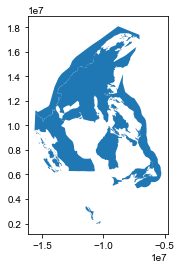

In [166]:
can_.plot()

In [167]:
# Transform CRS
can2 = transform_CRS(can_)

CRS of original gdf is:  epsg:3857
CRS of new gdf is:  epsg:4326


In [168]:
# Calculate basin area
can2A = replace_row_names(can2, colName="COUNTRY", dict_names={'CAN':"CANADA", 'MEX':'MEXICO'})
can3 = calculate_basin_area_km2(can2A)

Original list of unique attributes =  ['MEX' 'CAN']
['MEXICO' 'CANADA']
Current CRS is:  epsg:4326
Reprojecting to Eckert IV
Reprojecting finished. New CRS is:  +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
CRS of original gdf is:  +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
CRS of new gdf is:  epsg:4326


<AxesSubplot:>

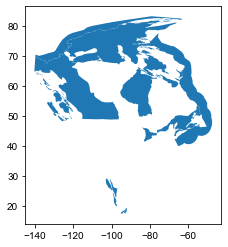

In [169]:
can3.plot()

In [170]:
# Integrate
can_basins1, _errors_ = integrate_basins(
    can3.reset_index(),
    starting_ids=1,
    category="Oil and natural gas basins",
    fac_alias="OIL_GAS_BASINS",
    country="COUNTRY",
    state_prov=None,
    src_ref_id="147",
    src_date="2009-01-01",
    on_offshore=None,
    _name="NAME",
    reservoir_type=None,
    op_name=None,
    _area_km2="AREA_KM2"
    )

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2004.79it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry
0,1,OIL AND NATURAL GAS BASINS,MEXICO,N/A,147,2009-01-01,N/A,SABINAS BASIN,N/A,N/A,58900.0,"MULTIPOLYGON (((-99.77173 25.24357, -99.75079 ..."
1,2,OIL AND NATURAL GAS BASINS,MEXICO,N/A,147,2009-01-01,N/A,BURGOS BASIN,N/A,N/A,68200.0,"MULTIPOLYGON (((-100.65612 28.95118, -100.6621..."
2,3,OIL AND NATURAL GAS BASINS,MEXICO,N/A,147,2009-01-01,N/A,TAMPICO-MISANTLA-MAGISCAT,N/A,N/A,36600.0,"MULTIPOLYGON (((-97.31339 21.52603, -97.34274 ..."
3,4,OIL AND NATURAL GAS BASINS,MEXICO,N/A,147,2009-01-01,N/A,MACUSPANA BASIN,N/A,N/A,11300.0,"MULTIPOLYGON (((-92.79417 18.84791, -92.79662 ..."
4,5,OIL AND NATURAL GAS BASINS,MEXICO,N/A,147,2009-01-01,N/A,MACUSPANA BASIN,N/A,N/A,6070.0,"MULTIPOLYGON (((-91.99016 19.16719, -91.99386 ..."


In [171]:
# Combine this data with the rest of the sedimentary basin dataset
basins = pd.concat([bsn1, can_basins1]).reset_index(drop=True)

In [172]:
basins2 = basins.drop(columns=['index'])

In [173]:
basins2.CATEGORY.unique()

array(['OIL AND NATURAL GAS BASINS'], dtype=object)

In [174]:
# Data quality checks
basins4 = data_quality_checks(basins2, starting_ogim_id=flds4.OGIM_ID.iloc[-1]+1)

100%|███████████████████████████████████████████████████████████████████████████████| 483/483 [00:02<00:00, 172.00it/s]

Number of features with INVALID geometries =  0


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,OPERATOR,AREA_KM2,geometry


483it [00:00, 7463.81it/s]


0.---> OGIM_ID <----
array([4049089, 4049090, 4049091, 4049092, 4049093, 4049094, 4049095,
       4049096, 4049097, 4049098, 4049099, 4049100, 4049101, 4049102,
       4049103, 4049104, 4049105, 4049106, 4049107, 4049108, 4049109,
       4049110, 4049111, 4049112, 4049113, 4049114, 4049115, 4049116,
       4049117, 4049118, 4049119, 4049120, 4049121, 4049122, 4049123,
       4049124, 4049125, 4049126, 4049127, 4049128, 4049129, 4049130,
       4049131, 4049132, 4049133, 4049134, 4049135, 4049136, 4049137,
       4049138, 4049139, 4049140, 4049141, 4049142, 4049143, 4049144,
       4049145, 4049146, 4049147, 4049148, 4049149, 4049150, 4049151,
       4049152, 4049153, 4049154, 4049155, 4049156, 4049157, 4049158,
       4049159, 4049160, 4049161, 4049162, 4049163, 4049164, 4049165,
       4049166, 4049167, 4049168, 4049169, 4049170, 4049171, 4049172,
       4049173, 4049174, 4049175, 4049176, 4049177, 4049178, 4049179,
       4049180, 4049181, 4049182, 4049183, 4049184, 4049185, 4049186,

<GeometryArray>
[          <shapely.geometry.polygon.Polygon object at 0x00000274360B7488>,
 ...
Length: 322, dtype: geometry


In [175]:
# Drop unneeded columns
basins5 = basins4.drop(columns=['OPERATOR'])

In [176]:
# Strip Z coordinates
basins6 = transform_geom_3d_2d(basins5)

100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [00:08<00:00, 55.12it/s]


,OGIM_ID,CATEGORY,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,NAME,RESERVOIR_TYPE,AREA_KM2,geometry
0,4049089,OIL AND NATURAL GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,CANADON ASFALTO,NON-PRODUCING,66900.0,"POLYGON ((-66.79256 -41.98249, -66.82109 -41.9..."
1,4049090,OIL AND NATURAL GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,MERCEDES,NON-PRODUCING,10500.0,"POLYGON ((-65.84639 -34.00220, -65.77333 -33.9..."
2,4049091,OIL AND NATURAL GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,BOLSONES INTERMONTANOS,NON-PRODUCING,109000.0,"MULTIPOLYGON (((-65.84905 -26.40968, -65.81727..."
3,4049092,OIL AND NATURAL GAS BASINS,ARGENTINA,N/A,117,2022-04-11,ONSHORE,NORESTE,NON-PRODUCING,673000.0,"POLYGON ((-61.71305 -23.24217, -61.71061 -23.2..."
4,4049093,OIL AND NATURAL GAS BASINS,ARGENTINA,N/A,117,2022-04-11,OFFSHORE,PENINSULA VALDES,NON-PRODUCING,49400.0,"POLYGON ((-61.60655 -42.21659, -61.60390 -42.4..."


<AxesSubplot:>

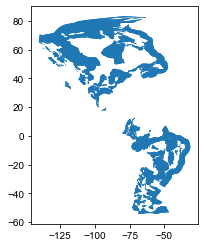

In [177]:
# Preview again
basins6.plot()

In [178]:
# Write to GeoPackage
# ==============================
basins6.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Oil_Natural_Gas_Basins", driver="GPKG", encoding="utf-8")

# GeoJSON
basins6.to_file(r"results\OGIM_NA_SA_v1.2\Oil_Natural_Gas_Basins.geojson", driver="GeoJSON", encoding="utf-8")


# Data catalog


In [179]:
catalog = pd.read_excel("ogim_standalone_source_table_v1.xlsx")
catalog.head()

,SRC_REF_ID,SRC_URL,SRC_NAME,SRC_ALIAS,SRC_TYPE,SRC_YEAR,SRC_MNTH,PUB_PRIV,PROD_DATA,UPDATE_FREQ,LASTVISIT,REGION,COUNTRY,STATE_PROV,FAC_CATEGORY,NOTES,Unnamed: 16
0,1,https://static.aer.ca/prd/documents/sts/st37/S...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,Wells,EPSG:4269,NaN
1,2,https://static.aer.ca/prd/documents/sts/st37/B...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,Wells,EPSG:4269,NaN
2,3,https://www.petrinex.ca/PD/Pages/APD.aspx,Petrinex (AB Well Infrastructure dataset),Petrinex,Government,2022.0,4.0,Public,No,Daily,2022-04-09,North America,Canada,Alberta,Wells,NaN,NaN
3,4,https://static.aer.ca/prd/data/codes/ST102-SHP...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,GATHERING AND PROCESSING,NaN,NaN
4,3,https://www.petrinex.ca/PD/Pages/APD.aspx,Petrinex (AB Facility Infrastructure dataset),Petrinex,Government,2022.0,4.0,Public,No,Daily,2022-04-09,North America,Canada,Alberta,GATHERING AND PROCESSING,NaN,NaN


In [180]:
# Exclude the last two rows
catalog2 = catalog.iloc[:,0:-2]

In [181]:
catalog2.head()

,SRC_REF_ID,SRC_URL,SRC_NAME,SRC_ALIAS,SRC_TYPE,SRC_YEAR,SRC_MNTH,PUB_PRIV,PROD_DATA,UPDATE_FREQ,LASTVISIT,REGION,COUNTRY,STATE_PROV,FAC_CATEGORY
0,1,https://static.aer.ca/prd/documents/sts/st37/S...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,Wells
1,2,https://static.aer.ca/prd/documents/sts/st37/B...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,Wells
2,3,https://www.petrinex.ca/PD/Pages/APD.aspx,Petrinex (AB Well Infrastructure dataset),Petrinex,Government,2022.0,4.0,Public,No,Daily,2022-04-09,North America,Canada,Alberta,Wells
3,4,https://static.aer.ca/prd/data/codes/ST102-SHP...,Alberta Energy Regulator,AER,Government,2022.0,4.0,Public,No,Monthly,2022-04-09,North America,Canada,Alberta,GATHERING AND PROCESSING
4,3,https://www.petrinex.ca/PD/Pages/APD.aspx,Petrinex (AB Facility Infrastructure dataset),Petrinex,Government,2022.0,4.0,Public,No,Daily,2022-04-09,North America,Canada,Alberta,GATHERING AND PROCESSING


In [182]:
# Capitalize everything
cols_ = list(catalog2.columns[2:])
for attr in cols_:
    catalog2[attr] = [str(catalog2[attr].iloc[x]).upper() for x in range(catalog2.shape[0])]

In [183]:
# Create a GeoDataFrame
catalog2['geometry'] = None

# Set geometry
catalog3 = gpd.GeoDataFrame(catalog2)

In [184]:
# Write to GeoPackage
# ==============================
catalog3.to_file(r"results\OGIM_NA_SA_v1.2\GeoPackage\OGIM_NA_SA_v1.2.gpkg", layer="Data_Catalog", driver="GPKG", encoding="utf-8")